# Sentiment analysis on news headlines

The goal of this project is to test the hypothesized advantages of using and fine-tuning pre-trained language models of BERT (Bidirectional Encoder Representations from Transformers), which is a 2018 paper published by researchers at Google AI Language, for financial domain. For that, sentiment of a sentence from a financial news article towards the financial actor depicted in the sentence will be tried to be predicted, using the Financial PhraseBank created by Malo et al. from Cornell University. (2014)

<table><tr><td>
<img src="./docs/bert_context.png" width="400">
</td><td>
<img src="./docs/bert_structure2.png" width="600">
</td></tr></table>

<br />
<br />

The models tested in this projects are as follows:
<br />
 * A. Lexicon-based approach (Loughran and McDonald Dictionary)
 * B. Tfidf
 * C. LSTM (RNN)
 * D. LSTM with GloVe word embedding
 * E. Bert (pre-trained, hugging-face impementation)
<br />
<br />
<br />

![All Models](./docs/all_models.png)

## Import and configurations

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

False

In [2]:
# # Use TPU
# if IN_COLAB:
#     # TPU Setting
#     import os
#     assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook setting > Hardware accelerator'
    
#     VERSION = "20200220"
#     !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#     !python pytorch-xla-env-setup.py --version $VERSION

In [3]:
# Note: After the following pip install, need to restart the kernel.
# Required modules - written here so that it can setup a new instance in Colab. Not required to run every time.
if IN_COLAB:
    !pip install numpy==1.16.4
    !pip install pandas==0.25.0
    !pip install torch==1.4.0
    !pip install tqdm==4.43.0
    !pip install scikit-plot
    !pip install transformers

In [4]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
import time
import logging
import random
from collections import defaultdict, Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, plot_confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate, StratifiedKFold, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import scikitplot as skplt

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

# Import Pytorch modules
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
from torch.autograd import Variable
from torch.optim import Adam, AdamW

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
# Set logger
logger = logging.getLogger('mylogger')
logger.setLevel(logging.INFO)

timestamp = time.strftime("%Y.%m.%d_%H.%M.%S", time.localtime())
formatter = logging.Formatter('[%(asctime)s][%(levelname)s] ## %(message)s')

fh = logging.FileHandler('log_model.txt')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)

In [6]:
# Set Random Seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
rand_seed = 42

In [7]:
# Set Seaborn Style
sns.set(style='white', context='notebook', palette='deep')

In [8]:
# Check Device
if IN_COLAB:
    torch.cuda.get_device_name(0)

In [9]:
# Mount Google Drive
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [10]:
if IN_COLAB:
    finphrase_dir = 'drive/My Drive/Colab Data/'
    output_dir = 'drive/My Drive/Colab Data/'
    lmdict_dir = 'drive/My Drive/Colab Data/'
    glove_dir = 'drive/My Drive/Colab Data/'
else:
    finphrase_dir = './data/FinancialPhraseBank-v1.0/'
    output_dir = './data/result/'
    lmdict_dir = './data/LoughranMcDonald/'
    glove_dir = './data/GloVe/'

## Load input data
Financial Phrasebank consists of 4845 english sentences selected randomly from financial news found on LexisNexis database. These sentences then were annotated by 16 people with background in finance and business. The annotators were asked to give labels according to how they think the information in the sentence might affect the mentioned company stock price. The dataset also includes information regarding the agreement levels on sentences among
annotators.

In [11]:
def load_finphrase(filename):
    ''' Clean FinancialPhrasebank data
        Input:
            - filename
        Output:
            - a dataframe for the loaded financial phase bank data
    '''
    df = pd.read_csv(finphrase_dir + filename,
                     sep='\@',
                     engine='python',
                     header=None,
                     names=['sentence','label'])
    print('Total number of record in the file: ', df.shape[0])
    df.drop_duplicates(inplace=True)
    print('Total number of record after dropping duplicates: ', df.shape[0])
    print('Missing label: ', df['label'].isnull().sum())
    df.reset_index(inplace=True, drop=True)
    # df = pd.get_dummies(df, columns=['label'])
    return df

In [12]:
# Load data
# filename = 'Sentences_66Agree.txt'
# filename = 'Sentences_50Agree.txt'
filename = 'Sentences_75Agree.txt'
# filename = 'Sentences_AllAgree.txt'

train_df = load_finphrase(filename)
pd.set_option('display.max_colwidth', -1)
train_df.sample(n=20, random_state=42)

Total number of record in the file:  3453
Total number of record after dropping duplicates:  3448
Missing label:  0


sentence  \
2900  The period-end cash and cash equivalents totaled EUR6 .5 m , compared to EUR10 .5 m in the previous year .                                                                                                                                                                                         
51    In June it sold a 30 percent stake to Nordstjernan , and the investment group has now taken up the option to acquire EQT 's remaining shares .                                                                                                                                                     
567   The aim is an annual improvement in Ruukki Construction 's operating profit of more than EUR 3 million USD 4.1 m starting in 2009 .                                                                                                                                                                
3268  Sampo Bank 's market share of lending was 13.6 % , down from 14.4 % in the first quarter of 2008 .                                                                                                                                                                                                 
1987  In 2008 , the steel industry accounted for 64 percent of the cargo volumes transported , whereas the energy industry accounted for 28 percent and other industries for 8 percent .                                                                                                                 
1873  An earn-out payment of up to 4.0 mln euro ( $ 5.3 mln ) can also be paid depending on Intellibis financial performance in 2007 .                                                                                                                                                                   
229   Profit for the period totaled EUR 39.4 mn , up from EUR 33.9 mn in the corresponding period in 2006 .                                                                                                                                                                                              
298   Operating profit of the Asian plants grew markedly .                                                                                                                                                                                                                                               
605   Finnish steel maker Rautaruukki Oyj ( Ruukki ) said on July 7 , 2008 that it won a 9.0 mln euro ( $ 14.1 mln ) contract to supply and install steel superstructures for Partihallsforbindelsen bridge project in Gothenburg , western Sweden .                                                     
705   The rationalization of the operations seeks to achieve over EUR 1 million in yearly savings as from the second quarter of the current financial year .                                                                                                                                             
2713  The expanded company will continue to be called NewPage .                                                                                                                                                                                                                                          
1650  Our customers come from the following countries : UK , USA , Spain , France , Italy , Germany , China , Hong Kong , Sweden , Norway , Netherlands , Austria , Belgium , Switzerland , Czech Republic , Finland , Canada , Russia , Ukraine , Denmark , Ireland , South Korea and Liechtenstein .   
2126  ST. PETERSBURG , Oct 14 ( PRIME-TASS ) -- Finnish tire producer Nokian Tyres plans to invest about 50 million euros in the expansion of its tire plant in the city of Vsevolozhsk in Russia 's Leningrad Region in 2011 , the company 's President Kim Gran told reporters Thursday .              
945   The new B shares carry the right to dividend and other shareholder rights with effect from today .          

In [13]:
pd.set_option('display.max_colwidth', 50)

Text(0.5, 1.0, 'The number of words per data')

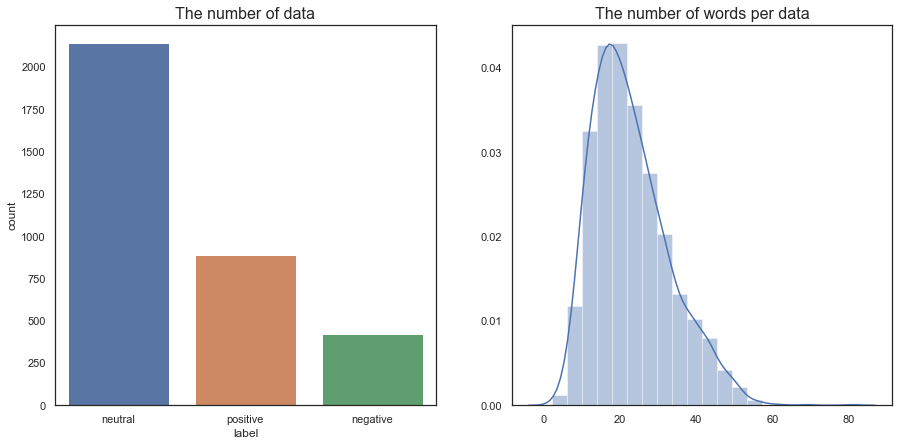

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

sns.countplot(x='label', data=train_df, ax=ax1)
ax1.set_title('The number of data', fontsize=16)
sns.distplot([len(nltk.word_tokenize(words)) for words in train_df['sentence']], bins=20, ax=ax2)
ax2.set_title('The number of words per data', fontsize=16)

More than 60% of the data are labeled as "neutral". Sometimes imbalanced data are balanced using methods like resampling (oversampling, under-sampling) as models tend to predict the majority class more. SMOTE or the Synthetic Minority Over-sampling Technique is a popular technique for oversampling but it is a statistical method for numerical data.

In addition, this imbalance should be also taken into consideration if this happends in the real world. In this case, this can be interpreted as the result of the nature of news, so decided not to resample the data.

## Encode the label

In [15]:
# Encode the label
le = LabelEncoder()
le.fit(train_df['label'])
print(list(le.classes_))
train_df['label'] = le.transform(train_df['label'])
# list(le.inverse_transform(train_df['label']))
train_df['label']

['negative', 'neutral', 'positive']


0       1
1       2
2       2
3       2
4       2
       ..
3443    0
3444    0
3445    0
3446    0
3447    0
Name: label, Length: 3448, dtype: int64

The label is imbalanced and thus better to consider the measurement or balancing the data.

## Explore the text

In [16]:
# Corpus
def create_corpus(df):
    corpus = []
    
    for x in df['sentence'].str.split():
        for i in x:
            corpus.append(i.lower())
    return corpus

# Returns Top X frequent stop words
def get_frequent_stop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

# Returns Top X frequent non stop words
def get_frequent_nonstop_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word not in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [17]:
corpus = create_corpus(train_df)

In [18]:
x, y = get_frequent_stop_words(corpus)

In [19]:
print(x)
print(y)

('the', 'of', 'in', 'and', 'to', 'a', 'for', 'is', 'from', 'will')
(4257, 2311, 2086, 1792, 1706, 1169, 842, 634, 632, 557)


In [20]:
x, y = get_frequent_nonstop_words(corpus)

In [21]:
print(x)
print(y)

('.', ',', 'eur', "'s", 'company', 'mn', 'profit', ')', 'net', '(')
(3389, 3277, 916, 698, 574, 500, 385, 381, 378, 378)


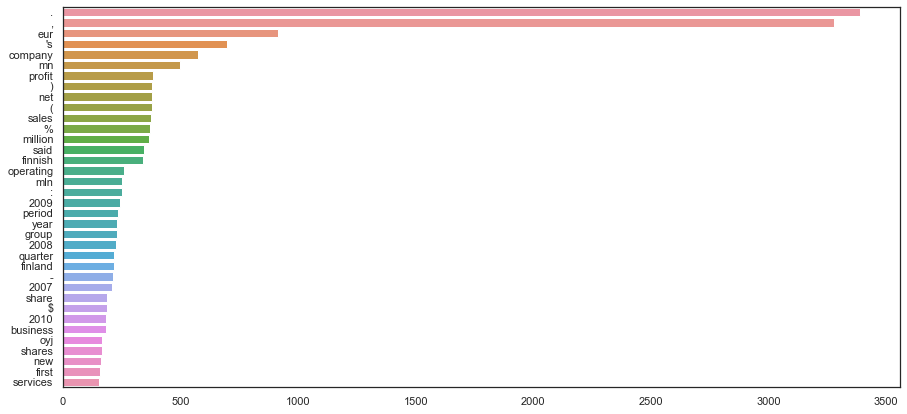

In [22]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus)
most = counter.most_common()[:60]
x, y = [], []
for word, count in most:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(15,7))
sns.barplot(x=y, y=x)

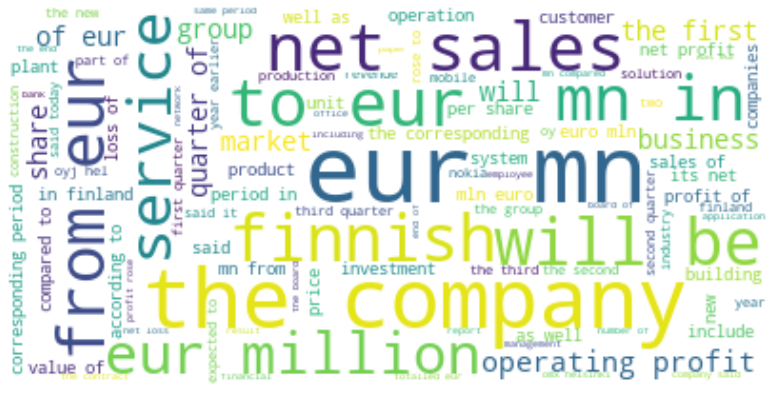

In [23]:
# Generate Word Cloud image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Create stopword list:
stopwords = set(STOPWORDS)
# stopwords.update(["federal", "federal reserve", "financial", "committee", "market", "would", "also"])

text = " ".join(corpus)

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure(figsize=(15,7))
# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)


# A. Lexicon-based Approach

## Add sentiment based on Loughran and McDonald Sentiment Word Lists

Use Loughran and McDonald Sentiment Word Lists (https://sraf.nd.edu/textual-analysis/resources/) for sentiment analysis. Use the master word list, combined in two columns (sentiment and word).
<BR /> Note: This data requires license to use for commercial application. Please check their website.

In [36]:
# Load sentiment data
sentiment_df = pd.read_csv(lmdict_dir + 'LoughranMcDonald_SentimentWordLists_2018.csv')

print(sentiment_df.shape)
sentiment_df

(4140, 2)


sentiment            word
0     Negative      ABANDON       
1     Negative      ABANDONED     
2     Negative      ABANDONING    
3     Negative      ABANDONMENT   
4     Negative      ABANDONMENTS  
...        ...               ...  
4135  Constraining  STRICTER      
4136  Constraining  STRICTEST     
4137  Constraining  STRICTLY      
4138  Constraining  UNAVAILABILITY
4139  Constraining  UNAVAILABLE   

[4140 rows x 2 columns]

In [37]:
# Make all words lower case
sentiment_df['word'] = sentiment_df['word'].str.lower()
sentiments = sentiment_df['sentiment'].unique()
sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining  184 
Litigious     904 
Negative      2355
Positive      354 
StrongModal   19  
Uncertainty   297 
WeakModal     27

In [38]:
sentiment_dict = { sentiment: sentiment_df.loc[sentiment_df['sentiment']==sentiment]['word'].values.tolist() for sentiment in sentiments}

In [121]:
result_dict = {
    "Model": ['A: Lexicon', 'B: Tfidf', 'C: LSTM', 'D: LSTM+GloVe', 'E: Bert', 'F:Albert']*2,
    "Metrics": ['Accuracy']*6 + ['F1 Score']*6,
    "Score": [0.65, 0.81, 0.83, 0.80, 0.94, 0.97] + [0.47, 0.71, 0.77, 0.75, 0.93, 0.96]
}
result_metrics = pd.DataFrame(result_dict)


## Analyze the tone with negation without lemmatization

In [39]:
# Consider Negation
negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0
    tone_score = 0

    pos_words = []
    neg_words = []
 
    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())
    word_count = len(input_words)
     
    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])
 
    if word_count > 0:
        tone_score = 100 * (pos_count - neg_count) / word_count
    else:
        tone_score = 0
    
    results = [tone_score, word_count, pos_count, neg_count, pos_words, neg_words]
 
    return results

columns = ['tone_score', 'word_count', 'n_pos_words', 'n_neg_words', 'pos_words', 'neg_words']

In [42]:
# Analyze tone for original text dataframe
print(train_df.shape)
tone_lmdict = [tone_count_with_negation_check(sentiment_dict, x.lower()) for x in tqdm(train_df['sentence'], total=train_df.shape[0])]
tone_lmdict_df = pd.DataFrame(tone_lmdict, columns=columns)
train_tone_df = pd.concat([train_df, tone_lmdict_df.reindex(train_df.index)], axis=1)
train_tone_df.head()


(3448, 2)


sentence  \
0  According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .                                                                                  
1  With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .   
2  For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .                
3  In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .                                                                                    
4  Operating profit rose to EUR 13.1 mn from EUR 8.7 mn in the corresponding period in 2007 representing 7.7 % of net sales .                                                                                       

   label  tone_score  word_count  n_pos_words  n_neg_words  \
0  1      0.000000    22          0            0             
1  2      6.250000    32          2            0             
2  2     -2.941176    34          0            1             
3  2      0.000000    19          0            0             
4  2      0.000000    18          0            0             

                  pos_words neg_words  
0  []                        []        
1  [improve, profitability]  []        
2  []                        [loss]    
3  []                        []        
4  []                        []

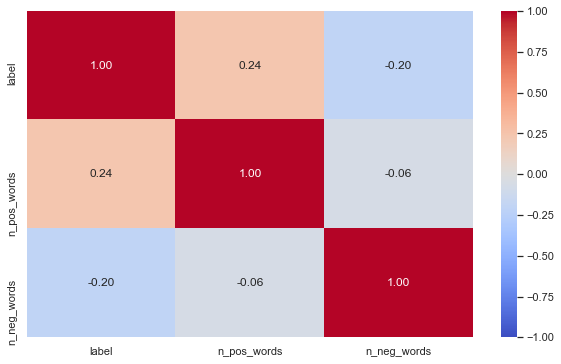

In [47]:
# Show corelations to next_decision
plt.figure(figsize=(10,6))
#corr_columns = ['label', 'tone_score', 'word_count', 'n_pos_words', 'n_neg_words']
corr_columns = ['label', 'n_pos_words', 'n_neg_words']
sns.heatmap(train_tone_df[corr_columns].astype(float).corr(), cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()

## Define common functions

### Tokenizer

In [48]:
def lemmatize_word(word):
    '''
    Return the same word after lemmatizing the input word
    '''
    wnl = nltk.stem.WordNetLemmatizer()
    return wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v')

def tokenize_df(df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK'):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    Mode:
        1: NLTK word_tokenize(), Stop words removal, Alphabet only, Lemmetize
        2: NLTK word_tokenize(), Stop words removal, Alphabet only, Do not lemmetize
        3: NLTK word_tokenize(), Do not remove stop words, Alphabet only, Do not lemmetize
        4: (alphabet + "'s" + "'t")

    '''
    tokenized = []
    for text in tqdm(df[col]):
        # Filter alphabet words only , make it loser case
        if tokenizer=='NLTK':
            words = [word.lower() for word in word_tokenize(text) if (word.isalpha()==1)]
        else:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())

        # Remove stop words
        if stopwords:
             words = [word for word in words if (word not in stop)]
        # Lemmatize words
        if lemma:
            tokens = [lemmatize_word(word) for word in words]
            tokenized.append(tokens)
        else:
            tokenized.append(words)

    # Concat the list to create docs
    tokenized_text = [" ".join(words) for words in tokenized]

    # Create a list of all the words in the dataframe
    all_words = [word for text in tokenized for word in text]

    # Counter object of all the words
    counts = Counter(all_words)

    # Create a Bag of Word, sorted by the count of words
    bow = sorted(counts, key=counts.get, reverse=True)

    # Indexing vocabrary, starting from 1.
    vocab = {word: ii for ii, word in enumerate(counts, 1)}
    id2vocab = {v: k for k, v in vocab.items()}

    # Create token id list
    token_ids = [[vocab[word] for word in text_words] for text_words in tokenized]

    return tokenized, tokenized_text, bow, vocab, id2vocab, token_ids


### Lemmatize sentiment

In [30]:
# pd.get_dummies(sentiment_df, prefix=None, dtype=bool)
# sentiment_df.columns = [column.lower() for column in sentiment_df.columns]

# Lemmertize sentiment words as well
lemma_sentiment_df = sentiment_df.copy(deep=True)
lemma_sentiment_df['word'] = [lemmatize_word(word) for word in lemma_sentiment_df['word']]
# Drop duplicates
lemma_sentiment_df = sentiment_df.drop_duplicates('word')
# Sentiment list
lemma_sentiments = list(lemma_sentiment_df['sentiment'].unique())

In [31]:
lemma_sentiment_df.groupby(by=['sentiment']).count()

word
sentiment         
Constraining   145
Litigious      750
Negative      2355
Positive       354
StrongModal     15
Uncertainty    257

### Cross validation
Use Stratified KFold because the input data is imbalanced and better to retain the same ratio for cross validation.

In [32]:
kfold = StratifiedKFold(n_splits=7)
kfold

StratifiedKFold(n_splits=7, random_state=None, shuffle=False)

### Metrics
As the data are imbalanced, use F1 score (micro) in addition to Accuracy. For cross validation, refit to F1 score.

In [33]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

### Train and visualise the result

In [49]:
def train_grid_search(estimator, param_grid, scoring, refit, cv=5, verbose=1, plot=True):
    model = GridSearchCV(estimator, param_grid=param_grid, cv=cv, scoring=scoring, verbose=verbose, 
                         refit=refit, n_jobs=-1, return_train_score=True)
    model.fit(X_train, Y_train)
    
    results = model.cv_results_
    best_estimator = model.best_estimator_
    train_scores = results['mean_train_' + refit]
    test_scores = results['mean_test_' + refit]
    train_time = results['mean_fit_time']
    
    print("Best Score: ", model.best_score_)
    print("Best Param: ", model.best_params_)
    
    pred_train = best_estimator.predict(X_train)
    pred_test = best_estimator.predict(X_test)

    acc, f1 = metric(Y_train, pred_train)
    logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
    acc, f1 = metric(Y_test, pred_test)
    logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))
        
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle("GridSearchCV Result", fontsize=20)
        
        ### First plot ###
        ax1.plot(train_scores, test_scores, 'bo')
        ax1.set_title("Train Score v.s. Test Score", fontsize=16)
        ax1.set_xlabel("Train Score")
        ax1.set_ylabel("Test Score")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.grid(True)
        
        ### Second plot ###
        x_param = list(param_grid.keys())[0]
        x_param_min = np.min(list(param_grid.values())[0])
        x_param_max = np.max(list(param_grid.values())[0])

        ax2.set_title("Score over the first param", fontsize=16)
        ax2.set_xlabel(x_param)
        ax2.set_ylabel("Score")
        ax2.set_xlim(x_param_min, x_param_max)
        ax2.set_ylim(0, 1)

        # Get the regular numpy array from the MaskedArray
        X_axis = np.array(results['param_' + x_param].data, dtype=float)

        for scorer, color in zip(sorted(scoring), ['r', 'g']):
            for sample, style in (('train', '--'), ('test', '-')):
                sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
                sample_score_std = results['std_%s_%s' % (sample, scorer)]
                ax2.fill_between(X_axis, sample_score_mean - sample_score_std,
                                sample_score_mean + sample_score_std,
                                alpha=0.1 if sample == 'test' else 0, color=color)
                ax2.plot(X_axis, sample_score_mean, style, color=color,
                        alpha=1 if sample == 'test' else 0.7,
                        label="%s (%s)" % (scorer, sample.capitalize()))

            best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
            best_score = results['mean_test_%s' % scorer][best_index]

            # Plot a dotted vertical line at the best score for that scorer marked by x
            ax2.plot([X_axis[best_index], ] * 2, [0, best_score],
                    linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

            # Annotate the best score for that scorer
            ax2.annotate("%0.2f" % best_score,
                        (X_axis[best_index], best_score + 0.005))

        ax2.legend(loc="best")
        ax2.grid(False)
        
        ### Third plot (Learning Curve) ###
        # Calculate learning curve (Accuracy)
        lc_acc_train_sizes, lc_acc_train_scores, lc_acc_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['Accuracy'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_acc_train_mean = np.mean(lc_acc_train_scores, axis=1)
        lc_acc_train_std = np.std(lc_acc_train_scores, axis=1)
        lc_acc_test_mean = np.mean(lc_acc_test_scores, axis=1)
        lc_acc_test_std = np.std(lc_acc_test_scores, axis=1)
        
        # Calculate learning curve (F1 Score)
        lc_f1_train_sizes, lc_f1_train_scores, lc_f1_test_scores = learning_curve(
            best_estimator, X_train, Y_train, cv=kfold, n_jobs=-1, scoring=scoring['F1'], 
            train_sizes=np.linspace(.1, 1.0, 5))
        lc_f1_train_mean = np.mean(lc_f1_train_scores, axis=1)
        lc_f1_train_std = np.std(lc_f1_train_scores, axis=1)
        lc_f1_test_mean = np.mean(lc_f1_test_scores, axis=1)
        lc_f1_test_std = np.std(lc_f1_test_scores, axis=1)
        
        ax3.set_title("Learning Curve", fontsize=16)
        ax3.set_xlabel("Training examples")
        ax3.set_ylabel("Score")

        # Plot learning curve (Accuracy)
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_train_mean - lc_acc_train_std,
                         lc_acc_train_mean + lc_acc_train_std, alpha=0.1, color="r")
        ax3.fill_between(lc_acc_train_sizes, 
                         lc_acc_test_mean - lc_acc_test_std,
                         lc_acc_test_mean + lc_acc_test_std, alpha=0.1, color="r")
        ax3.plot(lc_acc_train_sizes, lc_acc_train_mean, 'o--', color="r",
                 label="Accuracy (Train)")
        ax3.plot(lc_acc_train_sizes, lc_acc_test_mean, 'o-', color="r",
                 label="Accuracy (Test)")
        
        # Plot learning curve (F1 Score)
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_train_mean - lc_f1_train_std,
                         lc_f1_train_mean + lc_f1_train_std, alpha=0.1, color="g")
        ax3.fill_between(lc_f1_train_sizes, 
                         lc_f1_test_mean - lc_f1_test_std,
                         lc_f1_test_mean + lc_f1_test_std, alpha=0.1, color="g")
        ax3.plot(lc_f1_train_sizes, lc_f1_train_mean, 'o--', color="g",
                 label="F1 (Train)")
        ax3.plot(lc_f1_train_sizes, lc_f1_test_mean, 'o-', color="g",
                 label="F1 (Test)")

        ax3.legend(loc="best")
        ax3.grid(True)
        
        plt.tight_layout(pad=3.0)
        plt.show()
        
        ### Confusion Matrix ###
        class_names = ['Lower', 'Hold', 'Raise']
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle("Confusion Matrix", fontsize=20)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax1)
        ax1.set_title("Train Data: Actual Count")
        ax1.grid(False)
        
        plot_confusion_matrix(best_estimator, X_train, Y_train, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax2)
        ax2.set_title=("Train Data: Normalized")
        ax2.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize=None, ax=ax3)
        ax3.set_title=("Test Data: Actual Count")
        ax3.grid(False)
        
        plot_confusion_matrix(best_estimator, X_test, Y_test, display_labels=class_names, 
                              cmap=plt.cm.Blues, normalize='all', ax=ax4)
        ax4.set_title("Test Data: Normalized")
        ax4.grid(False)
        
        plt.tight_layout(pad=3.0)
        plt.show()
    
    return model


In [35]:
train_tone_df.columns

Index(['sentence', 'label', 'tone_score', 'word_count', 'n_pos_words',
       'n_neg_words', 'pos_words', 'neg_words'],
      dtype='object')

In [50]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = train_tone_df[['tone_score', 'n_pos_words', 'n_neg_words']]

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data.values, Y_data.values, test_size=0.2, shuffle=True)

## Train the model
Use Random Forest Classifier with grid search cross validation

Fitting 7 folds for each of 480 candidates, totalling 3360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 3360 out of 3360 | elapsed:  2.1min finished
[2020-07-19 07:21:36,844][INFO] ## Training - acc: 0.67657723, f1: 0.52026970
[2020-07-19 07:21:36,847][INFO] ## Test - acc: 0.65362319, f1: 0.46832904


Best Score:  0.49014150279916385
Best Param:  {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 1}


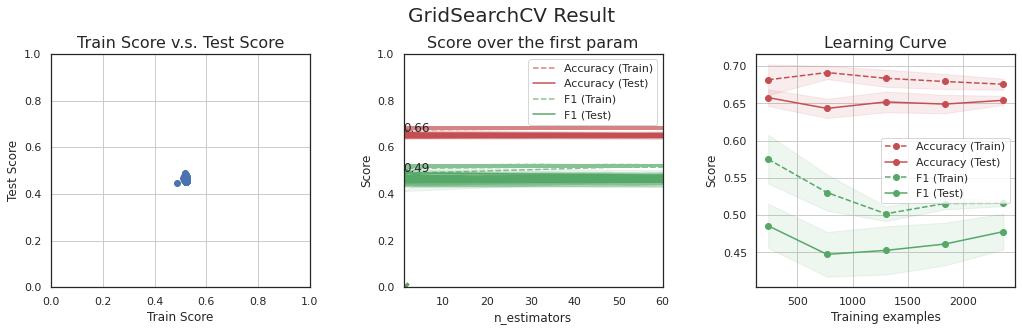

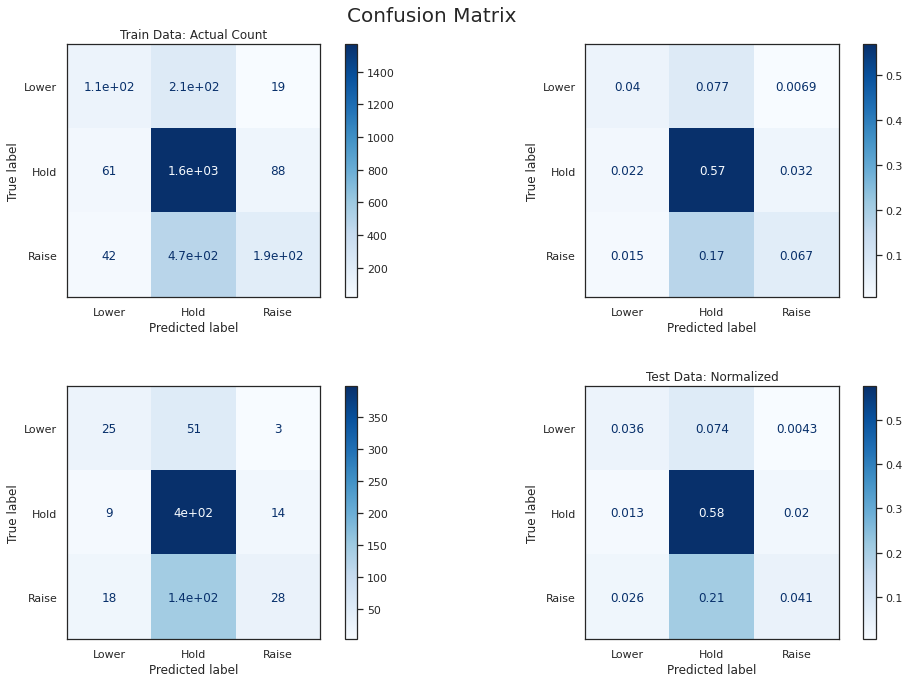

In [37]:
# Random Forest
rf_clf = RandomForestClassifier()

# Perform Grid Search
param_grid = {'n_estimators': np.linspace(1, 60, 10, dtype=int),
              'min_samples_split': [1, 3, 5, 10],
              'min_samples_leaf': [1, 2, 3, 5],
              'max_features': [1, 2, 3],
              'max_depth': [None],
              'criterion': ['gini'],
              'bootstrap': [False]}

rf_model = train_grid_search(rf_clf, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)
rf_best = rf_model.best_estimator_

## Result
The prediction is not good at all with Accuracy of 0.65 and F1 score of 0.47. Confusion matrix shows almost all the data have been labeled as "neutral", the majority class.

Text(0.5, 1.0, 'Feature importance')

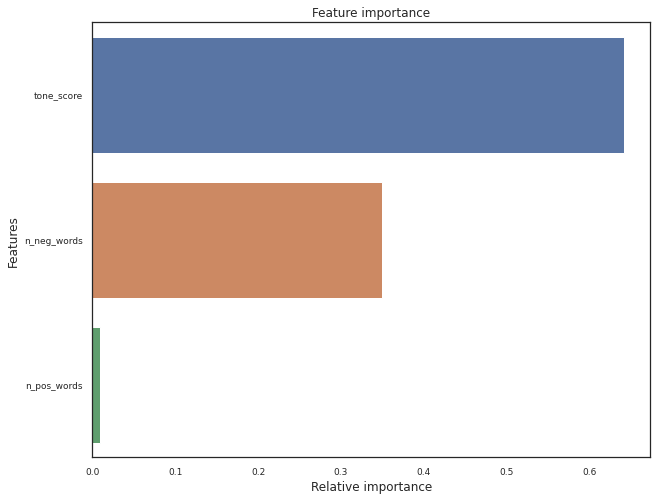

In [38]:
# Feature Importance
fig, ax = plt.subplots(figsize=(10,8))

indices = np.argsort(rf_best.feature_importances_)[::-1][:40]
g = sns.barplot(y=X_data.columns[indices][:40], x=rf_best.feature_importances_[indices][:40] , orient='h', ax=ax)
g.set_xlabel("Relative importance", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title("Feature importance")


# B. Tfidf
### Tokenise input texts

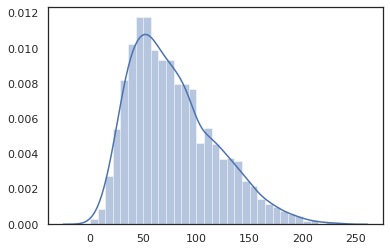

In [40]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=True, stopwords=True, tokenizer='NLTK')
sns.distplot([len(x) for x in tokenized_text])


In [41]:
# X and Y data used
Y_data = train_tone_df['label']
X_data = tokenized_text

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_test, Y_train, Y_test = \
model_selection.train_test_split(X_data, Y_data.values, test_size=0.2, shuffle=True)

## Model and Train (Logistic Regression)


In [42]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', LogisticRegression())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-19 07:21:42,555][INFO] ## Training - acc: 0.87635968, f1: 0.81886038
[2020-07-19 07:21:42,562][INFO] ## Test - acc: 0.81594203, f1: 0.70027112


## Model and Train (Random Forest)

In [43]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

pipeline.fit(X_train, Y_train)

pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

acc, f1 = metric(Y_train, pred_train)
logger.info('Training - acc: %.8f, f1: %.8f' % (acc, f1))
acc, f1 = metric(Y_test, pred_test)
logger.info('Test - acc: %.8f, f1: %.8f' % (acc, f1))

[2020-07-19 07:21:44,382][INFO] ## Training - acc: 0.99709935, f1: 0.99450311
[2020-07-19 07:21:44,388][INFO] ## Test - acc: 0.82173913, f1: 0.71260943


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 7 folds for each of 20 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  1.8min finished


Best Score:  0.7258020381381959
Best Param:  {'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 6, 'clf__n_estimators': 100}


[2020-07-19 07:23:31,311][INFO] ## Training - acc: 0.99419869, f1: 0.99155507
[2020-07-19 07:23:31,316][INFO] ## Test - acc: 0.81884058, f1: 0.71338792


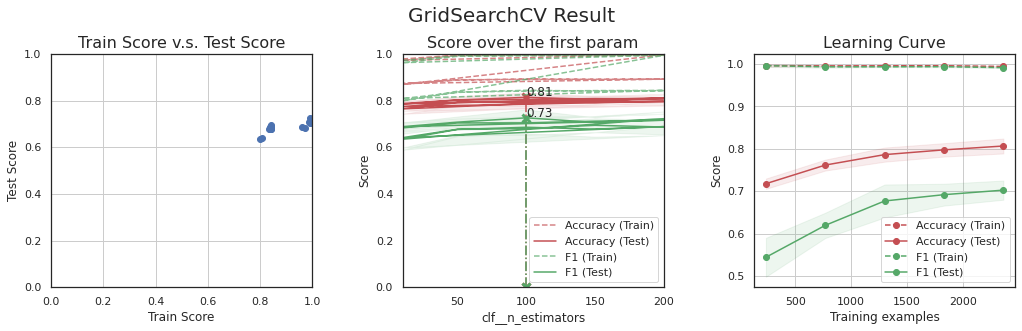

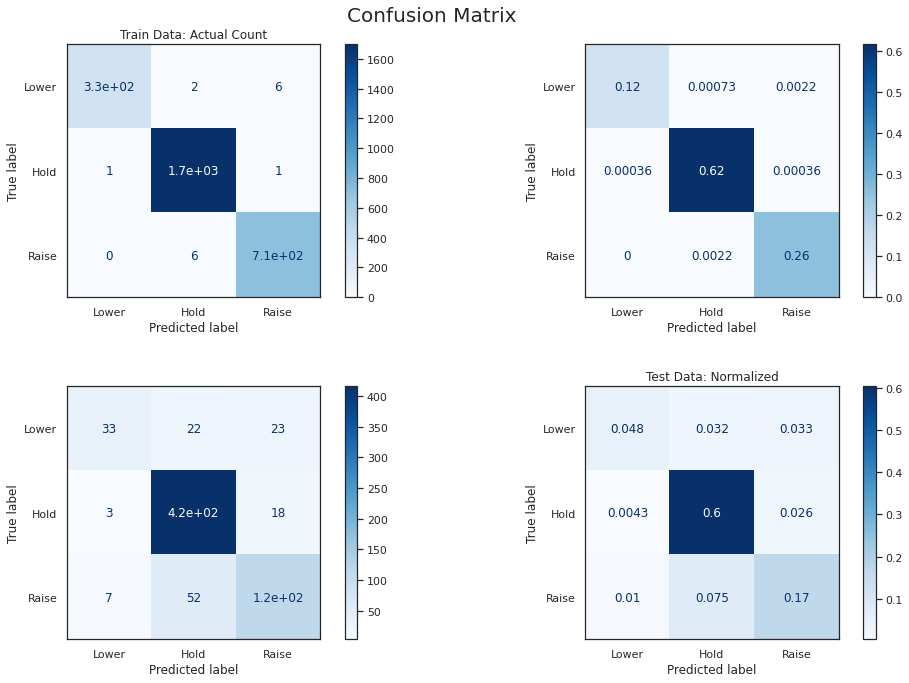

In [44]:
pipeline = Pipeline([
    ('vec', TfidfVectorizer(analyzer='word')),
    ('clf', RandomForestClassifier())])

# Perform Grid Search
param_grid = {'clf__n_estimators': [10, 50, 100, 150, 200],
              'clf__min_samples_leaf': [1, 2],
              'clf__min_samples_split': [4, 6],
              'clf__max_features': ['auto']
             }

model = train_grid_search(pipeline, param_grid, scoring, refit, cv=kfold, verbose=1, plot=True)

Much better than lexicon approach but still accuracy of 0.81 and F1 score of 0.71. Apparently it overfitting to the training set.

# C. LSTM (RNN)
Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

All recurrent neural networks have the form of a chain of repeating modules of neural network. In standard RNNs, this repeating module will have a very simple structure, such as a single tanh layer.

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

<table><tr><td><img src="./docs/lstm_4.png" width=450></td><td><img src="./docs/lstm_1.png" width=300></td></tr></table>


### Tokenise input texts

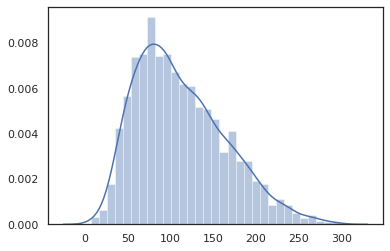

In [45]:
# Tokenize
tokenized, tokenized_text, bow, vocab, id2vocab, token_ids = tokenize_df(train_tone_df, col='sentence', lemma=False, stopwords=False, tokenizer='Own')
sns.distplot([len(x) for x in tokenized_text])


In [46]:
# # Split data into training and validation datasets. Use an appropriate split size.

# split_frac = 0.8

# split_idx = int(len(token_ids)*split_frac)

# train_features = token_ids[:split_idx]
# valid_features = token_ids[split_idx:]
# train_labels = Y_data[:split_idx]
# valid_labels = Y_data[split_idx:]

# print("len(token_ids): ", len(token_ids))
# print("len(train_features): ", len(train_features))
# print("len(valid_features): ", len(valid_features))
# print("len(train_labels): ", len(train_labels))
# print("len(valid_labels): ", len(valid_labels))

# X and Y data used
y_data = train_tone_df['label']
X_data = token_ids

# Train test split (Shuffle=False will make the test data for the most recent ones)
X_train, X_valid, y_train, y_valid = \
model_selection.train_test_split(X_data, y_data.values, test_size=0.2, shuffle=True)

### Define Model
#### Embed -> RNN -> Dense -> Softmax

In [47]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, dense_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(lstm_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """

        weight = next(self.parameters()).data
        # print('initial weight size: ', weight.shape)
        # print('initial weight: ', weight)
        # print('initial weight new: ', weight.new(self.lstm_layers, batch_size, self.lstm_size))

        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        dense_out = self.fc1(lstm_out)
        out = self.fc2(dense_out)
        logps = self.softmax(out)

        return logps, hidden_state

### DataLoaders and Batching

can use keras functions but let's do it from scratch

In [48]:
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences

# MAX_LEN = 100
# tokenizer_obj = Tokenizer()
# tokenizer_obj.fit_on_texts(balanced['texts'])
# sequences = tokenizer_obj.texts_to_sequences(balanced['texts'])

# text_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')
# text_pad

In [49]:
def dataloader(messages, labels, sequence_length=200, batch_size=16, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

In [50]:
# Test
text_batch, labels = next(iter(dataloader(X_train, y_train)))
model = TextClassifier(len(vocab), 512, 128, 8, 3)
hidden = model.init_hidden(16)
logps, hidden = model.forward(text_batch, hidden)
print(logps)

tensor([[-1.2498, -0.9441, -1.1257],
        [-1.3751, -0.7182, -1.3489],
        [-1.0054, -1.0949, -1.2055],
        [-1.1811, -0.8987, -1.2520],
        [-1.2171, -0.8897, -1.2272],
        [-1.3077, -0.7703, -1.3217],
        [-1.3167, -0.8881, -1.1378],
        [-1.3999, -0.7413, -1.2841],
        [-1.3553, -0.8709, -1.1285],
        [-1.3557, -0.7777, -1.2630],
        [-1.3395, -0.8024, -1.2387],
        [-1.2623, -0.9044, -1.1641],
        [-1.2392, -0.8997, -1.1917],
        [-1.5262, -0.6605, -1.3241],
        [-1.1678, -0.8816, -1.2916],
        [-1.2282, -0.8729, -1.2398]], grad_fn=<LogSoftmaxBackward>)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Configure the model and train!

In [51]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextClassifier(len(vocab)+1, 512, 128, 8, 3, lstm_layers=2, dropout=0.2)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(7136, 512)
  (lstm): LSTM(512, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

In [52]:
def train_model(model, epochs=30, batch_size=32, learning_rate=1e-4, sequence_length=200, clip=5, print_every=10):
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    for epoch in range(epochs):
        print('Starting epoch {}'.format(epoch + 1))
        hidden = model.init_hidden(batch_size)
        steps = 0
        y_valid_epoch = []
        predicted_valid_epoch = []

        for text_batch, labels in dataloader(
                X_train, y_train, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):
            steps += 1
            # Skip the last batch of which size is not equal to batch_size
            if text_batch.size(1) != batch_size:
                break

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
        
            # Set Device
            text_batch, labels = text_batch.to(device), labels.to(device)
            for each in hidden:
                each.to(device)
        
            # optimizer.zero_grad()
            model.zero_grad()
        
            # Get output and hidden state from the model
            output, hidden = model(text_batch, hidden)

            # Calculate the loss and perform backprop
            loss = criterion(output, labels)
            loss.backward()

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Optimize
            optimizer.step()

            if steps % print_every == 0:
                model.eval()

                valid_losses = []
                accuracy = []
                predicted_valid = []
                y_valid_batch = []
                valid_hidden = model.init_hidden(batch_size)

                for text_batch, labels in dataloader(
                        X_valid, y_valid, batch_size=batch_size, sequence_length=sequence_length, shuffle=False):

                    # Skip the last batch of which size is not equal to batch_size
                    if text_batch.size(1) != batch_size:
                        break

                    # Initialize within the loop to use label shape because batch_size did not work
                    # valid_hidden = model.init_hidden(labels.shape[0])

                    # Creating new variables for the hidden state
                    valid_hidden = tuple([each.data for each in valid_hidden])

                    # Set Device
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    for each in valid_hidden:
                        each.to(device)

                    # Get output and hidden state from the model
                    valid_output, valid_hidden = model(text_batch, valid_hidden)

                    # Calculate the loss     
                    valid_loss = criterion(valid_output.squeeze(), labels)
                    valid_losses.append(valid_loss.item())

                    # Accuracy
                    ps = torch.exp(valid_output)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())

                    predicted_valid.extend(top_class.squeeze().cpu().numpy())
                    y_valid_batch.extend(labels.view(*top_class.shape).squeeze().cpu().numpy())

                model.train()
                acc, f1 = metric(y_valid_batch, predicted_valid)
                predicted_valid_epoch.extend(predicted_valid)
                y_valid_epoch.extend(y_valid_batch)

                print("Epoch: {}/{}...".format(epoch+1, epochs),
                      "Step: {}...".format(steps),
                      "Loss: {:.6f}...".format(loss.item()),
                      "Val Loss: {:.6f}".format(np.mean(valid_losses)),
                      "Accuracy: {:.6f}".format(acc),
                      "F1 Score: {:.6f}".format(f1))
        print("{} steps in epoch {}".format(steps, epoch+1))
        class_names = ['Negative', 'Neutral', 'Positive']
        y_valid_class = [class_names[int(idx)] for idx in y_valid_batch]
        predicted_valid_class = [class_names[int(idx)] for idx in predicted_valid]
        titles_options = [("Confusion matrix, without normalization", None), ("Confusion matrix, with normalization", 'true')]
        for title, normalize in titles_options:
            disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
        acc, f1 = metric(y_valid_class, predicted_valid_class)
        print("\nEpoch: %d, Average Accuracy: %.8f, Average f1: %.8f\n" % (epoch+1, acc, f1))
        plt.show()

Starting epoch 1
Epoch: 1/30... Step: 10... Loss: 1.035171... Val Loss: 1.056911 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 20... Loss: 1.032194... Val Loss: 1.047556 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 30... Loss: 1.031956... Val Loss: 1.037681 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 40... Loss: 0.934062... Val Loss: 1.026368 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 50... Loss: 0.996336... Val Loss: 1.011307 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 60... Loss: 0.945395... Val Loss: 0.989126 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 70... Loss: 0.964704... Val Loss: 0.961041 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 80... Loss: 0.937765... Val Loss: 0.919391 Accuracy: 0.625000 F1 Score: 0.256410
87 steps in epoch 1

Epoch: 1, Average Accuracy: 0.62500000, Average f1: 0.25641026



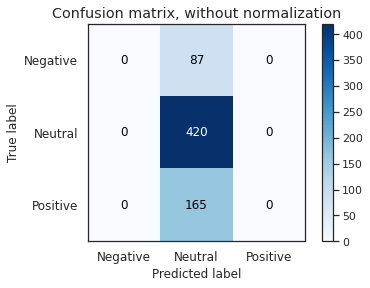

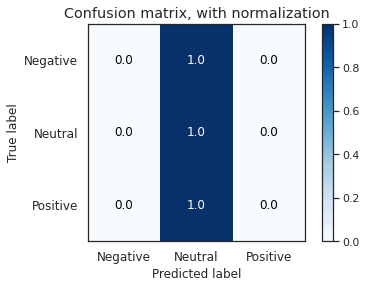

Starting epoch 2
Epoch: 2/30... Step: 10... Loss: 0.825863... Val Loss: 0.893015 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 2/30... Step: 20... Loss: 0.831557... Val Loss: 0.879797 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 2/30... Step: 30... Loss: 0.890267... Val Loss: 0.852237 Accuracy: 0.625000 F1 Score: 0.256645
Epoch: 2/30... Step: 40... Loss: 0.684631... Val Loss: 0.833050 Accuracy: 0.626488 F1 Score: 0.264524
Epoch: 2/30... Step: 50... Loss: 0.822326... Val Loss: 0.819277 Accuracy: 0.629464 F1 Score: 0.279332
Epoch: 2/30... Step: 60... Loss: 0.738588... Val Loss: 0.805990 Accuracy: 0.633929 F1 Score: 0.299197
Epoch: 2/30... Step: 70... Loss: 0.723588... Val Loss: 0.791726 Accuracy: 0.642857 F1 Score: 0.332371
Epoch: 2/30... Step: 80... Loss: 0.781098... Val Loss: 0.778044 Accuracy: 0.644345 F1 Score: 0.335612
87 steps in epoch 2

Epoch: 2, Average Accuracy: 0.64434524, Average f1: 0.33561222



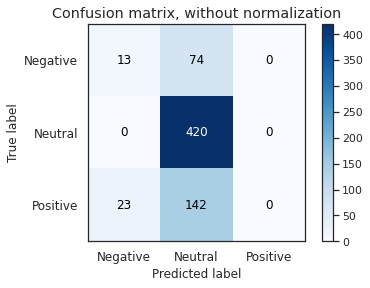

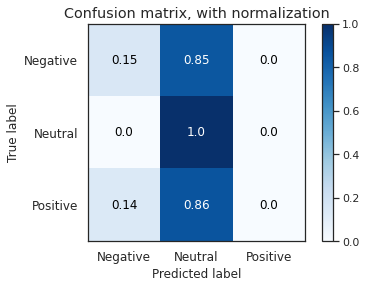

Starting epoch 3
Epoch: 3/30... Step: 10... Loss: 0.657246... Val Loss: 0.761236 Accuracy: 0.656250 F1 Score: 0.373488
Epoch: 3/30... Step: 20... Loss: 0.642902... Val Loss: 0.755217 Accuracy: 0.666667 F1 Score: 0.399150
Epoch: 3/30... Step: 30... Loss: 0.771863... Val Loss: 0.738828 Accuracy: 0.674107 F1 Score: 0.428528
Epoch: 3/30... Step: 40... Loss: 0.608202... Val Loss: 0.735866 Accuracy: 0.681548 F1 Score: 0.432623
Epoch: 3/30... Step: 50... Loss: 0.702426... Val Loss: 0.719630 Accuracy: 0.684524 F1 Score: 0.442634
Epoch: 3/30... Step: 60... Loss: 0.692307... Val Loss: 0.714010 Accuracy: 0.694940 F1 Score: 0.447117
Epoch: 3/30... Step: 70... Loss: 0.566315... Val Loss: 0.708793 Accuracy: 0.693452 F1 Score: 0.438676
Epoch: 3/30... Step: 80... Loss: 0.637974... Val Loss: 0.696124 Accuracy: 0.696429 F1 Score: 0.455866
87 steps in epoch 3

Epoch: 3, Average Accuracy: 0.69642857, Average f1: 0.45586626



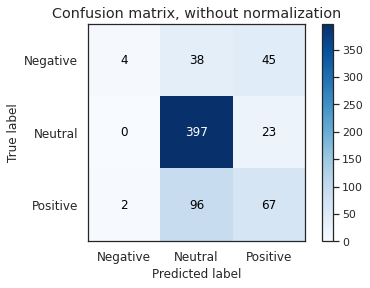

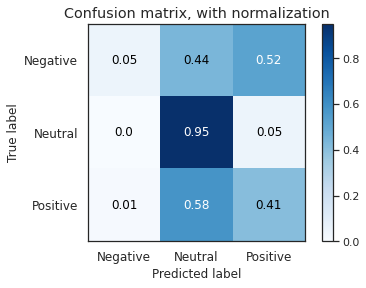

Starting epoch 4
Epoch: 4/30... Step: 10... Loss: 0.556373... Val Loss: 0.689234 Accuracy: 0.697917 F1 Score: 0.435768
Epoch: 4/30... Step: 20... Loss: 0.487615... Val Loss: 0.684716 Accuracy: 0.697917 F1 Score: 0.440697
Epoch: 4/30... Step: 30... Loss: 0.713488... Val Loss: 0.674189 Accuracy: 0.715774 F1 Score: 0.466237
Epoch: 4/30... Step: 40... Loss: 0.554386... Val Loss: 0.675585 Accuracy: 0.712798 F1 Score: 0.454420
Epoch: 4/30... Step: 50... Loss: 0.612624... Val Loss: 0.666498 Accuracy: 0.712798 F1 Score: 0.472730
Epoch: 4/30... Step: 60... Loss: 0.636385... Val Loss: 0.659332 Accuracy: 0.717262 F1 Score: 0.475832
Epoch: 4/30... Step: 70... Loss: 0.479581... Val Loss: 0.654455 Accuracy: 0.723214 F1 Score: 0.493895
Epoch: 4/30... Step: 80... Loss: 0.487547... Val Loss: 0.643034 Accuracy: 0.721726 F1 Score: 0.511842
87 steps in epoch 4

Epoch: 4, Average Accuracy: 0.72172619, Average f1: 0.51184248



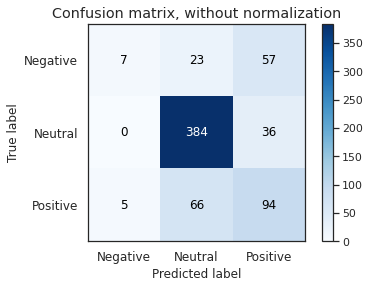

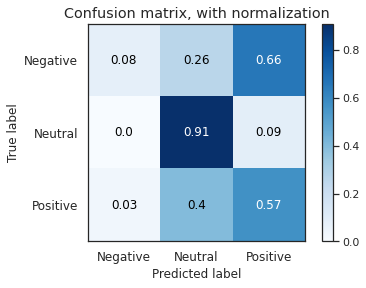

Starting epoch 5
Epoch: 5/30... Step: 10... Loss: 0.420030... Val Loss: 0.641891 Accuracy: 0.726190 F1 Score: 0.495111
Epoch: 5/30... Step: 20... Loss: 0.373352... Val Loss: 0.633302 Accuracy: 0.733631 F1 Score: 0.525415
Epoch: 5/30... Step: 30... Loss: 0.643933... Val Loss: 0.638037 Accuracy: 0.729167 F1 Score: 0.507422
Epoch: 5/30... Step: 40... Loss: 0.592973... Val Loss: 0.630237 Accuracy: 0.727679 F1 Score: 0.523845
Epoch: 5/30... Step: 50... Loss: 0.497531... Val Loss: 0.626834 Accuracy: 0.736607 F1 Score: 0.544983
Epoch: 5/30... Step: 60... Loss: 0.582692... Val Loss: 0.621736 Accuracy: 0.744048 F1 Score: 0.557470
Epoch: 5/30... Step: 70... Loss: 0.440270... Val Loss: 0.615738 Accuracy: 0.752976 F1 Score: 0.584760
Epoch: 5/30... Step: 80... Loss: 0.360316... Val Loss: 0.607020 Accuracy: 0.755952 F1 Score: 0.593278
87 steps in epoch 5

Epoch: 5, Average Accuracy: 0.75595238, Average f1: 0.59327802



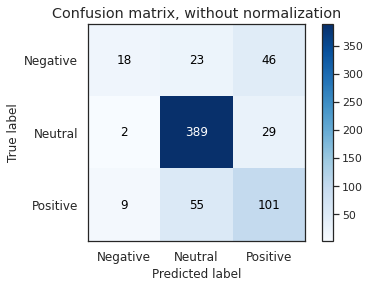

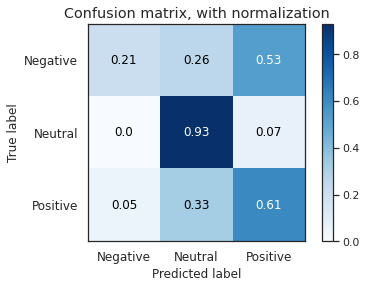

Starting epoch 6
Epoch: 6/30... Step: 10... Loss: 0.335738... Val Loss: 0.607198 Accuracy: 0.752976 F1 Score: 0.561981
Epoch: 6/30... Step: 20... Loss: 0.273395... Val Loss: 0.599283 Accuracy: 0.752976 F1 Score: 0.576928
Epoch: 6/30... Step: 30... Loss: 0.583686... Val Loss: 0.612200 Accuracy: 0.757440 F1 Score: 0.574966
Epoch: 6/30... Step: 40... Loss: 0.563944... Val Loss: 0.607725 Accuracy: 0.747024 F1 Score: 0.582870
Epoch: 6/30... Step: 50... Loss: 0.394754... Val Loss: 0.594775 Accuracy: 0.752976 F1 Score: 0.596451
Epoch: 6/30... Step: 60... Loss: 0.515761... Val Loss: 0.594429 Accuracy: 0.760417 F1 Score: 0.607234
Epoch: 6/30... Step: 70... Loss: 0.388710... Val Loss: 0.592305 Accuracy: 0.772321 F1 Score: 0.628409
Epoch: 6/30... Step: 80... Loss: 0.284831... Val Loss: 0.588949 Accuracy: 0.763393 F1 Score: 0.624493
87 steps in epoch 6

Epoch: 6, Average Accuracy: 0.76339286, Average f1: 0.62449340



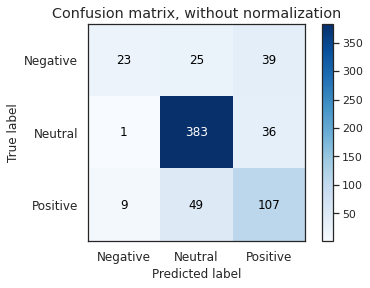

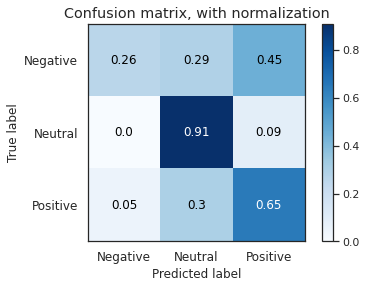

Starting epoch 7
Epoch: 7/30... Step: 10... Loss: 0.221368... Val Loss: 0.602937 Accuracy: 0.772321 F1 Score: 0.619238
Epoch: 7/30... Step: 20... Loss: 0.197195... Val Loss: 0.589410 Accuracy: 0.766369 F1 Score: 0.634848
Epoch: 7/30... Step: 30... Loss: 0.432349... Val Loss: 0.591014 Accuracy: 0.778274 F1 Score: 0.630388
Epoch: 7/30... Step: 40... Loss: 0.450081... Val Loss: 0.581983 Accuracy: 0.770833 F1 Score: 0.642084
Epoch: 7/30... Step: 50... Loss: 0.328328... Val Loss: 0.573891 Accuracy: 0.775298 F1 Score: 0.650311
Epoch: 7/30... Step: 60... Loss: 0.475541... Val Loss: 0.580265 Accuracy: 0.787202 F1 Score: 0.657140
Epoch: 7/30... Step: 70... Loss: 0.352117... Val Loss: 0.572734 Accuracy: 0.797619 F1 Score: 0.707130
Epoch: 7/30... Step: 80... Loss: 0.203684... Val Loss: 0.576788 Accuracy: 0.791667 F1 Score: 0.693593
87 steps in epoch 7

Epoch: 7, Average Accuracy: 0.79166667, Average f1: 0.69359339



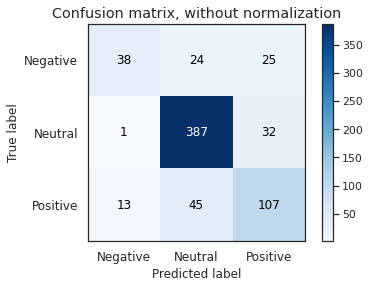

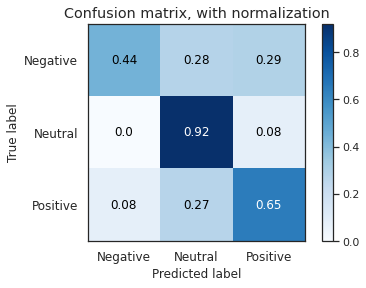

Starting epoch 8
Epoch: 8/30... Step: 10... Loss: 0.164847... Val Loss: 0.604901 Accuracy: 0.779762 F1 Score: 0.671693
Epoch: 8/30... Step: 20... Loss: 0.221305... Val Loss: 0.623751 Accuracy: 0.788690 F1 Score: 0.670326
Epoch: 8/30... Step: 30... Loss: 0.342216... Val Loss: 0.615951 Accuracy: 0.778274 F1 Score: 0.694309
Epoch: 8/30... Step: 40... Loss: 0.386981... Val Loss: 0.641030 Accuracy: 0.794643 F1 Score: 0.680780
Epoch: 8/30... Step: 50... Loss: 0.333924... Val Loss: 0.614141 Accuracy: 0.754464 F1 Score: 0.689609
Epoch: 8/30... Step: 60... Loss: 0.442891... Val Loss: 0.580296 Accuracy: 0.800595 F1 Score: 0.703180
Epoch: 8/30... Step: 70... Loss: 0.298139... Val Loss: 0.569327 Accuracy: 0.803571 F1 Score: 0.722497
Epoch: 8/30... Step: 80... Loss: 0.170487... Val Loss: 0.581855 Accuracy: 0.803571 F1 Score: 0.716165
87 steps in epoch 8

Epoch: 8, Average Accuracy: 0.80357143, Average f1: 0.71616483



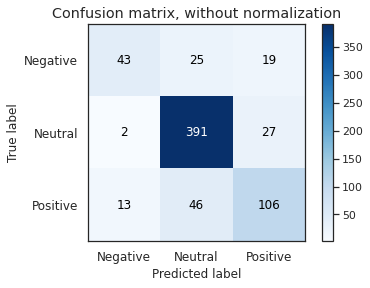

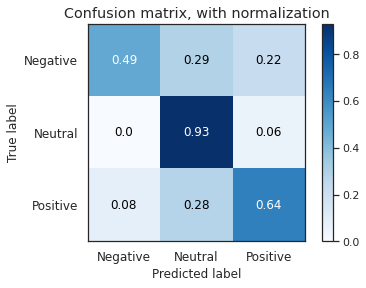

Starting epoch 9
Epoch: 9/30... Step: 10... Loss: 0.131824... Val Loss: 0.610959 Accuracy: 0.794643 F1 Score: 0.714474
Epoch: 9/30... Step: 20... Loss: 0.140671... Val Loss: 0.657317 Accuracy: 0.799107 F1 Score: 0.693827
Epoch: 9/30... Step: 30... Loss: 0.262633... Val Loss: 0.651559 Accuracy: 0.770833 F1 Score: 0.708676
Epoch: 9/30... Step: 40... Loss: 0.384489... Val Loss: 0.657649 Accuracy: 0.796131 F1 Score: 0.694187
Epoch: 9/30... Step: 50... Loss: 0.283726... Val Loss: 0.580599 Accuracy: 0.784226 F1 Score: 0.715247
Epoch: 9/30... Step: 60... Loss: 0.489144... Val Loss: 0.579544 Accuracy: 0.799107 F1 Score: 0.722436
Epoch: 9/30... Step: 70... Loss: 0.256899... Val Loss: 0.595390 Accuracy: 0.811012 F1 Score: 0.720085
Epoch: 9/30... Step: 80... Loss: 0.188198... Val Loss: 0.567163 Accuracy: 0.808036 F1 Score: 0.739332
87 steps in epoch 9

Epoch: 9, Average Accuracy: 0.80803571, Average f1: 0.73933152



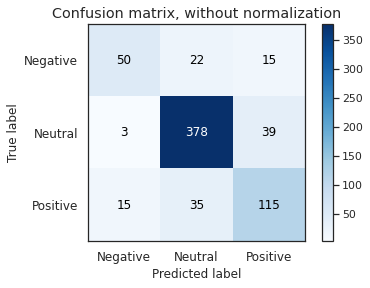

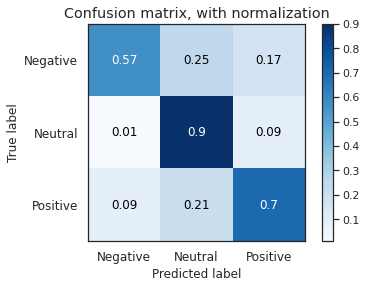

Starting epoch 10
Epoch: 10/30... Step: 10... Loss: 0.071383... Val Loss: 0.617585 Accuracy: 0.793155 F1 Score: 0.717720
Epoch: 10/30... Step: 20... Loss: 0.083966... Val Loss: 0.663843 Accuracy: 0.799107 F1 Score: 0.696489
Epoch: 10/30... Step: 30... Loss: 0.205079... Val Loss: 0.661679 Accuracy: 0.791667 F1 Score: 0.729070
Epoch: 10/30... Step: 40... Loss: 0.338924... Val Loss: 0.650547 Accuracy: 0.805060 F1 Score: 0.717820
Epoch: 10/30... Step: 50... Loss: 0.262679... Val Loss: 0.613402 Accuracy: 0.816964 F1 Score: 0.741283
Epoch: 10/30... Step: 60... Loss: 0.369554... Val Loss: 0.705128 Accuracy: 0.767857 F1 Score: 0.720631
Epoch: 10/30... Step: 70... Loss: 0.167053... Val Loss: 0.613098 Accuracy: 0.815476 F1 Score: 0.730872
Epoch: 10/30... Step: 80... Loss: 0.160796... Val Loss: 0.580504 Accuracy: 0.806548 F1 Score: 0.725144
87 steps in epoch 10

Epoch: 10, Average Accuracy: 0.80654762, Average f1: 0.72514380



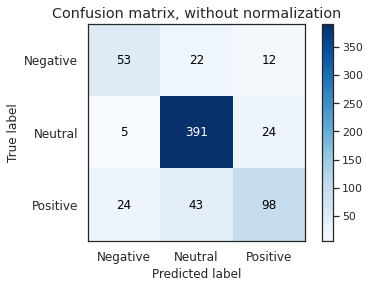

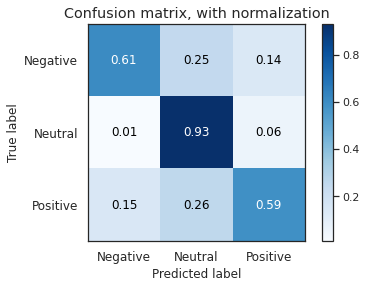

Starting epoch 11
Epoch: 11/30... Step: 10... Loss: 0.060767... Val Loss: 0.639771 Accuracy: 0.797619 F1 Score: 0.724473
Epoch: 11/30... Step: 20... Loss: 0.070320... Val Loss: 0.689466 Accuracy: 0.805060 F1 Score: 0.713091
Epoch: 11/30... Step: 30... Loss: 0.241256... Val Loss: 0.669926 Accuracy: 0.813988 F1 Score: 0.736708
Epoch: 11/30... Step: 40... Loss: 0.318338... Val Loss: 0.627023 Accuracy: 0.805060 F1 Score: 0.727556
Epoch: 11/30... Step: 50... Loss: 0.195416... Val Loss: 0.702333 Accuracy: 0.808036 F1 Score: 0.714137
Epoch: 11/30... Step: 60... Loss: 0.329630... Val Loss: 0.872627 Accuracy: 0.712798 F1 Score: 0.684963
Epoch: 11/30... Step: 70... Loss: 0.140576... Val Loss: 0.642169 Accuracy: 0.819940 F1 Score: 0.738675
Epoch: 11/30... Step: 80... Loss: 0.134172... Val Loss: 0.587293 Accuracy: 0.813988 F1 Score: 0.739289
87 steps in epoch 11

Epoch: 11, Average Accuracy: 0.81398810, Average f1: 0.73928912



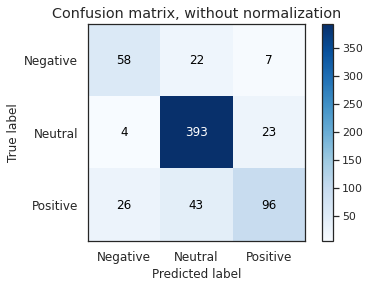

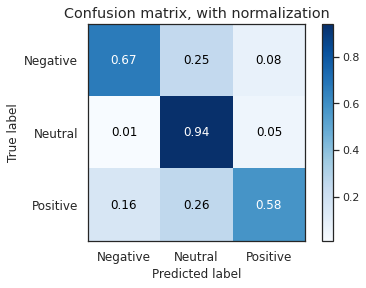

Starting epoch 12
Epoch: 12/30... Step: 10... Loss: 0.067336... Val Loss: 0.619809 Accuracy: 0.802083 F1 Score: 0.743247
Epoch: 12/30... Step: 20... Loss: 0.077201... Val Loss: 0.701368 Accuracy: 0.813988 F1 Score: 0.722933
Epoch: 12/30... Step: 30... Loss: 0.146555... Val Loss: 0.677811 Accuracy: 0.812500 F1 Score: 0.733132
Epoch: 12/30... Step: 40... Loss: 0.282556... Val Loss: 0.638363 Accuracy: 0.815476 F1 Score: 0.748925
Epoch: 12/30... Step: 50... Loss: 0.209511... Val Loss: 0.668679 Accuracy: 0.816964 F1 Score: 0.739987
Epoch: 12/30... Step: 60... Loss: 0.156101... Val Loss: 0.682443 Accuracy: 0.803571 F1 Score: 0.738029
Epoch: 12/30... Step: 70... Loss: 0.112385... Val Loss: 0.655215 Accuracy: 0.796131 F1 Score: 0.731479
Epoch: 12/30... Step: 80... Loss: 0.111682... Val Loss: 0.702926 Accuracy: 0.819940 F1 Score: 0.734423
87 steps in epoch 12

Epoch: 12, Average Accuracy: 0.81994048, Average f1: 0.73442303



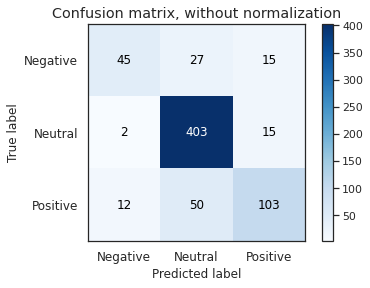

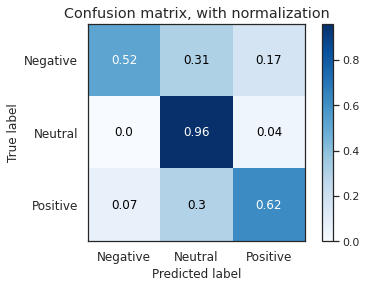

Starting epoch 13
Epoch: 13/30... Step: 10... Loss: 0.053669... Val Loss: 0.652949 Accuracy: 0.790179 F1 Score: 0.734949
Epoch: 13/30... Step: 20... Loss: 0.033809... Val Loss: 0.713202 Accuracy: 0.825893 F1 Score: 0.743940
Epoch: 13/30... Step: 30... Loss: 0.114612... Val Loss: 0.683380 Accuracy: 0.799107 F1 Score: 0.726067
Epoch: 13/30... Step: 40... Loss: 0.235905... Val Loss: 0.660194 Accuracy: 0.803571 F1 Score: 0.738151
Epoch: 13/30... Step: 50... Loss: 0.235397... Val Loss: 0.677090 Accuracy: 0.822917 F1 Score: 0.750950
Epoch: 13/30... Step: 60... Loss: 0.199347... Val Loss: 0.719197 Accuracy: 0.816964 F1 Score: 0.742055
Epoch: 13/30... Step: 70... Loss: 0.120720... Val Loss: 0.726747 Accuracy: 0.772321 F1 Score: 0.722935
Epoch: 13/30... Step: 80... Loss: 0.035687... Val Loss: 0.722642 Accuracy: 0.821429 F1 Score: 0.742374
87 steps in epoch 13

Epoch: 13, Average Accuracy: 0.82142857, Average f1: 0.74237413



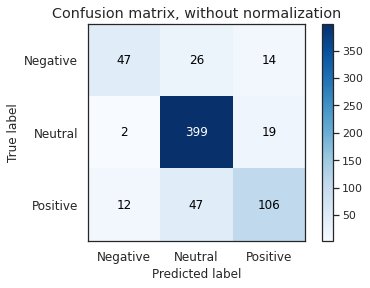

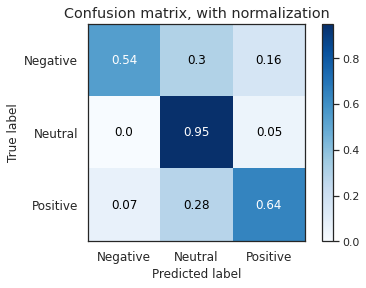

Starting epoch 14
Epoch: 14/30... Step: 10... Loss: 0.050021... Val Loss: 0.736638 Accuracy: 0.758929 F1 Score: 0.710622
Epoch: 14/30... Step: 20... Loss: 0.037728... Val Loss: 0.713759 Accuracy: 0.822917 F1 Score: 0.753866
Epoch: 14/30... Step: 30... Loss: 0.154042... Val Loss: 0.722793 Accuracy: 0.813988 F1 Score: 0.742400
Epoch: 14/30... Step: 40... Loss: 0.154470... Val Loss: 0.710990 Accuracy: 0.779762 F1 Score: 0.727452
Epoch: 14/30... Step: 50... Loss: 0.177253... Val Loss: 0.711815 Accuracy: 0.821429 F1 Score: 0.757498
Epoch: 14/30... Step: 60... Loss: 0.148451... Val Loss: 0.766831 Accuracy: 0.819940 F1 Score: 0.743110
Epoch: 14/30... Step: 70... Loss: 0.090319... Val Loss: 0.733293 Accuracy: 0.800595 F1 Score: 0.753190
Epoch: 14/30... Step: 80... Loss: 0.062524... Val Loss: 0.728496 Accuracy: 0.827381 F1 Score: 0.770080
87 steps in epoch 14

Epoch: 14, Average Accuracy: 0.82738095, Average f1: 0.77007974



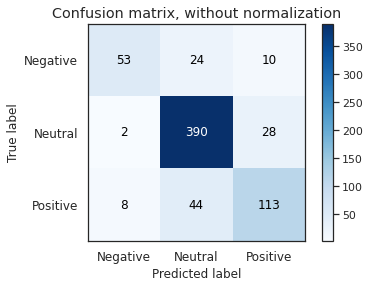

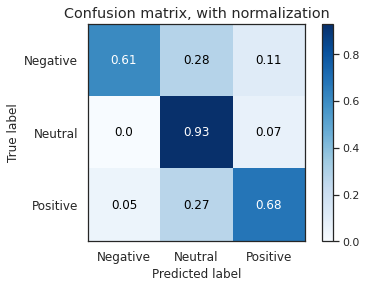

Starting epoch 15
Epoch: 15/30... Step: 10... Loss: 0.019144... Val Loss: 0.761594 Accuracy: 0.776786 F1 Score: 0.738260
Epoch: 15/30... Step: 20... Loss: 0.071332... Val Loss: 0.687758 Accuracy: 0.831845 F1 Score: 0.772798
Epoch: 15/30... Step: 30... Loss: 0.204701... Val Loss: 0.746411 Accuracy: 0.831845 F1 Score: 0.758289
Epoch: 15/30... Step: 40... Loss: 0.112120... Val Loss: 0.677259 Accuracy: 0.791667 F1 Score: 0.741651
Epoch: 15/30... Step: 50... Loss: 0.161870... Val Loss: 0.676250 Accuracy: 0.812500 F1 Score: 0.753122
Epoch: 15/30... Step: 60... Loss: 0.213810... Val Loss: 0.765043 Accuracy: 0.828869 F1 Score: 0.754248
Epoch: 15/30... Step: 70... Loss: 0.087116... Val Loss: 0.701000 Accuracy: 0.812500 F1 Score: 0.761389
Epoch: 15/30... Step: 80... Loss: 0.063134... Val Loss: 0.723020 Accuracy: 0.809524 F1 Score: 0.753138
87 steps in epoch 15

Epoch: 15, Average Accuracy: 0.80952381, Average f1: 0.75313753



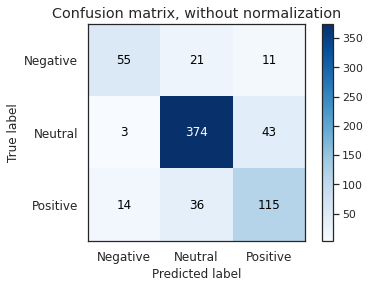

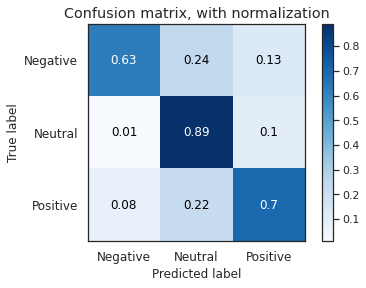

Starting epoch 16
Epoch: 16/30... Step: 10... Loss: 0.042765... Val Loss: 0.720449 Accuracy: 0.819940 F1 Score: 0.758059
Epoch: 16/30... Step: 20... Loss: 0.243965... Val Loss: 0.742126 Accuracy: 0.772321 F1 Score: 0.728000
Epoch: 16/30... Step: 30... Loss: 0.075773... Val Loss: 0.760914 Accuracy: 0.825893 F1 Score: 0.754043
Epoch: 16/30... Step: 40... Loss: 0.080185... Val Loss: 0.687970 Accuracy: 0.830357 F1 Score: 0.764134
Epoch: 16/30... Step: 50... Loss: 0.198393... Val Loss: 0.686925 Accuracy: 0.809524 F1 Score: 0.752204
Epoch: 16/30... Step: 60... Loss: 0.073944... Val Loss: 0.771095 Accuracy: 0.809524 F1 Score: 0.747264
Epoch: 16/30... Step: 70... Loss: 0.069657... Val Loss: 0.725088 Accuracy: 0.812500 F1 Score: 0.754957
Epoch: 16/30... Step: 80... Loss: 0.048498... Val Loss: 0.726581 Accuracy: 0.813988 F1 Score: 0.757071
87 steps in epoch 16

Epoch: 16, Average Accuracy: 0.81398810, Average f1: 0.75707057



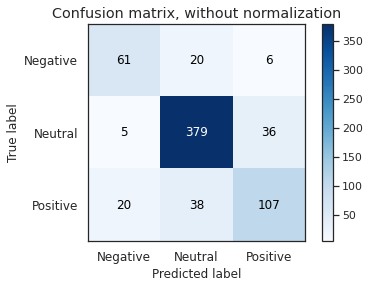

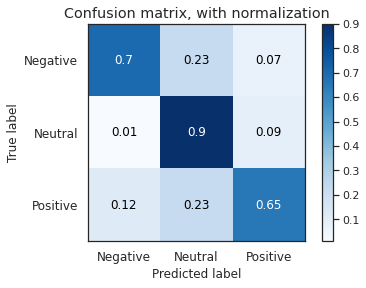

Starting epoch 17
Epoch: 17/30... Step: 10... Loss: 0.009088... Val Loss: 0.775264 Accuracy: 0.822917 F1 Score: 0.751410
Epoch: 17/30... Step: 20... Loss: 0.015776... Val Loss: 0.795751 Accuracy: 0.822917 F1 Score: 0.756150
Epoch: 17/30... Step: 30... Loss: 0.047867... Val Loss: 0.784862 Accuracy: 0.811012 F1 Score: 0.745683
Epoch: 17/30... Step: 40... Loss: 0.056088... Val Loss: 0.776025 Accuracy: 0.824405 F1 Score: 0.758076
Epoch: 17/30... Step: 50... Loss: 0.172849... Val Loss: 0.750968 Accuracy: 0.822917 F1 Score: 0.772428
Epoch: 17/30... Step: 60... Loss: 0.049953... Val Loss: 0.811550 Accuracy: 0.818452 F1 Score: 0.750842
Epoch: 17/30... Step: 70... Loss: 0.066976... Val Loss: 0.785748 Accuracy: 0.818452 F1 Score: 0.760886
Epoch: 17/30... Step: 80... Loss: 0.020326... Val Loss: 0.786232 Accuracy: 0.808036 F1 Score: 0.759567
87 steps in epoch 17

Epoch: 17, Average Accuracy: 0.80803571, Average f1: 0.75956669



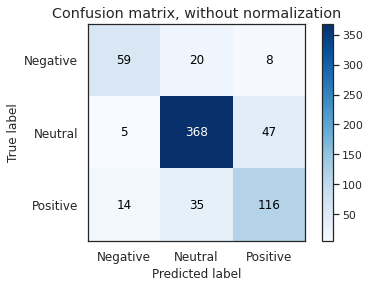

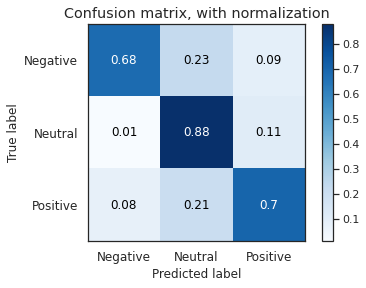

Starting epoch 18
Epoch: 18/30... Step: 10... Loss: 0.012102... Val Loss: 0.815732 Accuracy: 0.822917 F1 Score: 0.753620
Epoch: 18/30... Step: 20... Loss: 0.064539... Val Loss: 0.829939 Accuracy: 0.821429 F1 Score: 0.755253
Epoch: 18/30... Step: 30... Loss: 0.044218... Val Loss: 0.791312 Accuracy: 0.812500 F1 Score: 0.758741
Epoch: 18/30... Step: 40... Loss: 0.045724... Val Loss: 0.790755 Accuracy: 0.821429 F1 Score: 0.754662
Epoch: 18/30... Step: 50... Loss: 0.131249... Val Loss: 0.755349 Accuracy: 0.824405 F1 Score: 0.769510
Epoch: 18/30... Step: 60... Loss: 0.031237... Val Loss: 0.788171 Accuracy: 0.824405 F1 Score: 0.772857
Epoch: 18/30... Step: 70... Loss: 0.061933... Val Loss: 0.810229 Accuracy: 0.819940 F1 Score: 0.763376
Epoch: 18/30... Step: 80... Loss: 0.011861... Val Loss: 0.792342 Accuracy: 0.818452 F1 Score: 0.765109
87 steps in epoch 18

Epoch: 18, Average Accuracy: 0.81845238, Average f1: 0.76510894



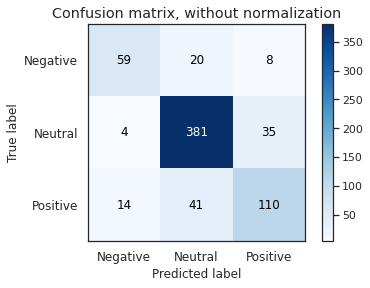

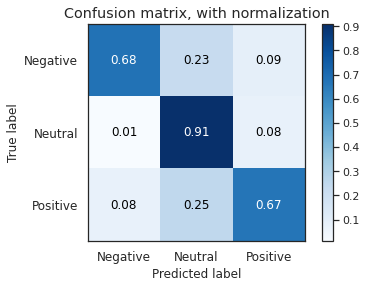

Starting epoch 19
Epoch: 19/30... Step: 10... Loss: 0.006951... Val Loss: 0.825921 Accuracy: 0.831845 F1 Score: 0.772001
Epoch: 19/30... Step: 20... Loss: 0.047442... Val Loss: 0.863249 Accuracy: 0.830357 F1 Score: 0.765468
Epoch: 19/30... Step: 30... Loss: 0.046976... Val Loss: 0.806729 Accuracy: 0.821429 F1 Score: 0.764812
Epoch: 19/30... Step: 40... Loss: 0.034998... Val Loss: 0.821966 Accuracy: 0.821429 F1 Score: 0.761542
Epoch: 19/30... Step: 50... Loss: 0.122510... Val Loss: 0.832555 Accuracy: 0.822917 F1 Score: 0.761318
Epoch: 19/30... Step: 60... Loss: 0.021435... Val Loss: 0.841117 Accuracy: 0.808036 F1 Score: 0.758713
Epoch: 19/30... Step: 70... Loss: 0.034666... Val Loss: 0.839920 Accuracy: 0.815476 F1 Score: 0.765009
Epoch: 19/30... Step: 80... Loss: 0.010535... Val Loss: 0.843076 Accuracy: 0.830357 F1 Score: 0.769334
87 steps in epoch 19

Epoch: 19, Average Accuracy: 0.83035714, Average f1: 0.76933405



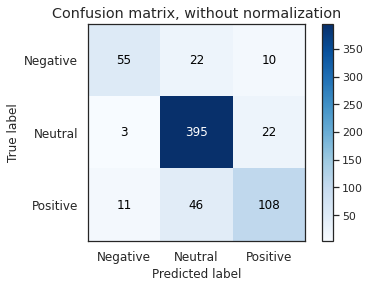

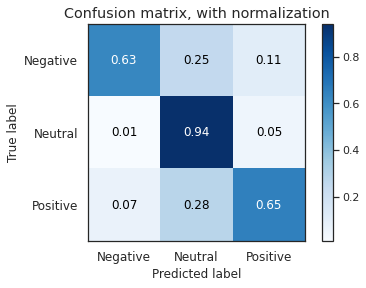

Starting epoch 20
Epoch: 20/30... Step: 10... Loss: 0.004880... Val Loss: 0.853484 Accuracy: 0.818452 F1 Score: 0.760581
Epoch: 20/30... Step: 20... Loss: 0.009952... Val Loss: 0.874947 Accuracy: 0.821429 F1 Score: 0.766587
Epoch: 20/30... Step: 30... Loss: 0.019540... Val Loss: 0.865583 Accuracy: 0.813988 F1 Score: 0.762357
Epoch: 20/30... Step: 40... Loss: 0.023388... Val Loss: 0.854951 Accuracy: 0.822917 F1 Score: 0.767964
Epoch: 20/30... Step: 50... Loss: 0.127104... Val Loss: 0.856568 Accuracy: 0.821429 F1 Score: 0.763533
Epoch: 20/30... Step: 60... Loss: 0.014606... Val Loss: 0.879412 Accuracy: 0.822917 F1 Score: 0.767047
Epoch: 20/30... Step: 70... Loss: 0.031118... Val Loss: 0.874317 Accuracy: 0.811012 F1 Score: 0.759060
Epoch: 20/30... Step: 80... Loss: 0.008471... Val Loss: 0.879646 Accuracy: 0.812500 F1 Score: 0.757977
87 steps in epoch 20

Epoch: 20, Average Accuracy: 0.81250000, Average f1: 0.75797698



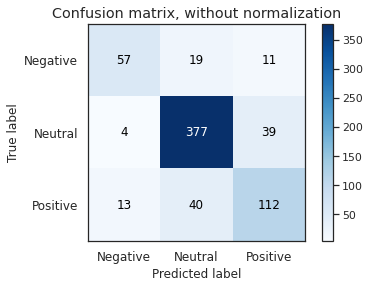

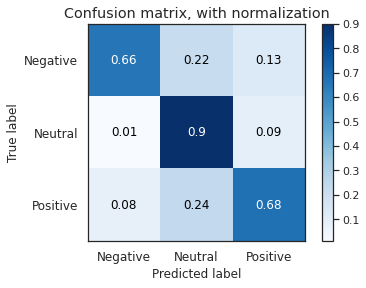

Starting epoch 21
Epoch: 21/30... Step: 10... Loss: 0.005182... Val Loss: 0.913258 Accuracy: 0.818452 F1 Score: 0.754066
Epoch: 21/30... Step: 20... Loss: 0.025354... Val Loss: 0.924379 Accuracy: 0.819940 F1 Score: 0.756093
Epoch: 21/30... Step: 30... Loss: 0.066469... Val Loss: 0.891068 Accuracy: 0.808036 F1 Score: 0.752679
Epoch: 21/30... Step: 40... Loss: 0.013567... Val Loss: 0.871209 Accuracy: 0.819940 F1 Score: 0.763533
Epoch: 21/30... Step: 50... Loss: 0.117417... Val Loss: 0.884570 Accuracy: 0.828869 F1 Score: 0.768145
Epoch: 21/30... Step: 60... Loss: 0.009279... Val Loss: 0.872217 Accuracy: 0.811012 F1 Score: 0.755809
Epoch: 21/30... Step: 70... Loss: 0.025444... Val Loss: 0.890088 Accuracy: 0.809524 F1 Score: 0.758600
Epoch: 21/30... Step: 80... Loss: 0.007925... Val Loss: 0.861372 Accuracy: 0.819940 F1 Score: 0.762872
87 steps in epoch 21

Epoch: 21, Average Accuracy: 0.81994048, Average f1: 0.76287215



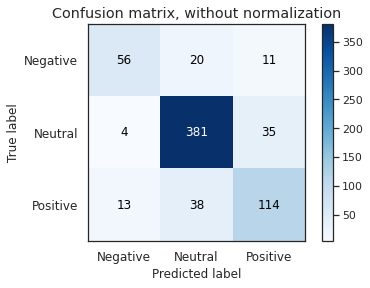

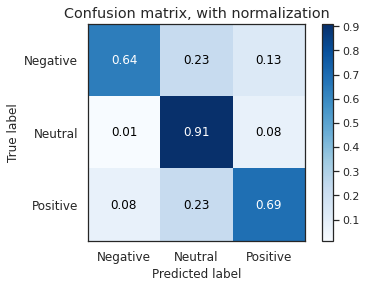

Starting epoch 22
Epoch: 22/30... Step: 10... Loss: 0.004069... Val Loss: 0.871455 Accuracy: 0.827381 F1 Score: 0.772657
Epoch: 22/30... Step: 20... Loss: 0.004722... Val Loss: 0.886698 Accuracy: 0.824405 F1 Score: 0.767336
Epoch: 22/30... Step: 30... Loss: 0.011115... Val Loss: 0.894402 Accuracy: 0.822917 F1 Score: 0.766356
Epoch: 22/30... Step: 40... Loss: 0.012772... Val Loss: 0.863574 Accuracy: 0.819940 F1 Score: 0.762725
Epoch: 22/30... Step: 50... Loss: 0.134897... Val Loss: 0.844533 Accuracy: 0.825893 F1 Score: 0.773705
Epoch: 22/30... Step: 60... Loss: 0.007656... Val Loss: 0.886462 Accuracy: 0.825893 F1 Score: 0.769582
Epoch: 22/30... Step: 70... Loss: 0.044423... Val Loss: 0.877362 Accuracy: 0.819940 F1 Score: 0.762594
Epoch: 22/30... Step: 80... Loss: 0.015851... Val Loss: 0.922070 Accuracy: 0.800595 F1 Score: 0.764490
87 steps in epoch 22

Epoch: 22, Average Accuracy: 0.80059524, Average f1: 0.76448956



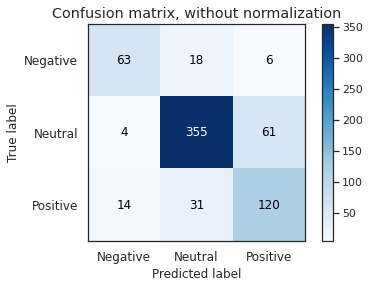

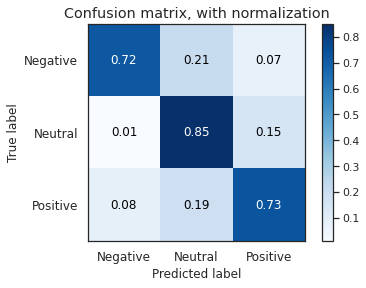

Starting epoch 23
Epoch: 23/30... Step: 10... Loss: 0.005089... Val Loss: 0.952894 Accuracy: 0.827381 F1 Score: 0.763368
Epoch: 23/30... Step: 20... Loss: 0.004776... Val Loss: 0.972185 Accuracy: 0.828869 F1 Score: 0.762522
Epoch: 23/30... Step: 30... Loss: 0.023502... Val Loss: 0.940576 Accuracy: 0.827381 F1 Score: 0.765940
Epoch: 23/30... Step: 40... Loss: 0.011397... Val Loss: 0.920881 Accuracy: 0.815476 F1 Score: 0.755425
Epoch: 23/30... Step: 50... Loss: 0.102053... Val Loss: 0.942246 Accuracy: 0.821429 F1 Score: 0.759322
Epoch: 23/30... Step: 60... Loss: 0.008313... Val Loss: 0.947287 Accuracy: 0.818452 F1 Score: 0.759249
Epoch: 23/30... Step: 70... Loss: 0.016332... Val Loss: 0.950414 Accuracy: 0.809524 F1 Score: 0.757871
Epoch: 23/30... Step: 80... Loss: 0.004689... Val Loss: 0.927373 Accuracy: 0.816964 F1 Score: 0.763619
87 steps in epoch 23

Epoch: 23, Average Accuracy: 0.81696429, Average f1: 0.76361910



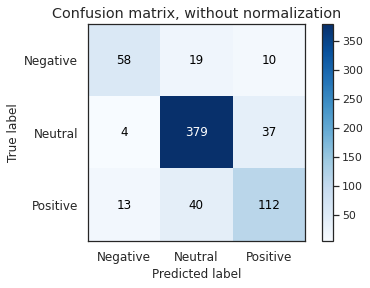

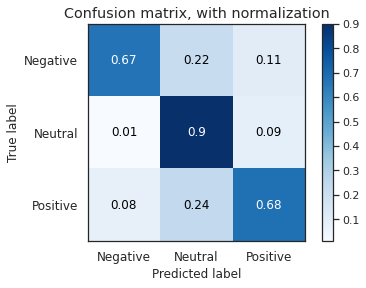

Starting epoch 24
Epoch: 24/30... Step: 10... Loss: 0.003624... Val Loss: 0.937400 Accuracy: 0.815476 F1 Score: 0.757050
Epoch: 24/30... Step: 20... Loss: 0.025117... Val Loss: 0.968910 Accuracy: 0.816964 F1 Score: 0.752778
Epoch: 24/30... Step: 30... Loss: 0.008663... Val Loss: 0.957596 Accuracy: 0.819940 F1 Score: 0.760979
Epoch: 24/30... Step: 40... Loss: 0.011405... Val Loss: 0.959838 Accuracy: 0.816964 F1 Score: 0.755830
Epoch: 24/30... Step: 50... Loss: 0.103598... Val Loss: 0.937692 Accuracy: 0.811012 F1 Score: 0.755381
Epoch: 24/30... Step: 60... Loss: 0.007525... Val Loss: 0.951585 Accuracy: 0.815476 F1 Score: 0.756517
Epoch: 24/30... Step: 70... Loss: 0.016464... Val Loss: 0.961175 Accuracy: 0.813988 F1 Score: 0.753155
Epoch: 24/30... Step: 80... Loss: 0.005425... Val Loss: 0.947942 Accuracy: 0.822917 F1 Score: 0.766978
87 steps in epoch 24

Epoch: 24, Average Accuracy: 0.82291667, Average f1: 0.76697847



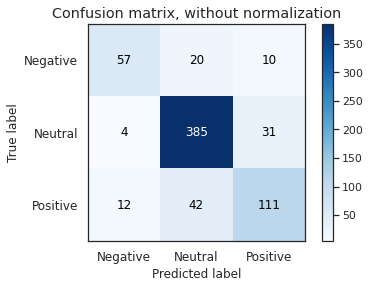

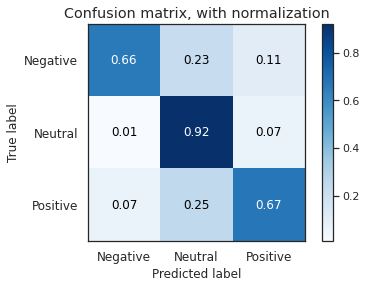

Starting epoch 25
Epoch: 25/30... Step: 10... Loss: 0.002305... Val Loss: 0.967867 Accuracy: 0.821429 F1 Score: 0.758389
Epoch: 25/30... Step: 20... Loss: 0.024842... Val Loss: 1.014682 Accuracy: 0.824405 F1 Score: 0.762585
Epoch: 25/30... Step: 30... Loss: 0.006835... Val Loss: 0.977706 Accuracy: 0.819940 F1 Score: 0.758018
Epoch: 25/30... Step: 40... Loss: 0.010001... Val Loss: 0.960532 Accuracy: 0.819940 F1 Score: 0.767436
Epoch: 25/30... Step: 50... Loss: 0.092293... Val Loss: 0.974638 Accuracy: 0.816964 F1 Score: 0.757780
Epoch: 25/30... Step: 60... Loss: 0.004887... Val Loss: 0.985981 Accuracy: 0.819940 F1 Score: 0.758486
Epoch: 25/30... Step: 70... Loss: 0.010041... Val Loss: 0.981690 Accuracy: 0.816964 F1 Score: 0.762898
Epoch: 25/30... Step: 80... Loss: 0.006175... Val Loss: 0.991089 Accuracy: 0.811012 F1 Score: 0.759419
87 steps in epoch 25

Epoch: 25, Average Accuracy: 0.81101190, Average f1: 0.75941922



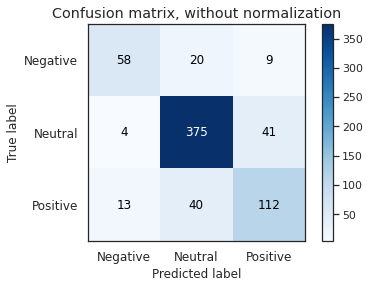

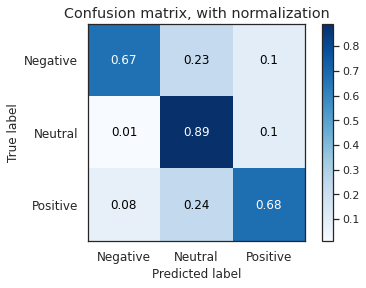

Starting epoch 26
Epoch: 26/30... Step: 10... Loss: 0.002719... Val Loss: 0.999384 Accuracy: 0.812500 F1 Score: 0.756078
Epoch: 26/30... Step: 20... Loss: 0.002180... Val Loss: 1.009056 Accuracy: 0.821429 F1 Score: 0.761870
Epoch: 26/30... Step: 30... Loss: 0.008814... Val Loss: 1.023131 Accuracy: 0.822917 F1 Score: 0.762786
Epoch: 26/30... Step: 40... Loss: 0.006374... Val Loss: 1.039906 Accuracy: 0.825893 F1 Score: 0.763082
Epoch: 26/30... Step: 50... Loss: 0.091125... Val Loss: 1.011351 Accuracy: 0.822917 F1 Score: 0.760056
Epoch: 26/30... Step: 60... Loss: 0.004143... Val Loss: 1.002172 Accuracy: 0.819940 F1 Score: 0.762388
Epoch: 26/30... Step: 70... Loss: 0.010875... Val Loss: 1.000992 Accuracy: 0.818452 F1 Score: 0.761780
Epoch: 26/30... Step: 80... Loss: 0.003248... Val Loss: 1.011234 Accuracy: 0.827381 F1 Score: 0.769769
87 steps in epoch 26

Epoch: 26, Average Accuracy: 0.82738095, Average f1: 0.76976859



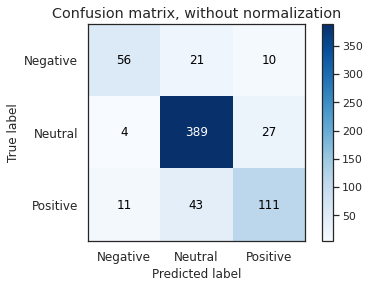

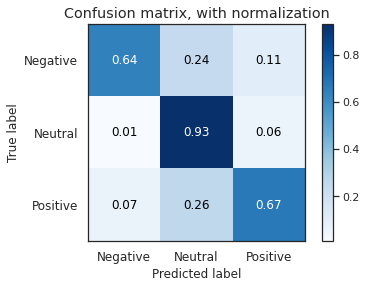

Starting epoch 27
Epoch: 27/30... Step: 10... Loss: 0.002316... Val Loss: 0.994746 Accuracy: 0.827381 F1 Score: 0.773261
Epoch: 27/30... Step: 20... Loss: 0.002289... Val Loss: 1.015067 Accuracy: 0.828869 F1 Score: 0.772393
Epoch: 27/30... Step: 30... Loss: 0.005066... Val Loss: 1.019196 Accuracy: 0.828869 F1 Score: 0.772393
Epoch: 27/30... Step: 40... Loss: 0.006835... Val Loss: 1.007602 Accuracy: 0.824405 F1 Score: 0.769242
Epoch: 27/30... Step: 50... Loss: 0.094474... Val Loss: 1.015683 Accuracy: 0.827381 F1 Score: 0.772727
Epoch: 27/30... Step: 60... Loss: 0.003865... Val Loss: 1.029472 Accuracy: 0.833333 F1 Score: 0.781334
Epoch: 27/30... Step: 70... Loss: 0.023622... Val Loss: 1.023730 Accuracy: 0.818452 F1 Score: 0.763902
Epoch: 27/30... Step: 80... Loss: 0.035946... Val Loss: 1.080978 Accuracy: 0.799107 F1 Score: 0.758283
87 steps in epoch 27

Epoch: 27, Average Accuracy: 0.79910714, Average f1: 0.75828291



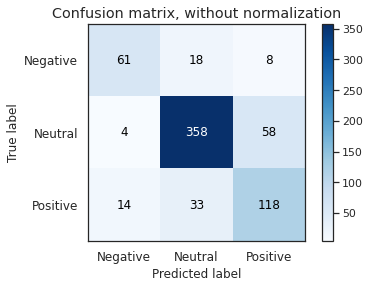

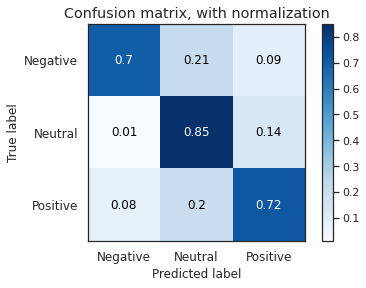

Starting epoch 28
Epoch: 28/30... Step: 10... Loss: 0.002112... Val Loss: 0.991775 Accuracy: 0.822917 F1 Score: 0.766573
Epoch: 28/30... Step: 20... Loss: 0.003291... Val Loss: 0.997207 Accuracy: 0.809524 F1 Score: 0.765221
Epoch: 28/30... Step: 30... Loss: 0.013525... Val Loss: 1.005263 Accuracy: 0.834821 F1 Score: 0.770465
Epoch: 28/30... Step: 40... Loss: 0.008488... Val Loss: 1.011282 Accuracy: 0.828869 F1 Score: 0.769647
Epoch: 28/30... Step: 50... Loss: 0.054021... Val Loss: 1.027548 Accuracy: 0.803571 F1 Score: 0.758374
Epoch: 28/30... Step: 60... Loss: 0.005150... Val Loss: 0.965471 Accuracy: 0.813988 F1 Score: 0.752389
Epoch: 28/30... Step: 70... Loss: 0.018606... Val Loss: 0.978226 Accuracy: 0.825893 F1 Score: 0.766517
Epoch: 28/30... Step: 80... Loss: 0.003289... Val Loss: 1.003324 Accuracy: 0.816964 F1 Score: 0.755175
87 steps in epoch 28

Epoch: 28, Average Accuracy: 0.81696429, Average f1: 0.75517501



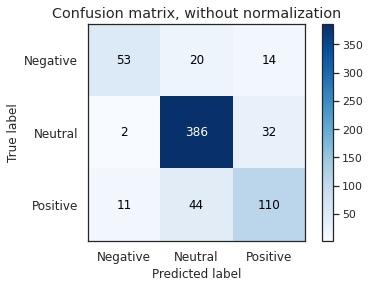

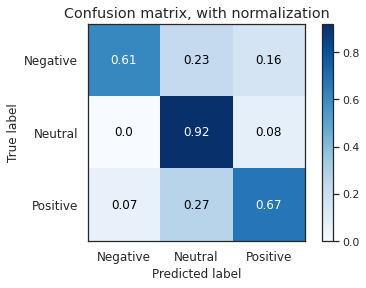

Starting epoch 29
Epoch: 29/30... Step: 10... Loss: 0.002250... Val Loss: 1.011105 Accuracy: 0.808036 F1 Score: 0.751901
Epoch: 29/30... Step: 20... Loss: 0.002196... Val Loss: 1.008349 Accuracy: 0.806548 F1 Score: 0.750713
Epoch: 29/30... Step: 30... Loss: 0.004202... Val Loss: 1.002961 Accuracy: 0.812500 F1 Score: 0.754419
Epoch: 29/30... Step: 40... Loss: 0.004372... Val Loss: 1.044955 Accuracy: 0.824405 F1 Score: 0.760251
Epoch: 29/30... Step: 50... Loss: 0.068537... Val Loss: 1.020488 Accuracy: 0.821429 F1 Score: 0.757268
Epoch: 29/30... Step: 60... Loss: 0.003318... Val Loss: 1.014954 Accuracy: 0.822917 F1 Score: 0.766180
Epoch: 29/30... Step: 70... Loss: 0.010973... Val Loss: 1.018774 Accuracy: 0.818452 F1 Score: 0.762719
Epoch: 29/30... Step: 80... Loss: 0.002540... Val Loss: 1.025450 Accuracy: 0.819940 F1 Score: 0.761835
87 steps in epoch 29

Epoch: 29, Average Accuracy: 0.81994048, Average f1: 0.76183520



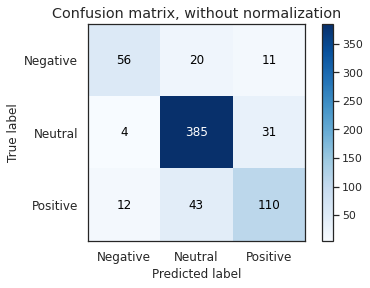

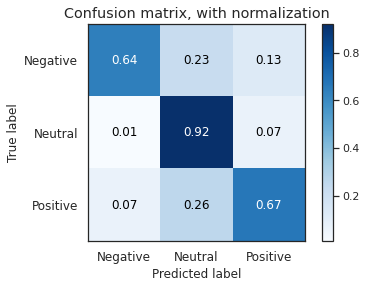

Starting epoch 30
Epoch: 30/30... Step: 10... Loss: 0.001305... Val Loss: 1.043338 Accuracy: 0.816964 F1 Score: 0.755635
Epoch: 30/30... Step: 20... Loss: 0.001313... Val Loss: 1.058100 Accuracy: 0.818452 F1 Score: 0.756532
Epoch: 30/30... Step: 30... Loss: 0.003222... Val Loss: 1.065910 Accuracy: 0.818452 F1 Score: 0.756599
Epoch: 30/30... Step: 40... Loss: 0.003066... Val Loss: 1.063530 Accuracy: 0.818452 F1 Score: 0.755768
Epoch: 30/30... Step: 50... Loss: 0.056475... Val Loss: 1.062280 Accuracy: 0.819940 F1 Score: 0.757676
Epoch: 30/30... Step: 60... Loss: 0.003197... Val Loss: 1.066919 Accuracy: 0.822917 F1 Score: 0.760777
Epoch: 30/30... Step: 70... Loss: 0.004364... Val Loss: 1.067620 Accuracy: 0.824405 F1 Score: 0.764389
Epoch: 30/30... Step: 80... Loss: 0.002349... Val Loss: 1.066792 Accuracy: 0.816964 F1 Score: 0.754016
87 steps in epoch 30

Epoch: 30, Average Accuracy: 0.81696429, Average f1: 0.75401580



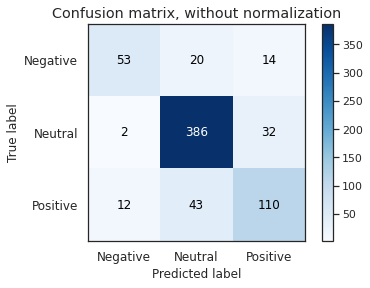

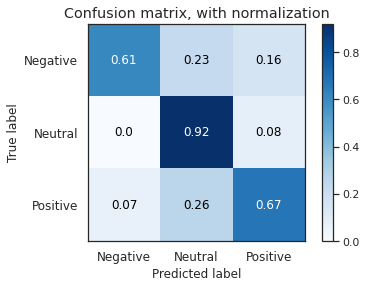

In [53]:
train_model(model)

# D. Glove Word Embedding + LSTM
Use GloVe word embedding as embedding layer

### Download GloVe files

In [54]:
# Use 6B 300d uncased
glove_file_pickle = 'glove.6B.300d.pickle'
glove_file_zip = 'glove.6B.zip'
glove_file_txt = 'glove.6B.300d.txt'

# # User 42B 300d uncased
# glove_file_pickle = 'glove.42B.300d.pickle'
# glove_file_zip = 'glove.42B.300d.zip'
# glove_file_txt = 'glove.42B.300d.txt'

# Download Glove file if not exist
if not os.path.exists(glove_dir + glove_file_pickle):
    if not os.path.exists(glove_dir):
        os.mkdir(glove_dir)
    if not os.path.exists(glove_dir + glove_file_zip):
        !wget -o $glove_dir$glove_file_zip http://nlp.stanford.edu/data/$glove_file_zip
    # Unzip the downloaded file
    !unzip $glove_dir$glove_file_zip -d $glove_dir
    embedding_dict = {}

    with open(glove_dir + glove_file_txt, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vectors = np.asarray(values[1:], 'float32')
            embedding_dict[word] = vectors
    f.close()

    pickle.dump(embedding_dict, open(glove_dir + glove_file_pickle, 'wb'))

In [55]:
glove_dict = pickle.load(open(glove_dir + glove_file_pickle, 'rb'))
print(len(glove_dict))
glove_dict['the']

400000


array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [56]:
weight_matrix = np.zeros((len(vocab)+1, 300))
words_found = 0

for i, word in enumerate(vocab):
    try:
        weight_matrix[i] = glove_dict[word]
        words_found += 1
    except KeyError:
        weight_matrix[i] = np.random.normal(scale=0.6, size=(300,))

print('{} words found out of {} words in vocab.'.format(words_found, len(vocab)))
print(weight_matrix.shape)

6406 words found out of 7135 words in vocab.
(7136, 300)


### Define Model

In [57]:
class GloveTextClassifier(nn.Module):
    def __init__(self, weight_matrix, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        vocab_size, embed_size = weight_matrix.shape
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embedding.load_state_dict({'weight': torch.tensor(weight_matrix)})
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(0.2)
        # self.fc1 = nn.Linear(lstm_size, dense_size)
        # self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(lstm_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                  weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input
        """
        batch_size = nn_input_text.size(0)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text)
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        # Dense layer
        # dense_out = self.fc1(lstm_out)
        # out = self.fc2(dense_out)
        out = self.fc(lstm_out)
        logps = self.softmax(out)

        return logps, hidden_state

### Configure the model and train!

In [58]:
# Set model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GloveTextClassifier(weight_matrix, 128, 3, lstm_layers=2, dropout=0.2)
model.to(device)

GloveTextClassifier(
  (embedding): Embedding(7136, 300)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax()
)

Starting epoch 1
Epoch: 1/30... Step: 10... Loss: 1.110151... Val Loss: 1.108815 Accuracy: 0.136905 F1 Score: 0.086032
Epoch: 1/30... Step: 20... Loss: 1.083905... Val Loss: 1.083030 Accuracy: 0.566964 F1 Score: 0.244231
Epoch: 1/30... Step: 30... Loss: 1.067652... Val Loss: 1.054426 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 40... Loss: 0.966971... Val Loss: 1.016761 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 50... Loss: 0.952010... Val Loss: 0.964605 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 60... Loss: 0.826309... Val Loss: 0.916753 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 70... Loss: 0.891634... Val Loss: 0.904024 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 1/30... Step: 80... Loss: 0.933695... Val Loss: 0.894608 Accuracy: 0.625000 F1 Score: 0.256410
87 steps in epoch 1

Epoch: 1, Average Accuracy: 0.62500000, Average f1: 0.25641026



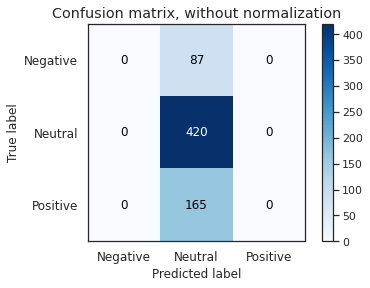

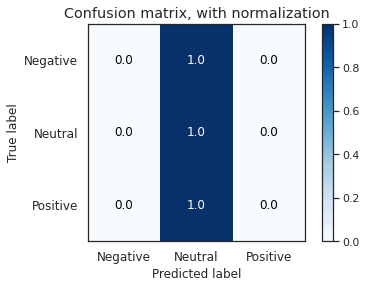

Starting epoch 2
Epoch: 2/30... Step: 10... Loss: 0.790362... Val Loss: 0.882367 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 2/30... Step: 20... Loss: 0.823793... Val Loss: 0.875296 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 2/30... Step: 30... Loss: 0.941695... Val Loss: 0.859963 Accuracy: 0.625000 F1 Score: 0.256410
Epoch: 2/30... Step: 40... Loss: 0.651709... Val Loss: 0.843965 Accuracy: 0.626488 F1 Score: 0.260661
Epoch: 2/30... Step: 50... Loss: 0.798374... Val Loss: 0.829576 Accuracy: 0.627976 F1 Score: 0.264865
Epoch: 2/30... Step: 60... Loss: 0.761164... Val Loss: 0.818251 Accuracy: 0.644345 F1 Score: 0.308084
Epoch: 2/30... Step: 70... Loss: 0.704152... Val Loss: 0.799565 Accuracy: 0.650298 F1 Score: 0.324634
Epoch: 2/30... Step: 80... Loss: 0.791400... Val Loss: 0.784963 Accuracy: 0.662202 F1 Score: 0.349873
87 steps in epoch 2

Epoch: 2, Average Accuracy: 0.66220238, Average f1: 0.34987277



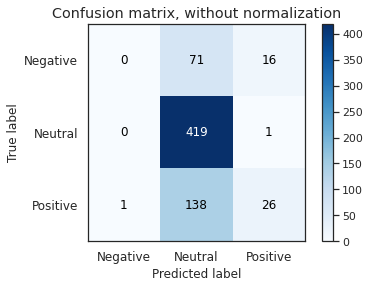

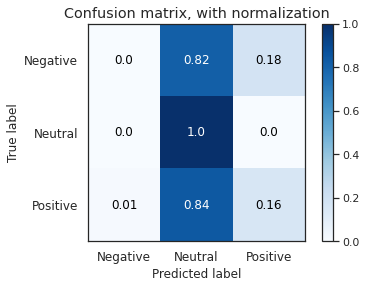

Starting epoch 3
Epoch: 3/30... Step: 10... Loss: 0.686976... Val Loss: 0.773323 Accuracy: 0.666667 F1 Score: 0.364666
Epoch: 3/30... Step: 20... Loss: 0.672079... Val Loss: 0.766345 Accuracy: 0.678571 F1 Score: 0.391376
Epoch: 3/30... Step: 30... Loss: 0.733331... Val Loss: 0.761092 Accuracy: 0.696429 F1 Score: 0.424889
Epoch: 3/30... Step: 40... Loss: 0.596879... Val Loss: 0.764825 Accuracy: 0.687500 F1 Score: 0.409175
Epoch: 3/30... Step: 50... Loss: 0.725188... Val Loss: 0.772137 Accuracy: 0.686012 F1 Score: 0.442334
Epoch: 3/30... Step: 60... Loss: 0.686083... Val Loss: 0.745588 Accuracy: 0.703869 F1 Score: 0.439560
Epoch: 3/30... Step: 70... Loss: 0.588540... Val Loss: 0.750771 Accuracy: 0.691964 F1 Score: 0.419240
Epoch: 3/30... Step: 80... Loss: 0.681730... Val Loss: 0.742264 Accuracy: 0.703869 F1 Score: 0.444132
87 steps in epoch 3

Epoch: 3, Average Accuracy: 0.70386905, Average f1: 0.44413199



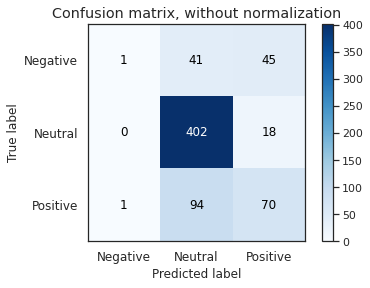

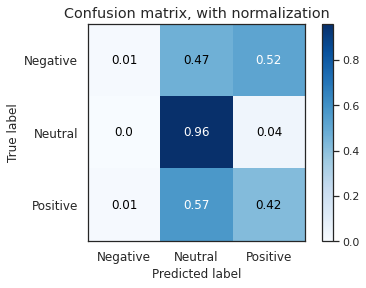

Starting epoch 4
Epoch: 4/30... Step: 10... Loss: 0.685510... Val Loss: 0.738241 Accuracy: 0.705357 F1 Score: 0.435106
Epoch: 4/30... Step: 20... Loss: 0.617363... Val Loss: 0.741708 Accuracy: 0.694940 F1 Score: 0.419549
Epoch: 4/30... Step: 30... Loss: 0.682965... Val Loss: 0.737593 Accuracy: 0.691964 F1 Score: 0.436833
Epoch: 4/30... Step: 40... Loss: 0.584235... Val Loss: 0.733232 Accuracy: 0.712798 F1 Score: 0.445549
Epoch: 4/30... Step: 50... Loss: 0.699376... Val Loss: 0.727571 Accuracy: 0.691964 F1 Score: 0.435717
Epoch: 4/30... Step: 60... Loss: 0.677553... Val Loss: 0.729050 Accuracy: 0.690476 F1 Score: 0.438333
Epoch: 4/30... Step: 70... Loss: 0.553625... Val Loss: 0.732970 Accuracy: 0.708333 F1 Score: 0.438709
Epoch: 4/30... Step: 80... Loss: 0.648194... Val Loss: 0.722340 Accuracy: 0.702381 F1 Score: 0.443908
87 steps in epoch 4

Epoch: 4, Average Accuracy: 0.70238095, Average f1: 0.44390769



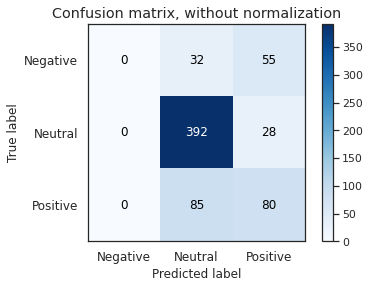

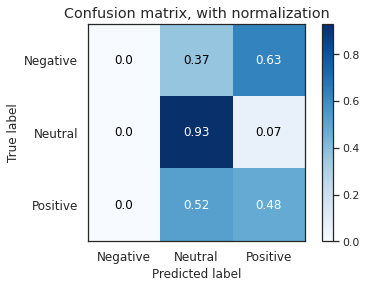

Starting epoch 5
Epoch: 5/30... Step: 10... Loss: 0.675210... Val Loss: 0.720245 Accuracy: 0.706845 F1 Score: 0.443654
Epoch: 5/30... Step: 20... Loss: 0.592722... Val Loss: 0.724351 Accuracy: 0.711310 F1 Score: 0.443068
Epoch: 5/30... Step: 30... Loss: 0.639368... Val Loss: 0.721756 Accuracy: 0.696429 F1 Score: 0.449361
Epoch: 5/30... Step: 40... Loss: 0.577585... Val Loss: 0.715054 Accuracy: 0.706845 F1 Score: 0.445510
Epoch: 5/30... Step: 50... Loss: 0.667733... Val Loss: 0.711514 Accuracy: 0.703869 F1 Score: 0.448930
Epoch: 5/30... Step: 60... Loss: 0.649295... Val Loss: 0.718573 Accuracy: 0.690476 F1 Score: 0.446063
Epoch: 5/30... Step: 70... Loss: 0.528875... Val Loss: 0.716776 Accuracy: 0.709821 F1 Score: 0.442476
Epoch: 5/30... Step: 80... Loss: 0.581219... Val Loss: 0.706920 Accuracy: 0.700893 F1 Score: 0.448818
87 steps in epoch 5

Epoch: 5, Average Accuracy: 0.70089286, Average f1: 0.44881770



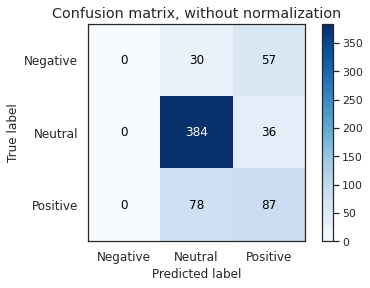

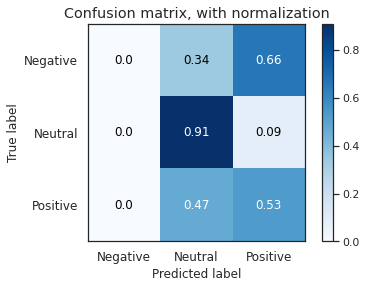

Starting epoch 6
Epoch: 6/30... Step: 10... Loss: 0.661396... Val Loss: 0.706115 Accuracy: 0.709821 F1 Score: 0.449625
Epoch: 6/30... Step: 20... Loss: 0.581284... Val Loss: 0.709754 Accuracy: 0.708333 F1 Score: 0.443365
Epoch: 6/30... Step: 30... Loss: 0.635133... Val Loss: 0.710710 Accuracy: 0.693452 F1 Score: 0.450014
Epoch: 6/30... Step: 40... Loss: 0.578702... Val Loss: 0.699850 Accuracy: 0.709821 F1 Score: 0.453462
Epoch: 6/30... Step: 50... Loss: 0.655189... Val Loss: 0.697759 Accuracy: 0.708333 F1 Score: 0.451676
Epoch: 6/30... Step: 60... Loss: 0.627962... Val Loss: 0.706630 Accuracy: 0.694940 F1 Score: 0.452404
Epoch: 6/30... Step: 70... Loss: 0.499544... Val Loss: 0.702607 Accuracy: 0.711310 F1 Score: 0.446213
Epoch: 6/30... Step: 80... Loss: 0.550198... Val Loss: 0.693612 Accuracy: 0.703869 F1 Score: 0.452943
87 steps in epoch 6

Epoch: 6, Average Accuracy: 0.70386905, Average f1: 0.45294272



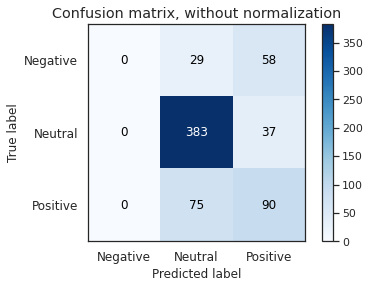

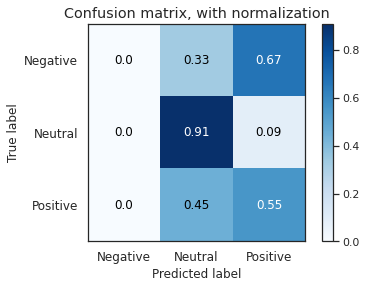

Starting epoch 7
Epoch: 7/30... Step: 10... Loss: 0.640016... Val Loss: 0.691905 Accuracy: 0.711310 F1 Score: 0.452158
Epoch: 7/30... Step: 20... Loss: 0.538190... Val Loss: 0.693103 Accuracy: 0.711310 F1 Score: 0.450768
Epoch: 7/30... Step: 30... Loss: 0.604608... Val Loss: 0.699073 Accuracy: 0.700893 F1 Score: 0.458906
Epoch: 7/30... Step: 40... Loss: 0.566261... Val Loss: 0.686807 Accuracy: 0.711310 F1 Score: 0.454849
Epoch: 7/30... Step: 50... Loss: 0.649294... Val Loss: 0.683540 Accuracy: 0.715774 F1 Score: 0.460120
Epoch: 7/30... Step: 60... Loss: 0.635117... Val Loss: 0.694091 Accuracy: 0.703869 F1 Score: 0.462120
Epoch: 7/30... Step: 70... Loss: 0.500889... Val Loss: 0.690020 Accuracy: 0.711310 F1 Score: 0.445991
Epoch: 7/30... Step: 80... Loss: 0.537361... Val Loss: 0.681563 Accuracy: 0.708333 F1 Score: 0.458324
87 steps in epoch 7

Epoch: 7, Average Accuracy: 0.70833333, Average f1: 0.45832427



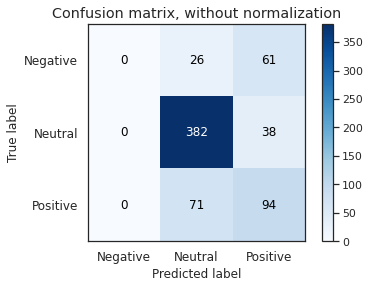

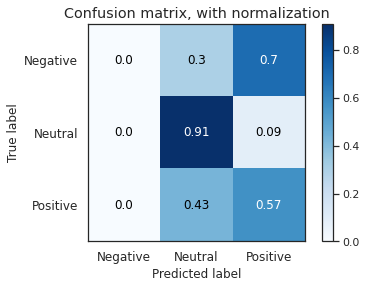

Starting epoch 8
Epoch: 8/30... Step: 10... Loss: 0.622575... Val Loss: 0.679019 Accuracy: 0.717262 F1 Score: 0.459604
Epoch: 8/30... Step: 20... Loss: 0.508946... Val Loss: 0.675398 Accuracy: 0.714286 F1 Score: 0.457510
Epoch: 8/30... Step: 30... Loss: 0.579529... Val Loss: 0.682103 Accuracy: 0.709821 F1 Score: 0.466484
Epoch: 8/30... Step: 40... Loss: 0.564974... Val Loss: 0.672588 Accuracy: 0.714286 F1 Score: 0.459592
Epoch: 8/30... Step: 50... Loss: 0.625844... Val Loss: 0.670014 Accuracy: 0.715774 F1 Score: 0.465949
Epoch: 8/30... Step: 60... Loss: 0.615567... Val Loss: 0.674688 Accuracy: 0.717262 F1 Score: 0.471126
Epoch: 8/30... Step: 70... Loss: 0.478436... Val Loss: 0.671618 Accuracy: 0.717262 F1 Score: 0.456335
Epoch: 8/30... Step: 80... Loss: 0.542005... Val Loss: 0.674216 Accuracy: 0.715774 F1 Score: 0.471363
87 steps in epoch 8

Epoch: 8, Average Accuracy: 0.71577381, Average f1: 0.47136296



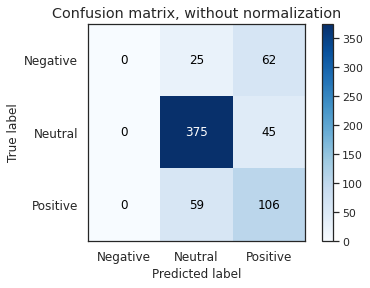

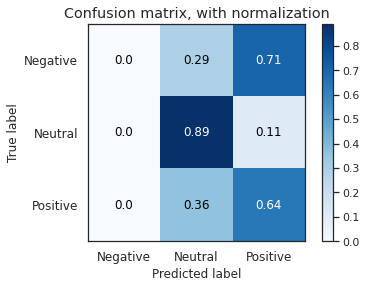

Starting epoch 9
Epoch: 9/30... Step: 10... Loss: 0.631247... Val Loss: 0.663527 Accuracy: 0.717262 F1 Score: 0.462064
Epoch: 9/30... Step: 20... Loss: 0.492938... Val Loss: 0.661634 Accuracy: 0.723214 F1 Score: 0.471947
Epoch: 9/30... Step: 30... Loss: 0.574673... Val Loss: 0.671196 Accuracy: 0.711310 F1 Score: 0.468766
Epoch: 9/30... Step: 40... Loss: 0.549004... Val Loss: 0.661623 Accuracy: 0.720238 F1 Score: 0.466389
Epoch: 9/30... Step: 50... Loss: 0.642034... Val Loss: 0.663377 Accuracy: 0.717262 F1 Score: 0.472782
Epoch: 9/30... Step: 60... Loss: 0.627381... Val Loss: 0.655281 Accuracy: 0.724702 F1 Score: 0.474624
Epoch: 9/30... Step: 70... Loss: 0.443487... Val Loss: 0.651335 Accuracy: 0.720238 F1 Score: 0.464947
Epoch: 9/30... Step: 80... Loss: 0.531900... Val Loss: 0.659983 Accuracy: 0.723214 F1 Score: 0.477636
87 steps in epoch 9

Epoch: 9, Average Accuracy: 0.72321429, Average f1: 0.47763636



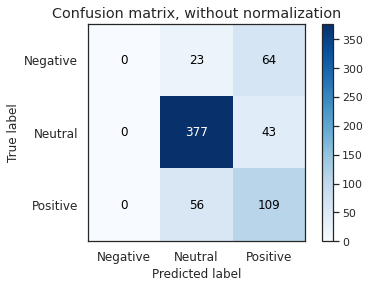

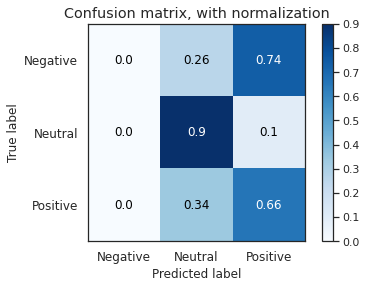

Starting epoch 10
Epoch: 10/30... Step: 10... Loss: 0.639440... Val Loss: 0.650765 Accuracy: 0.724702 F1 Score: 0.474931
Epoch: 10/30... Step: 20... Loss: 0.461143... Val Loss: 0.650960 Accuracy: 0.723214 F1 Score: 0.472464
Epoch: 10/30... Step: 30... Loss: 0.553284... Val Loss: 0.666664 Accuracy: 0.717262 F1 Score: 0.478047
Epoch: 10/30... Step: 40... Loss: 0.549011... Val Loss: 0.654965 Accuracy: 0.724702 F1 Score: 0.469484
Epoch: 10/30... Step: 50... Loss: 0.636674... Val Loss: 0.661835 Accuracy: 0.709821 F1 Score: 0.471023
Epoch: 10/30... Step: 60... Loss: 0.649514... Val Loss: 0.639477 Accuracy: 0.729167 F1 Score: 0.477955
Epoch: 10/30... Step: 70... Loss: 0.419509... Val Loss: 0.637416 Accuracy: 0.727679 F1 Score: 0.476113
Epoch: 10/30... Step: 80... Loss: 0.506565... Val Loss: 0.644997 Accuracy: 0.724702 F1 Score: 0.479210
87 steps in epoch 10

Epoch: 10, Average Accuracy: 0.72470238, Average f1: 0.47921017



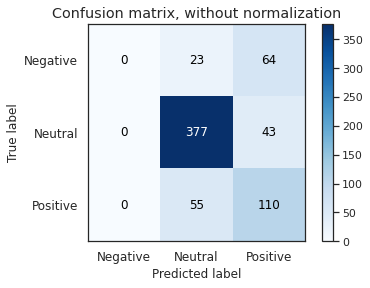

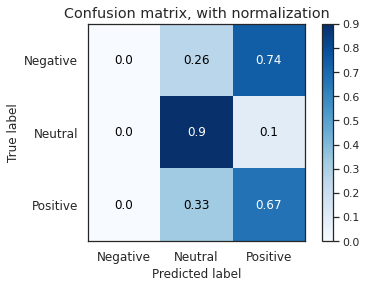

Starting epoch 11
Epoch: 11/30... Step: 10... Loss: 0.631177... Val Loss: 0.641011 Accuracy: 0.729167 F1 Score: 0.480738
Epoch: 11/30... Step: 20... Loss: 0.443976... Val Loss: 0.640174 Accuracy: 0.727679 F1 Score: 0.477897
Epoch: 11/30... Step: 30... Loss: 0.567650... Val Loss: 0.656435 Accuracy: 0.720238 F1 Score: 0.481068
Epoch: 11/30... Step: 40... Loss: 0.545839... Val Loss: 0.635419 Accuracy: 0.738095 F1 Score: 0.482710
Epoch: 11/30... Step: 50... Loss: 0.620476... Val Loss: 0.640722 Accuracy: 0.724702 F1 Score: 0.483295
Epoch: 11/30... Step: 60... Loss: 0.607047... Val Loss: 0.624925 Accuracy: 0.736607 F1 Score: 0.485210
Epoch: 11/30... Step: 70... Loss: 0.408435... Val Loss: 0.623360 Accuracy: 0.733631 F1 Score: 0.491109
Epoch: 11/30... Step: 80... Loss: 0.445762... Val Loss: 0.627657 Accuracy: 0.729167 F1 Score: 0.484330
87 steps in epoch 11

Epoch: 11, Average Accuracy: 0.72916667, Average f1: 0.48433045



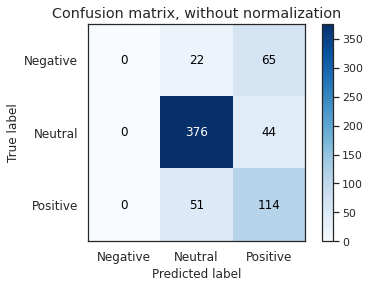

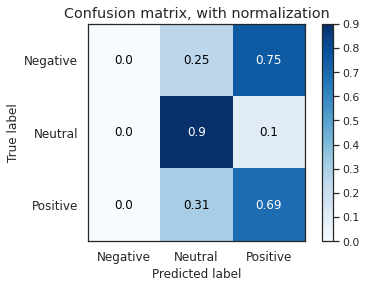

Starting epoch 12
Epoch: 12/30... Step: 10... Loss: 0.571897... Val Loss: 0.627335 Accuracy: 0.730655 F1 Score: 0.484840
Epoch: 12/30... Step: 20... Loss: 0.395559... Val Loss: 0.624716 Accuracy: 0.735119 F1 Score: 0.499247
Epoch: 12/30... Step: 30... Loss: 0.560030... Val Loss: 0.644427 Accuracy: 0.732143 F1 Score: 0.531862
Epoch: 12/30... Step: 40... Loss: 0.515451... Val Loss: 0.616005 Accuracy: 0.758929 F1 Score: 0.575338
Epoch: 12/30... Step: 50... Loss: 0.603853... Val Loss: 0.629057 Accuracy: 0.735119 F1 Score: 0.539961
Epoch: 12/30... Step: 60... Loss: 0.605657... Val Loss: 0.609651 Accuracy: 0.748512 F1 Score: 0.534300
Epoch: 12/30... Step: 70... Loss: 0.352311... Val Loss: 0.609655 Accuracy: 0.748512 F1 Score: 0.560000
Epoch: 12/30... Step: 80... Loss: 0.407894... Val Loss: 0.613282 Accuracy: 0.747024 F1 Score: 0.550049
87 steps in epoch 12

Epoch: 12, Average Accuracy: 0.74702381, Average f1: 0.55004851



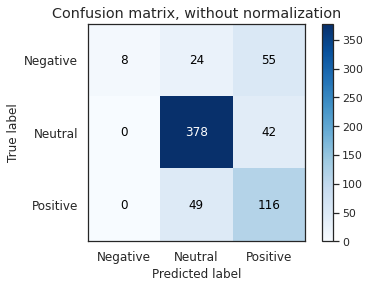

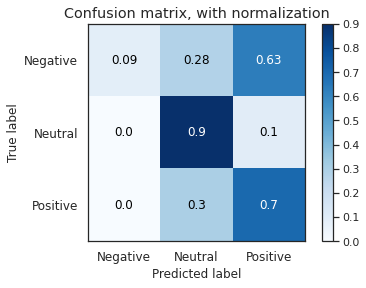

Starting epoch 13
Epoch: 13/30... Step: 10... Loss: 0.551843... Val Loss: 0.620240 Accuracy: 0.750000 F1 Score: 0.582615
Epoch: 13/30... Step: 20... Loss: 0.356076... Val Loss: 0.617262 Accuracy: 0.755952 F1 Score: 0.569636
Epoch: 13/30... Step: 30... Loss: 0.567274... Val Loss: 0.633359 Accuracy: 0.748512 F1 Score: 0.617154
Epoch: 13/30... Step: 40... Loss: 0.481884... Val Loss: 0.599731 Accuracy: 0.770833 F1 Score: 0.642766
Epoch: 13/30... Step: 50... Loss: 0.579002... Val Loss: 0.611036 Accuracy: 0.758929 F1 Score: 0.621106
Epoch: 13/30... Step: 60... Loss: 0.554562... Val Loss: 0.598027 Accuracy: 0.757440 F1 Score: 0.603908
Epoch: 13/30... Step: 70... Loss: 0.325752... Val Loss: 0.592350 Accuracy: 0.766369 F1 Score: 0.620940
Epoch: 13/30... Step: 80... Loss: 0.360988... Val Loss: 0.597429 Accuracy: 0.764881 F1 Score: 0.629501
87 steps in epoch 13

Epoch: 13, Average Accuracy: 0.76488095, Average f1: 0.62950093



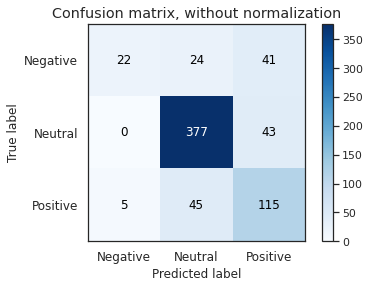

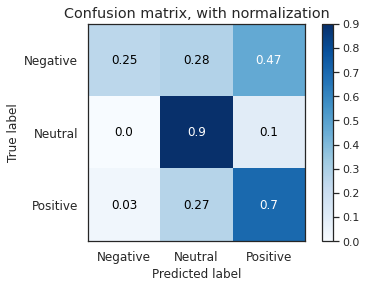

Starting epoch 14
Epoch: 14/30... Step: 10... Loss: 0.513591... Val Loss: 0.603235 Accuracy: 0.767857 F1 Score: 0.653549
Epoch: 14/30... Step: 20... Loss: 0.329122... Val Loss: 0.598854 Accuracy: 0.779762 F1 Score: 0.654266
Epoch: 14/30... Step: 30... Loss: 0.492070... Val Loss: 0.626630 Accuracy: 0.758929 F1 Score: 0.663714
Epoch: 14/30... Step: 40... Loss: 0.391538... Val Loss: 0.587982 Accuracy: 0.778274 F1 Score: 0.663617
Epoch: 14/30... Step: 50... Loss: 0.522715... Val Loss: 0.595097 Accuracy: 0.767857 F1 Score: 0.657754
Epoch: 14/30... Step: 60... Loss: 0.497919... Val Loss: 0.591583 Accuracy: 0.766369 F1 Score: 0.656787
Epoch: 14/30... Step: 70... Loss: 0.315648... Val Loss: 0.588833 Accuracy: 0.779762 F1 Score: 0.664904
Epoch: 14/30... Step: 80... Loss: 0.351769... Val Loss: 0.589848 Accuracy: 0.775298 F1 Score: 0.676409
87 steps in epoch 14

Epoch: 14, Average Accuracy: 0.77529762, Average f1: 0.67640944



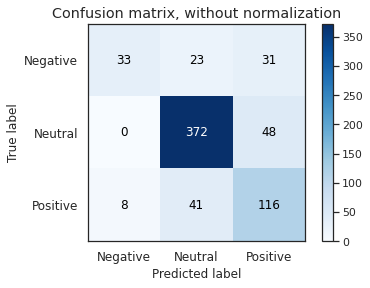

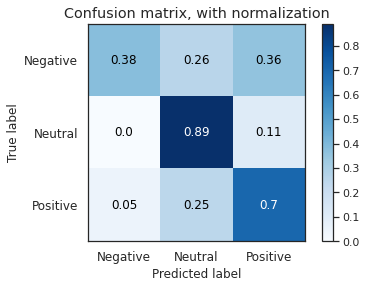

Starting epoch 15
Epoch: 15/30... Step: 10... Loss: 0.425076... Val Loss: 0.609922 Accuracy: 0.776786 F1 Score: 0.679967
Epoch: 15/30... Step: 20... Loss: 0.344450... Val Loss: 0.600034 Accuracy: 0.805060 F1 Score: 0.713733
Epoch: 15/30... Step: 30... Loss: 0.460554... Val Loss: 0.670304 Accuracy: 0.750000 F1 Score: 0.660185
Epoch: 15/30... Step: 40... Loss: 0.402077... Val Loss: 0.593811 Accuracy: 0.802083 F1 Score: 0.712647
Epoch: 15/30... Step: 50... Loss: 0.569198... Val Loss: 0.611999 Accuracy: 0.772321 F1 Score: 0.688577
Epoch: 15/30... Step: 60... Loss: 0.449447... Val Loss: 0.578379 Accuracy: 0.785714 F1 Score: 0.686104
Epoch: 15/30... Step: 70... Loss: 0.292394... Val Loss: 0.577141 Accuracy: 0.793155 F1 Score: 0.701294
Epoch: 15/30... Step: 80... Loss: 0.332561... Val Loss: 0.599126 Accuracy: 0.781250 F1 Score: 0.698067
87 steps in epoch 15

Epoch: 15, Average Accuracy: 0.78125000, Average f1: 0.69806705



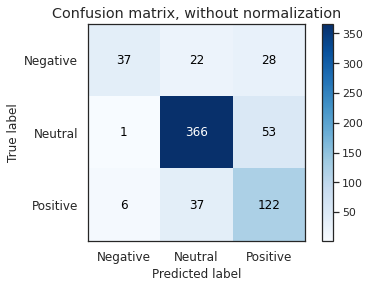

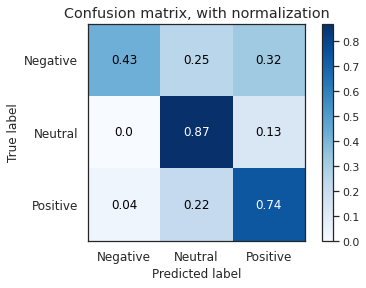

Starting epoch 16
Epoch: 16/30... Step: 10... Loss: 0.406747... Val Loss: 0.598667 Accuracy: 0.776786 F1 Score: 0.700391
Epoch: 16/30... Step: 20... Loss: 0.329474... Val Loss: 0.607882 Accuracy: 0.797619 F1 Score: 0.707839
Epoch: 16/30... Step: 30... Loss: 0.434107... Val Loss: 0.664534 Accuracy: 0.757440 F1 Score: 0.700821
Epoch: 16/30... Step: 40... Loss: 0.375357... Val Loss: 0.618356 Accuracy: 0.790179 F1 Score: 0.690817
Epoch: 16/30... Step: 50... Loss: 0.512457... Val Loss: 0.619555 Accuracy: 0.764881 F1 Score: 0.698158
Epoch: 16/30... Step: 60... Loss: 0.398720... Val Loss: 0.579727 Accuracy: 0.791667 F1 Score: 0.703743
Epoch: 16/30... Step: 70... Loss: 0.268213... Val Loss: 0.584863 Accuracy: 0.784226 F1 Score: 0.699202
Epoch: 16/30... Step: 80... Loss: 0.310954... Val Loss: 0.593143 Accuracy: 0.779762 F1 Score: 0.703922
87 steps in epoch 16

Epoch: 16, Average Accuracy: 0.77976190, Average f1: 0.70392236



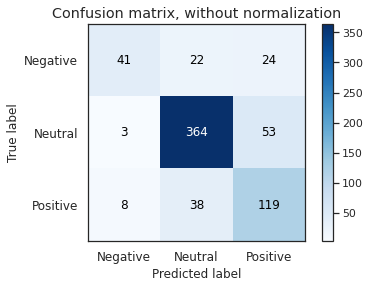

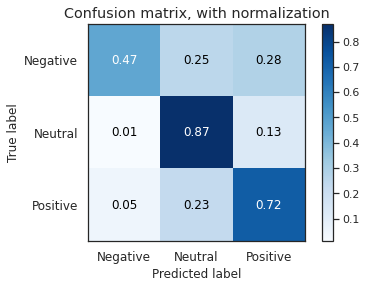

Starting epoch 17
Epoch: 17/30... Step: 10... Loss: 0.347737... Val Loss: 0.595349 Accuracy: 0.787202 F1 Score: 0.722107
Epoch: 17/30... Step: 20... Loss: 0.262906... Val Loss: 0.643571 Accuracy: 0.799107 F1 Score: 0.708947
Epoch: 17/30... Step: 30... Loss: 0.395960... Val Loss: 0.624784 Accuracy: 0.767857 F1 Score: 0.714717
Epoch: 17/30... Step: 40... Loss: 0.348259... Val Loss: 0.602475 Accuracy: 0.802083 F1 Score: 0.707532
Epoch: 17/30... Step: 50... Loss: 0.446345... Val Loss: 0.586432 Accuracy: 0.787202 F1 Score: 0.710985
Epoch: 17/30... Step: 60... Loss: 0.373937... Val Loss: 0.574072 Accuracy: 0.794643 F1 Score: 0.715161
Epoch: 17/30... Step: 70... Loss: 0.246229... Val Loss: 0.576716 Accuracy: 0.793155 F1 Score: 0.706002
Epoch: 17/30... Step: 80... Loss: 0.280727... Val Loss: 0.586783 Accuracy: 0.791667 F1 Score: 0.722709
87 steps in epoch 17

Epoch: 17, Average Accuracy: 0.79166667, Average f1: 0.72270913



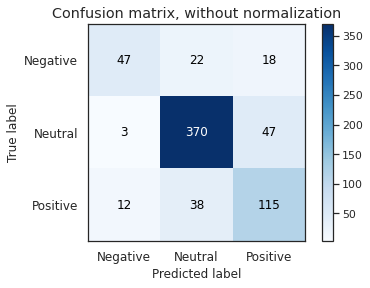

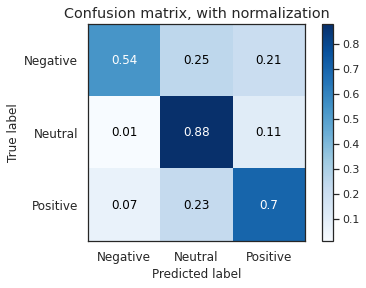

Starting epoch 18
Epoch: 18/30... Step: 10... Loss: 0.309967... Val Loss: 0.575840 Accuracy: 0.802083 F1 Score: 0.737566
Epoch: 18/30... Step: 20... Loss: 0.247273... Val Loss: 0.593999 Accuracy: 0.808036 F1 Score: 0.731477
Epoch: 18/30... Step: 30... Loss: 0.414275... Val Loss: 0.587335 Accuracy: 0.776786 F1 Score: 0.710251
Epoch: 18/30... Step: 40... Loss: 0.321522... Val Loss: 0.569724 Accuracy: 0.812500 F1 Score: 0.735500
Epoch: 18/30... Step: 50... Loss: 0.352279... Val Loss: 0.566462 Accuracy: 0.796131 F1 Score: 0.717607
Epoch: 18/30... Step: 60... Loss: 0.376159... Val Loss: 0.599371 Accuracy: 0.779762 F1 Score: 0.719413
Epoch: 18/30... Step: 70... Loss: 0.263452... Val Loss: 0.580755 Accuracy: 0.805060 F1 Score: 0.717326
Epoch: 18/30... Step: 80... Loss: 0.274081... Val Loss: 0.601350 Accuracy: 0.779762 F1 Score: 0.716843
87 steps in epoch 18

Epoch: 18, Average Accuracy: 0.77976190, Average f1: 0.71684340



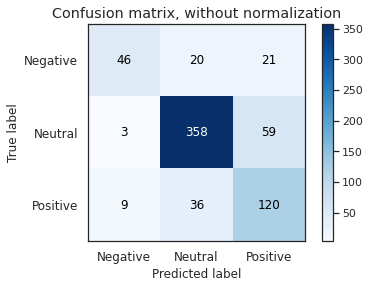

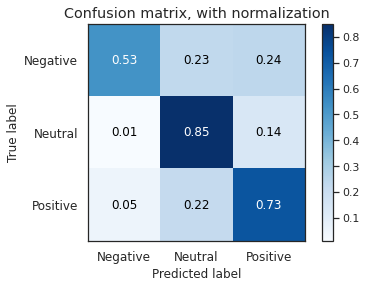

Starting epoch 19
Epoch: 19/30... Step: 10... Loss: 0.279502... Val Loss: 0.590879 Accuracy: 0.794643 F1 Score: 0.722982
Epoch: 19/30... Step: 20... Loss: 0.275788... Val Loss: 0.583317 Accuracy: 0.816964 F1 Score: 0.740327
Epoch: 19/30... Step: 30... Loss: 0.424763... Val Loss: 0.575867 Accuracy: 0.773810 F1 Score: 0.701233
Epoch: 19/30... Step: 40... Loss: 0.278882... Val Loss: 0.579838 Accuracy: 0.809524 F1 Score: 0.727560
Epoch: 19/30... Step: 50... Loss: 0.356472... Val Loss: 0.572557 Accuracy: 0.796131 F1 Score: 0.723204
Epoch: 19/30... Step: 60... Loss: 0.310098... Val Loss: 0.594644 Accuracy: 0.776786 F1 Score: 0.707203
Epoch: 19/30... Step: 70... Loss: 0.268240... Val Loss: 0.579325 Accuracy: 0.802083 F1 Score: 0.730712
Epoch: 19/30... Step: 80... Loss: 0.238454... Val Loss: 0.602665 Accuracy: 0.784226 F1 Score: 0.723262
87 steps in epoch 19

Epoch: 19, Average Accuracy: 0.78422619, Average f1: 0.72326217



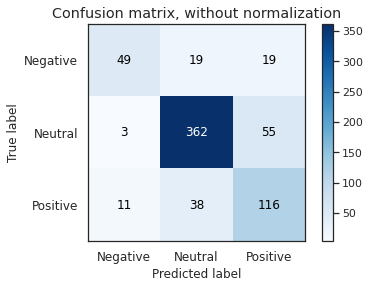

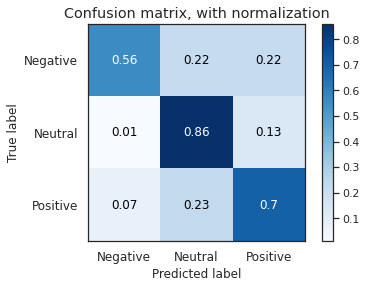

Starting epoch 20
Epoch: 20/30... Step: 10... Loss: 0.282518... Val Loss: 0.581133 Accuracy: 0.799107 F1 Score: 0.734554
Epoch: 20/30... Step: 20... Loss: 0.282311... Val Loss: 0.609527 Accuracy: 0.809524 F1 Score: 0.724002
Epoch: 20/30... Step: 30... Loss: 0.427371... Val Loss: 0.596474 Accuracy: 0.778274 F1 Score: 0.702512
Epoch: 20/30... Step: 40... Loss: 0.232241... Val Loss: 0.575964 Accuracy: 0.809524 F1 Score: 0.734156
Epoch: 20/30... Step: 50... Loss: 0.343741... Val Loss: 0.578443 Accuracy: 0.802083 F1 Score: 0.728119
Epoch: 20/30... Step: 60... Loss: 0.271158... Val Loss: 0.627158 Accuracy: 0.767857 F1 Score: 0.710065
Epoch: 20/30... Step: 70... Loss: 0.246975... Val Loss: 0.602606 Accuracy: 0.811012 F1 Score: 0.730282
Epoch: 20/30... Step: 80... Loss: 0.235856... Val Loss: 0.619762 Accuracy: 0.784226 F1 Score: 0.720165
87 steps in epoch 20

Epoch: 20, Average Accuracy: 0.78422619, Average f1: 0.72016495



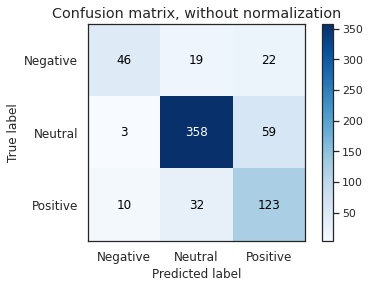

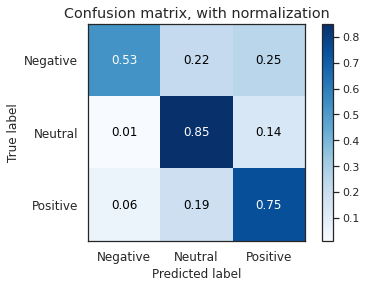

Starting epoch 21
Epoch: 21/30... Step: 10... Loss: 0.252663... Val Loss: 0.584454 Accuracy: 0.788690 F1 Score: 0.723990
Epoch: 21/30... Step: 20... Loss: 0.275124... Val Loss: 0.614314 Accuracy: 0.809524 F1 Score: 0.731465
Epoch: 21/30... Step: 30... Loss: 0.352163... Val Loss: 0.617976 Accuracy: 0.779762 F1 Score: 0.711632
Epoch: 21/30... Step: 40... Loss: 0.241302... Val Loss: 0.589142 Accuracy: 0.815476 F1 Score: 0.751073
Epoch: 21/30... Step: 50... Loss: 0.277361... Val Loss: 0.607773 Accuracy: 0.799107 F1 Score: 0.732347
Epoch: 21/30... Step: 60... Loss: 0.256448... Val Loss: 0.627292 Accuracy: 0.775298 F1 Score: 0.722858
Epoch: 21/30... Step: 70... Loss: 0.224000... Val Loss: 0.611582 Accuracy: 0.809524 F1 Score: 0.738817
Epoch: 21/30... Step: 80... Loss: 0.216688... Val Loss: 0.641999 Accuracy: 0.788690 F1 Score: 0.726871
87 steps in epoch 21

Epoch: 21, Average Accuracy: 0.78869048, Average f1: 0.72687121



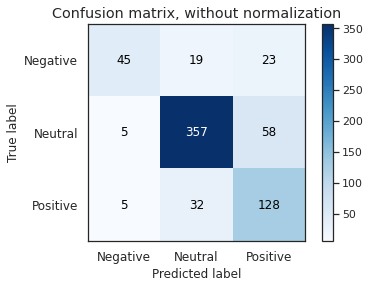

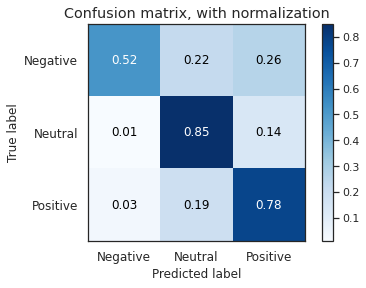

Starting epoch 22
Epoch: 22/30... Step: 10... Loss: 0.255845... Val Loss: 0.597573 Accuracy: 0.788690 F1 Score: 0.721948
Epoch: 22/30... Step: 20... Loss: 0.294477... Val Loss: 0.649447 Accuracy: 0.811012 F1 Score: 0.728494
Epoch: 22/30... Step: 30... Loss: 0.313671... Val Loss: 0.608219 Accuracy: 0.778274 F1 Score: 0.707916
Epoch: 22/30... Step: 40... Loss: 0.202519... Val Loss: 0.598278 Accuracy: 0.827381 F1 Score: 0.768452
Epoch: 22/30... Step: 50... Loss: 0.239769... Val Loss: 0.591410 Accuracy: 0.803571 F1 Score: 0.741754
Epoch: 22/30... Step: 60... Loss: 0.227402... Val Loss: 0.633787 Accuracy: 0.773810 F1 Score: 0.712938
Epoch: 22/30... Step: 70... Loss: 0.208393... Val Loss: 0.616616 Accuracy: 0.802083 F1 Score: 0.729789
Epoch: 22/30... Step: 80... Loss: 0.199823... Val Loss: 0.665706 Accuracy: 0.781250 F1 Score: 0.716966
87 steps in epoch 22

Epoch: 22, Average Accuracy: 0.78125000, Average f1: 0.71696643



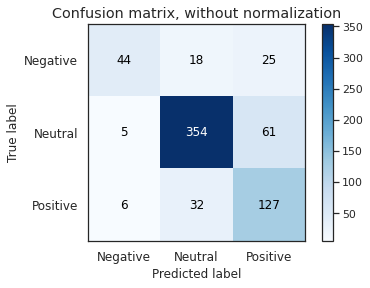

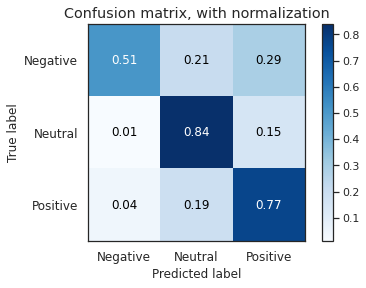

Starting epoch 23
Epoch: 23/30... Step: 10... Loss: 0.231830... Val Loss: 0.620582 Accuracy: 0.794643 F1 Score: 0.739356
Epoch: 23/30... Step: 20... Loss: 0.281610... Val Loss: 0.643557 Accuracy: 0.812500 F1 Score: 0.740847
Epoch: 23/30... Step: 30... Loss: 0.330957... Val Loss: 0.614379 Accuracy: 0.793155 F1 Score: 0.732497
Epoch: 23/30... Step: 40... Loss: 0.175925... Val Loss: 0.600967 Accuracy: 0.806548 F1 Score: 0.735480
Epoch: 23/30... Step: 50... Loss: 0.241223... Val Loss: 0.627462 Accuracy: 0.802083 F1 Score: 0.738078
Epoch: 23/30... Step: 60... Loss: 0.183298... Val Loss: 0.637677 Accuracy: 0.775298 F1 Score: 0.720265
Epoch: 23/30... Step: 70... Loss: 0.209298... Val Loss: 0.636720 Accuracy: 0.808036 F1 Score: 0.730530
Epoch: 23/30... Step: 80... Loss: 0.166840... Val Loss: 0.648412 Accuracy: 0.785714 F1 Score: 0.729742
87 steps in epoch 23

Epoch: 23, Average Accuracy: 0.78571429, Average f1: 0.72974193



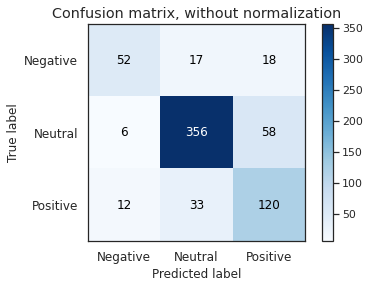

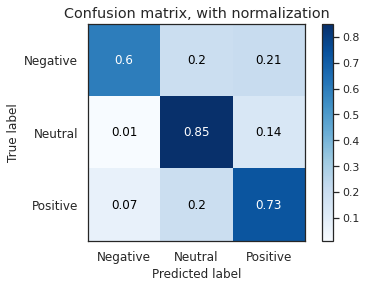

Starting epoch 24
Epoch: 24/30... Step: 10... Loss: 0.201410... Val Loss: 0.628763 Accuracy: 0.800595 F1 Score: 0.746627
Epoch: 24/30... Step: 20... Loss: 0.265630... Val Loss: 0.642152 Accuracy: 0.808036 F1 Score: 0.735429
Epoch: 24/30... Step: 30... Loss: 0.261036... Val Loss: 0.640411 Accuracy: 0.788690 F1 Score: 0.726314
Epoch: 24/30... Step: 40... Loss: 0.173779... Val Loss: 0.627549 Accuracy: 0.806548 F1 Score: 0.736510
Epoch: 24/30... Step: 50... Loss: 0.188338... Val Loss: 0.628352 Accuracy: 0.797619 F1 Score: 0.735876
Epoch: 24/30... Step: 60... Loss: 0.179351... Val Loss: 0.630370 Accuracy: 0.788690 F1 Score: 0.735793
Epoch: 24/30... Step: 70... Loss: 0.175523... Val Loss: 0.635908 Accuracy: 0.803571 F1 Score: 0.734995
Epoch: 24/30... Step: 80... Loss: 0.164966... Val Loss: 0.705086 Accuracy: 0.781250 F1 Score: 0.724028
87 steps in epoch 24

Epoch: 24, Average Accuracy: 0.78125000, Average f1: 0.72402841



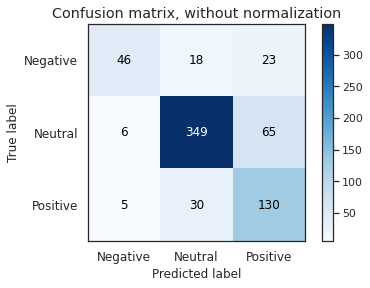

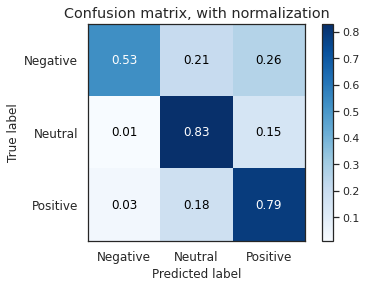

Starting epoch 25
Epoch: 25/30... Step: 10... Loss: 0.203928... Val Loss: 0.635799 Accuracy: 0.802083 F1 Score: 0.751255
Epoch: 25/30... Step: 20... Loss: 0.282484... Val Loss: 0.654148 Accuracy: 0.816964 F1 Score: 0.745417
Epoch: 25/30... Step: 30... Loss: 0.252574... Val Loss: 0.641879 Accuracy: 0.788690 F1 Score: 0.736741
Epoch: 25/30... Step: 40... Loss: 0.146485... Val Loss: 0.624180 Accuracy: 0.808036 F1 Score: 0.745717
Epoch: 25/30... Step: 50... Loss: 0.157937... Val Loss: 0.633975 Accuracy: 0.805060 F1 Score: 0.747485
Epoch: 25/30... Step: 60... Loss: 0.134762... Val Loss: 0.633928 Accuracy: 0.790179 F1 Score: 0.739579
Epoch: 25/30... Step: 70... Loss: 0.143422... Val Loss: 0.647015 Accuracy: 0.803571 F1 Score: 0.740171
Epoch: 25/30... Step: 80... Loss: 0.125507... Val Loss: 0.695213 Accuracy: 0.785714 F1 Score: 0.726751
87 steps in epoch 25

Epoch: 25, Average Accuracy: 0.78571429, Average f1: 0.72675138



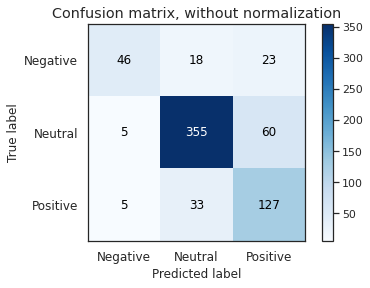

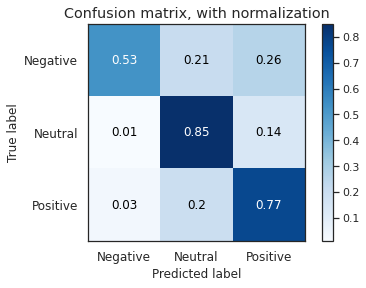

Starting epoch 26
Epoch: 26/30... Step: 10... Loss: 0.211781... Val Loss: 0.645316 Accuracy: 0.794643 F1 Score: 0.736017
Epoch: 26/30... Step: 20... Loss: 0.237484... Val Loss: 0.676272 Accuracy: 0.819940 F1 Score: 0.752562
Epoch: 26/30... Step: 30... Loss: 0.214971... Val Loss: 0.635670 Accuracy: 0.794643 F1 Score: 0.734677
Epoch: 26/30... Step: 40... Loss: 0.163832... Val Loss: 0.649142 Accuracy: 0.785714 F1 Score: 0.716222
Epoch: 26/30... Step: 50... Loss: 0.207019... Val Loss: 0.657207 Accuracy: 0.809524 F1 Score: 0.740912
Epoch: 26/30... Step: 60... Loss: 0.133620... Val Loss: 0.690605 Accuracy: 0.769345 F1 Score: 0.728210
Epoch: 26/30... Step: 70... Loss: 0.142141... Val Loss: 0.661623 Accuracy: 0.813988 F1 Score: 0.745192
Epoch: 26/30... Step: 80... Loss: 0.120360... Val Loss: 0.707979 Accuracy: 0.782738 F1 Score: 0.743317
87 steps in epoch 26

Epoch: 26, Average Accuracy: 0.78273810, Average f1: 0.74331726



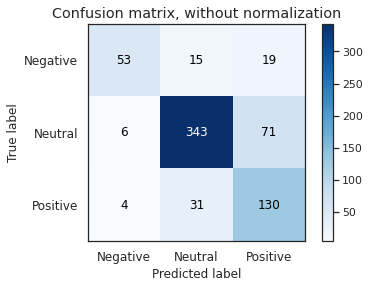

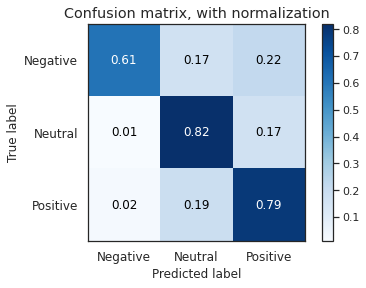

Starting epoch 27
Epoch: 27/30... Step: 10... Loss: 0.208502... Val Loss: 0.656915 Accuracy: 0.794643 F1 Score: 0.740255
Epoch: 27/30... Step: 20... Loss: 0.298537... Val Loss: 0.722107 Accuracy: 0.796131 F1 Score: 0.722841
Epoch: 27/30... Step: 30... Loss: 0.317120... Val Loss: 0.669465 Accuracy: 0.811012 F1 Score: 0.743858
Epoch: 27/30... Step: 40... Loss: 0.367904... Val Loss: 0.691907 Accuracy: 0.776786 F1 Score: 0.723371
Epoch: 27/30... Step: 50... Loss: 0.121637... Val Loss: 0.664518 Accuracy: 0.812500 F1 Score: 0.749327
Epoch: 27/30... Step: 60... Loss: 0.130150... Val Loss: 0.711485 Accuracy: 0.769345 F1 Score: 0.727696
Epoch: 27/30... Step: 70... Loss: 0.114206... Val Loss: 0.679191 Accuracy: 0.813988 F1 Score: 0.745904
Epoch: 27/30... Step: 80... Loss: 0.085790... Val Loss: 0.714114 Accuracy: 0.788690 F1 Score: 0.748888
87 steps in epoch 27

Epoch: 27, Average Accuracy: 0.78869048, Average f1: 0.74888751



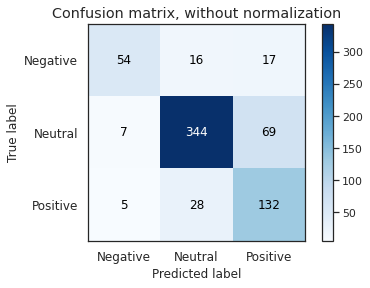

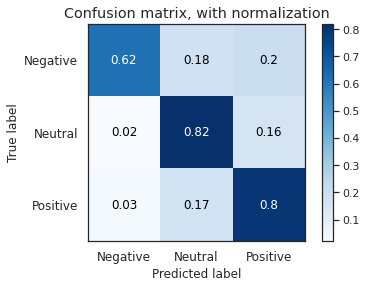

Starting epoch 28
Epoch: 28/30... Step: 10... Loss: 0.180256... Val Loss: 0.657851 Accuracy: 0.800595 F1 Score: 0.739877
Epoch: 28/30... Step: 20... Loss: 0.271551... Val Loss: 0.701597 Accuracy: 0.785714 F1 Score: 0.723059
Epoch: 28/30... Step: 30... Loss: 0.397264... Val Loss: 0.703449 Accuracy: 0.808036 F1 Score: 0.737050
Epoch: 28/30... Step: 40... Loss: 0.698210... Val Loss: 0.817580 Accuracy: 0.732143 F1 Score: 0.690726
Epoch: 28/30... Step: 50... Loss: 0.107806... Val Loss: 0.683863 Accuracy: 0.815476 F1 Score: 0.747204
Epoch: 28/30... Step: 60... Loss: 0.135852... Val Loss: 0.701988 Accuracy: 0.775298 F1 Score: 0.739333
Epoch: 28/30... Step: 70... Loss: 0.113016... Val Loss: 0.678115 Accuracy: 0.805060 F1 Score: 0.730825
Epoch: 28/30... Step: 80... Loss: 0.063475... Val Loss: 0.673420 Accuracy: 0.791667 F1 Score: 0.741508
87 steps in epoch 28

Epoch: 28, Average Accuracy: 0.79166667, Average f1: 0.74150752



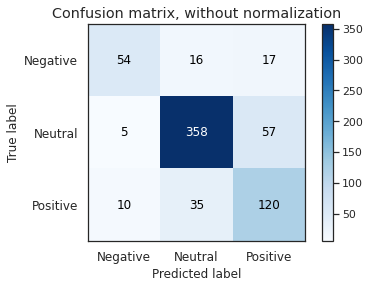

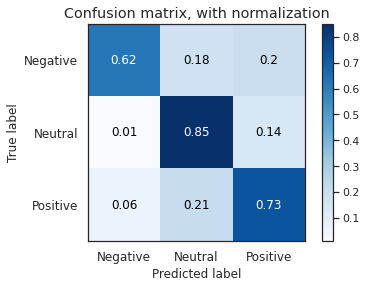

Starting epoch 29
Epoch: 29/30... Step: 10... Loss: 0.212859... Val Loss: 0.656941 Accuracy: 0.813988 F1 Score: 0.751489
Epoch: 29/30... Step: 20... Loss: 0.247598... Val Loss: 0.662637 Accuracy: 0.794643 F1 Score: 0.748973
Epoch: 29/30... Step: 30... Loss: 0.439365... Val Loss: 0.668111 Accuracy: 0.818452 F1 Score: 0.754814
Epoch: 29/30... Step: 40... Loss: 0.589069... Val Loss: 0.836807 Accuracy: 0.721726 F1 Score: 0.682885
Epoch: 29/30... Step: 50... Loss: 0.117321... Val Loss: 0.668555 Accuracy: 0.806548 F1 Score: 0.734559
Epoch: 29/30... Step: 60... Loss: 0.146168... Val Loss: 0.742460 Accuracy: 0.778274 F1 Score: 0.724706
Epoch: 29/30... Step: 70... Loss: 0.084709... Val Loss: 0.670801 Accuracy: 0.811012 F1 Score: 0.747352
Epoch: 29/30... Step: 80... Loss: 0.141155... Val Loss: 0.664092 Accuracy: 0.794643 F1 Score: 0.737189
87 steps in epoch 29

Epoch: 29, Average Accuracy: 0.79464286, Average f1: 0.73718933



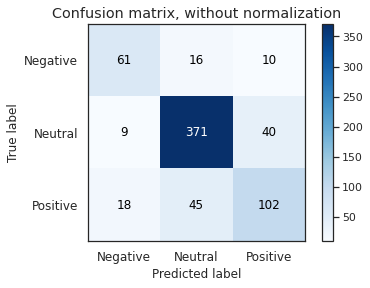

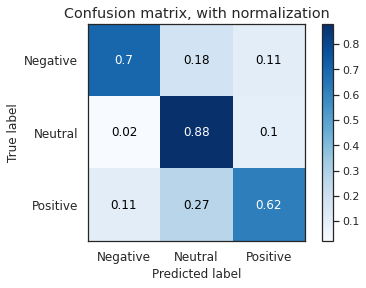

Starting epoch 30
Epoch: 30/30... Step: 10... Loss: 0.189810... Val Loss: 0.670352 Accuracy: 0.803571 F1 Score: 0.745110
Epoch: 30/30... Step: 20... Loss: 0.256893... Val Loss: 0.657303 Accuracy: 0.796131 F1 Score: 0.744892
Epoch: 30/30... Step: 30... Loss: 0.444689... Val Loss: 0.695105 Accuracy: 0.811012 F1 Score: 0.738160
Epoch: 30/30... Step: 40... Loss: 0.384661... Val Loss: 0.756844 Accuracy: 0.761905 F1 Score: 0.718382
Epoch: 30/30... Step: 50... Loss: 0.080327... Val Loss: 0.668832 Accuracy: 0.806548 F1 Score: 0.737412
Epoch: 30/30... Step: 60... Loss: 0.107771... Val Loss: 0.722083 Accuracy: 0.787202 F1 Score: 0.739557
Epoch: 30/30... Step: 70... Loss: 0.064069... Val Loss: 0.688762 Accuracy: 0.805060 F1 Score: 0.743453
Epoch: 30/30... Step: 80... Loss: 0.123749... Val Loss: 0.687649 Accuracy: 0.800595 F1 Score: 0.744084
87 steps in epoch 30

Epoch: 30, Average Accuracy: 0.80059524, Average f1: 0.74408399



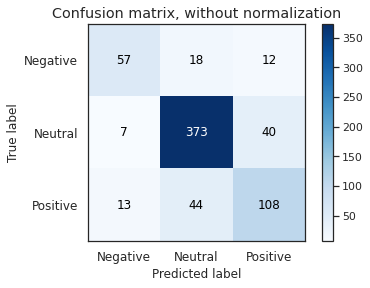

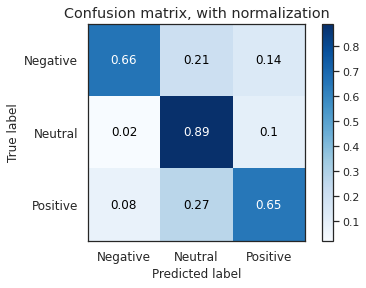

In [59]:
train_model(model)

# E. BERT Model

<table><tr><td><img src="./docs/bert_model.png" width=400></td><td><img src="./docs/transformer.png" width=550></td></tr></table>

![Comparison](./docs/bert-vs-openai-vs-elmo.png)

### Define functions

In [60]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset)
#from transformers import *
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
from transformers import AdamW as AdamW_Bert, get_linear_schedule_with_warmup

In [61]:
class InputFeature(object):
    """ A single training/test data class """
    def __init__(self, id, input_ids, masks, segments, label=None):
        self.id = id
        self.features = {
            'input_ids': input_ids,
            'input_mask': masks,
            'segment_ids': segments
        }
        self.label = label

In [62]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [63]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

def bert_encoder(text, max_len=80):
    """ Return embedded text vector as a list in max_len with a mask list"""
    text_token = tokenizer.tokenize(text)
    text_token = text_token[:max_len-2]
    text_token = ["[CLS]"] + text_token + ["[SEP]"]
    text_ids = tokenizer.convert_tokens_to_ids(text_token)
    text_ids += [0] * (max_len - len(text_token))
    pad_masks = [1] * len(text_token) + [0] * (max_len - len(text_token))
    segment_ids = [0] * len(text_token) + [0] * (max_len - len(text_token))
    
    return text_ids, pad_masks, segment_ids

### Input Data

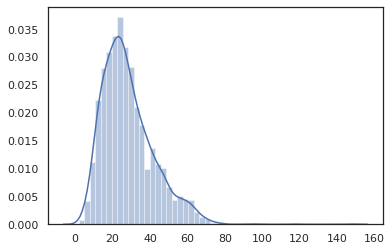

In [64]:
# Check the distribution to decide the maximum length
sns.distplot([len(tokenizer.tokenize(text)) for text in train_df['sentence']])

In [65]:
# Prepare training data
train_set = []
max_seq_length = 48

for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    input_ids, masks, segments = bert_encoder(row['sentence'], max_seq_length)
    train_set.append(InputFeature(row.index, input_ids, masks, segments, int(row['label'])))    

train_labels = train_df['label'].astype(int).values

# numpy array to split train and valid within Fold later
train_valid_input_ids = np.array([data.features['input_ids'] for data in train_set])
train_valid_input_masks = np.array([data.features['input_mask'] for data in train_set])
train_valid_segment_ids =np.array([data.features['segment_ids'] for data in train_set])
train_valid_labels = np.array([data.label for data in train_set])

oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

### Define Bert Model

In [66]:
class BertTextClassifier(nn.Module):
    def __init__(self, hidden_size, dense_size, output_size, dropout=0.1):
        """
        Initialize the model
        """
        super().__init__()
        self.output_size = output_size
        self.dropout = dropout
        
        self.bert = BertModel.from_pretrained('bert-base-uncased',  
                                        output_hidden_states=True,
                                        output_attentions=True)
        for param in self.bert.parameters():
            param.requires_grad = True
        self.weights = nn.Parameter(torch.rand(13, 1))
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.fc2 = nn.Linear(dense_size, output_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids):
        """
        Perform a forward pass of the model on nn_input
        """
        
        all_hidden_states, all_attentions = self.bert(input_ids)[-2:]
        batch_size = input_ids.shape[0]
        ht_cls = torch.cat(all_hidden_states)[:, :1, :].view(13, batch_size, 1, 768)
        atten = torch.sum(ht_cls * self.weights.view(13, 1, 1, 1), dim=[1, 3])
        atten = F.softmax(atten.view(-1), dim=0)
        feature = torch.sum(ht_cls * atten.view(13, 1, 1, 1), dim=[0, 2])        
        # Dense layer
        dense_out = self.fc1(self.dropout(feature))
        # Concatinate the dense output and meta inputs
        #  concat_layer = torch.cat((dense_out, nn_input_meta.float()), 1)
        out = self.fc2(dense_out)
        # out = self.fc(self.dropout(feature))

        return out

In [67]:
# Check how BertTokenizer works
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True)).unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

print(input_ids)
print(outputs) # The last hidden-state is the first element of the output tuple



tensor([[  101,  7592,  1010,  2026,  3899,  2003, 10140,   102]])
(tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.7003, -0.1815,  0.3297,  ..., -0.4838,  0.0680,  0.8901],
         [-1.0355, -0.2567, -0.0317,  ...,  0.3197,  0.3999,  0.1795],
         [ 0.6080,  0.2610, -0.3131,  ...,  0.0311, -0.6283, -0.1994]]],
       grad_fn=<NativeLayerNormBackward>), tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2184e-02,  5.7299e-01,  6.2331e-02,  5.9586e-02, -9.9965e-01,
          5.0146e-02,  4.4756e-01,  9.7612e-01,  3.3989e-02,  8.4494e-01,
         -3.6905e-01,  9.8649e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.7372e-01,
  

In [68]:
# Test Tokenizer - Own Implementation
# bert_model = BertTextClassifier(768, 128, 3, dropout=0.1)
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
text_ids, pad_masks, segment_ids = bert_encoder("Hello, my dog is cute")
print('text_ids: \n', text_ids)
print('text_ids (torch.tensor): \n', torch.tensor(text_ids))
text_ids = torch.tensor(text_ids).unsqueeze(0)
print('text_ids (unsqueezed): \n', text_ids)
pad_masks = torch.tensor(pad_masks).unsqueeze(0)
#print('pad_masks: ',pad_masks)
segment_ids = torch.tensor(segment_ids).unsqueeze(0)
#print('segment_ids: ',segment_ids)

#outputs = bert_model(text_ids)
outputs = bert_model(text_ids, pad_masks, segment_ids)

print(len(outputs))
print('outputs: \n',outputs)
print('outputs(detached): \n', outputs[0].detach())


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

text_ids: 
 [101, 7592, 1010, 2026, 3899, 2003, 10140, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
text_ids (torch.tensor): 
 tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
text_ids (unsqueezed): 
 tensor([[  101,  7592,  1010,  2026,  3899,  20

### Train

In [69]:
# Hyperparameters
learning_rate = 1e-4
num_epochs = 20
batch_size = 32
patience = 7
warm_up_proportion = 0.1
max_grad_norm = 1.0
file_name = 'model'
bert_hidden_size = 768
bert_dense_size = 128

In [70]:
def train_bert(fold, train_indices, valid_indices):
    
    logger.info('================     fold {}        ==============='.format(fold))
    
    # Train Data in Tensor
    train_input_ids = torch.tensor(train_valid_input_ids[train_indices], dtype=torch.long)
    train_input_mask = torch.tensor(train_valid_input_masks[train_indices], dtype=torch.long)
    train_segment_ids = torch.tensor(train_valid_segment_ids[train_indices], dtype=torch.long)
    train_label = torch.tensor(train_valid_labels[train_indices], dtype=torch.long)
    
    # Validation Data in Tensor
    valid_input_ids = torch.tensor(train_valid_input_ids[valid_indices], dtype=torch.long)
    valid_input_mask = torch.tensor(train_valid_input_masks[valid_indices], dtype=torch.long)
    valid_segment_ids = torch.tensor(train_valid_segment_ids[valid_indices], dtype=torch.long)
    valid_label = torch.tensor(train_valid_labels[valid_indices], dtype=torch.long)

    # Load data into TensorDataset
    train = torch.utils.data.TensorDataset(train_input_ids, train_input_mask, train_segment_ids, train_label)
    valid = torch.utils.data.TensorDataset(valid_input_ids, valid_input_mask, valid_segment_ids, valid_label)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

    # Set Model
    #bert_model = BertTextClassifier(bert_hidden_size, bert_dense_size, 3, dropout=0.1)
    bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    bert_model = bert_model.to(device)
    
    ## Set Loss Function
    ## If we use BertForSequenceClassification, Loss function is already included and no need to define.
    # Loss Function - use Cross Entropy as binary classification
    # loss_fn = torch.nn.CrossEntropyLoss()

    ## Set Optimizer
    ## Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    ## If we use torch.optim.Adam, set with parameter groups like this:
    # param_optimizer = list(model.named_parameters())
    # no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    # optimizer_grouped_parameters = [
    #     {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    #     {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]
    # optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=1e-6)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {}'.format(num_total_opt_steps))
    optimizer = AdamW_Bert(bert_model.parameters(), lr=learning_rate, correct_bias=False) # To reproduce BertAdam specific behavior set correct_bias=False
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    bert_model.train()

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((valid_label.size(0), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}        ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Move batch data to device
            batch = tuple(t.to(device) for t in batch)

            # Bert input features and labels from batch
            x_ids, x_mask, x_sids, y_truth = batch

            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = bert_model(x_ids, labels=y_truth)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(bert_model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        bert_model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        valid_preds_fold = np.zeros((valid_label.size(0), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                batch = tuple(t.to(device) for t in batch)
                x_ids, x_mask, x_sids, y_truth = batch
                loss, logits = bert_model(x_ids, labels=y_truth)
                val_loss += loss.item() / len(valid_loader)
                valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
            valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_preds_fold, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = valid_preds_fold
            torch.save(bert_model.state_dict(), output_dir + 'finphrase_model_fold_{}.dict'.format(fold))
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.5f, f1: %5f, best_f1: %.5f\n, last lr: %.6f' %
            (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()  

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        bert_model.train()

    # Once all epochs are done, take the best model of the fold
    valid_preds_fold = np.zeros((valid_label.size(0), 3))
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'r-o')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    # Load the best model
    bert_model.load_state_dict(torch.load(output_dir + 'finphrase_model_fold_{}.dict'.format(fold)))
    # Set Evaluation Mode
    bert_model.eval()
    
    # Prediction on the validation set
    with torch.no_grad():
        for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            batch = tuple(t.to(device) for t in batch)
            x_ids, x_mask, x_sids, y_truth = batch
            loss, logits = bert_model(x_ids, labels=y_truth)
            valid_preds_fold[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()

    # Check the metrics for the validation set
    valid_best = valid_preds_fold
    oof_train[valid_indices] = valid_best
    acc, f1 = metric(train_valid_labels[valid_indices], np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in train_valid_labels[valid_indices]]
    predicted_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, predicted_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()

[2020-07-19 07:33:49,455][INFO] ## ================     fold 0        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 07:34:54,040][INFO] ## epoch: 1, train loss: 0.54908968, valid loss: 0.28303163, acc: 0.92292, f1: 0.874960, best_f1: 0.87496
, last lr: 0.000050
[2020-07-19 07:34:54,157][INFO] ## ================     epoch 2        ===============


[2020-07-19 07:35:48,270][INFO] ## epoch: 2, train loss: 0.35144848, valid loss: 0.40655887, acc: 0.88641, f1: 0.853246, best_f1: 0.87496
, last lr: 0.000100
[2020-07-19 07:35:48,397][INFO] ## ================     epoch 3        ===============


[2020-07-19 07:36:42,420][INFO] ## epoch: 3, train loss: 0.28187872, valid loss: 0.24085639, acc: 0.91886, f1: 0.872436, best_f1: 0.87496
, last lr: 0.000094
[2020-07-19 07:36:42,542][INFO] ## ================     epoch 4        ===============


[2020-07-19 07:37:36,460][INFO] ## epoch: 4, train loss: 0.20705744, valid loss: 0.30306877, acc: 0.90669, f1: 0.859034, best_f1: 0.87496
, last lr: 0.000089
[2020-07-19 07:37:36,584][INFO] ## ================     epoch 5        ===============


[2020-07-19 07:38:32,080][INFO] ## epoch: 5, train loss: 0.15353216, valid loss: 0.34783936, acc: 0.91886, f1: 0.883583, best_f1: 0.88358
, last lr: 0.000083
[2020-07-19 07:38:32,201][INFO] ## ================     epoch 6        ===============


[2020-07-19 07:39:26,045][INFO] ## epoch: 6, train loss: 0.13194182, valid loss: 0.34220242, acc: 0.91278, f1: 0.883335, best_f1: 0.88358
, last lr: 0.000078
[2020-07-19 07:39:26,167][INFO] ## ================     epoch 7        ===============


[2020-07-19 07:40:19,855][INFO] ## epoch: 7, train loss: 0.09805624, valid loss: 0.40662262, acc: 0.92292, f1: 0.880692, best_f1: 0.88358
, last lr: 0.000072
[2020-07-19 07:40:19,978][INFO] ## ================     epoch 8        ===============


[2020-07-19 07:41:13,511][INFO] ## epoch: 8, train loss: 0.09483729, valid loss: 0.72889746, acc: 0.85396, f1: 0.793383, best_f1: 0.88358
, last lr: 0.000067
[2020-07-19 07:41:13,634][INFO] ## ================     epoch 9        ===============


[2020-07-19 07:42:08,929][INFO] ## epoch: 9, train loss: 0.07932018, valid loss: 0.47228571, acc: 0.91886, f1: 0.888596, best_f1: 0.88860
, last lr: 0.000061
[2020-07-19 07:42:09,052][INFO] ## ================     epoch 10        ===============


[2020-07-19 07:43:04,317][INFO] ## epoch: 10, train loss: 0.05088486, valid loss: 0.30232483, acc: 0.94320, f1: 0.920500, best_f1: 0.92050
, last lr: 0.000056
[2020-07-19 07:43:04,438][INFO] ## ================     epoch 11        ===============


[2020-07-19 07:43:57,939][INFO] ## epoch: 11, train loss: 0.03548101, valid loss: 0.32245694, acc: 0.93712, f1: 0.915138, best_f1: 0.92050
, last lr: 0.000050
[2020-07-19 07:43:58,066][INFO] ## ================     epoch 12        ===============


[2020-07-19 07:44:51,452][INFO] ## epoch: 12, train loss: 0.02228667, valid loss: 0.46348267, acc: 0.92901, f1: 0.905573, best_f1: 0.92050
, last lr: 0.000044
[2020-07-19 07:44:51,574][INFO] ## ================     epoch 13        ===============


[2020-07-19 07:45:44,981][INFO] ## epoch: 13, train loss: 0.01387117, valid loss: 0.36523180, acc: 0.93103, f1: 0.912563, best_f1: 0.92050
, last lr: 0.000039
[2020-07-19 07:45:45,102][INFO] ## ================     epoch 14        ===============


[2020-07-19 07:46:40,191][INFO] ## epoch: 14, train loss: 0.01083277, valid loss: 0.38284516, acc: 0.94118, f1: 0.926223, best_f1: 0.92622
, last lr: 0.000033
[2020-07-19 07:46:40,316][INFO] ## ================     epoch 15        ===============


[2020-07-19 07:47:33,756][INFO] ## epoch: 15, train loss: 0.00735976, valid loss: 0.42255073, acc: 0.92901, f1: 0.904670, best_f1: 0.92622
, last lr: 0.000028
[2020-07-19 07:47:33,879][INFO] ## ================     epoch 16        ===============


[2020-07-19 07:48:27,161][INFO] ## epoch: 16, train loss: 0.00335162, valid loss: 0.44343288, acc: 0.93915, f1: 0.922736, best_f1: 0.92622
, last lr: 0.000022
[2020-07-19 07:48:27,285][INFO] ## ================     epoch 17        ===============


[2020-07-19 07:49:20,506][INFO] ## epoch: 17, train loss: 0.00159373, valid loss: 0.44977004, acc: 0.93712, f1: 0.920763, best_f1: 0.92622
, last lr: 0.000017
[2020-07-19 07:49:20,630][INFO] ## ================     epoch 18        ===============


[2020-07-19 07:50:13,908][INFO] ## epoch: 18, train loss: 0.00037960, valid loss: 0.46580646, acc: 0.93509, f1: 0.916438, best_f1: 0.92622
, last lr: 0.000011
[2020-07-19 07:50:14,036][INFO] ## ================     epoch 19        ===============


[2020-07-19 07:51:07,323][INFO] ## epoch: 19, train loss: 0.00031167, valid loss: 0.47205978, acc: 0.93712, f1: 0.919073, best_f1: 0.92622
, last lr: 0.000006
[2020-07-19 07:51:07,448][INFO] ## ================     epoch 20        ===============


[2020-07-19 07:52:00,761][INFO] ## epoch: 20, train loss: 0.00025665, valid loss: 0.47315292, acc: 0.93712, f1: 0.919073, best_f1: 0.92622
, last lr: 0.000000
No handles with labels found to put in legend.


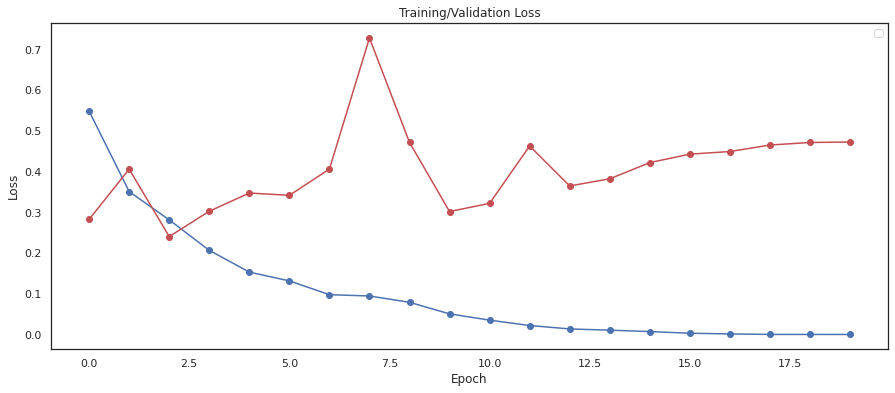

[2020-07-19 07:52:04,773][INFO] ## epoch: best, acc: 0.94117647, f1: 0.92622311, best_f1: 0.92622311



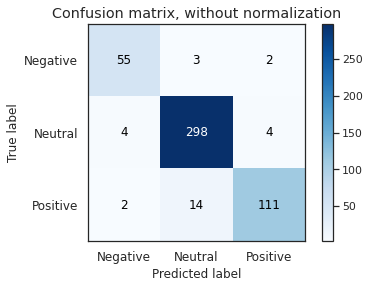

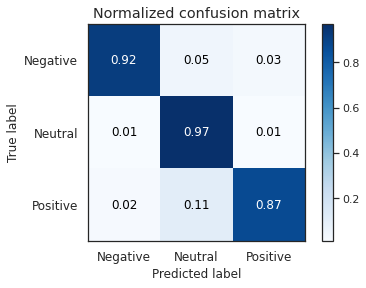

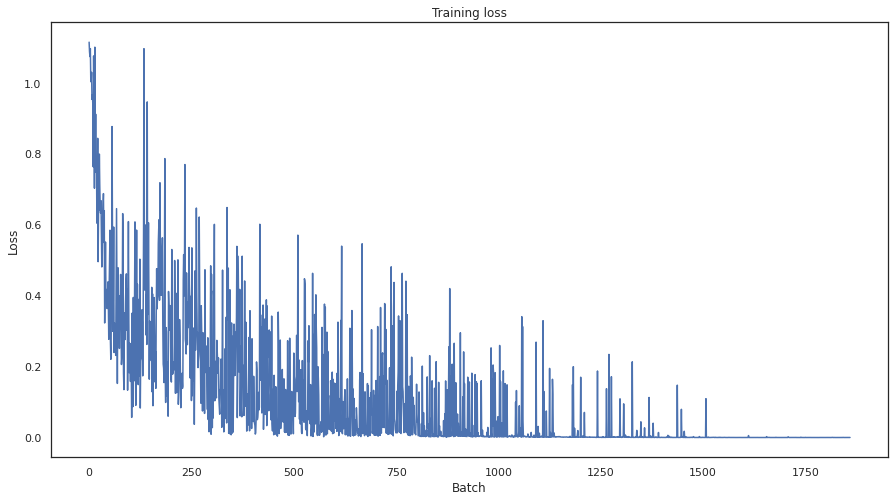

[2020-07-19 07:52:05,621][INFO] ## ================     fold 1        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 07:53:05,128][INFO] ## epoch: 1, train loss: 0.54737060, valid loss: 0.36689344, acc: 0.89452, f1: 0.863936, best_f1: 0.86394
, last lr: 0.000050
[2020-07-19 07:53:05,243][INFO] ## ================     epoch 2        ===============


[2020-07-19 07:54:00,910][INFO] ## epoch: 2, train loss: 0.25990635, valid loss: 0.33208563, acc: 0.91075, f1: 0.887850, best_f1: 0.88785
, last lr: 0.000100
[2020-07-19 07:54:01,036][INFO] ## ================     epoch 3        ===============


[2020-07-19 07:54:55,013][INFO] ## epoch: 3, train loss: 0.26858134, valid loss: 0.39240371, acc: 0.89858, f1: 0.876653, best_f1: 0.88785
, last lr: 0.000094
[2020-07-19 07:54:55,136][INFO] ## ================     epoch 4        ===============


[2020-07-19 07:55:48,965][INFO] ## epoch: 4, train loss: 0.16491853, valid loss: 0.49375748, acc: 0.89249, f1: 0.874422, best_f1: 0.88785
, last lr: 0.000089
[2020-07-19 07:55:49,086][INFO] ## ================     epoch 5        ===============


[2020-07-19 07:56:42,751][INFO] ## epoch: 5, train loss: 0.14877373, valid loss: 0.39012081, acc: 0.90467, f1: 0.878687, best_f1: 0.88785
, last lr: 0.000083
[2020-07-19 07:56:42,872][INFO] ## ================     epoch 6        ===============


[2020-07-19 07:57:36,459][INFO] ## epoch: 6, train loss: 0.09695114, valid loss: 0.55459202, acc: 0.89452, f1: 0.859837, best_f1: 0.88785
, last lr: 0.000078
[2020-07-19 07:57:36,579][INFO] ## ================     epoch 7        ===============


[2020-07-19 07:58:30,196][INFO] ## epoch: 7, train loss: 0.07344147, valid loss: 0.62153480, acc: 0.89047, f1: 0.862138, best_f1: 0.88785
, last lr: 0.000072
[2020-07-19 07:58:30,317][INFO] ## ================     epoch 8        ===============


[2020-07-19 07:59:23,717][INFO] ## epoch: 8, train loss: 0.04563899, valid loss: 0.57504897, acc: 0.90061, f1: 0.874847, best_f1: 0.88785
, last lr: 0.000067
[2020-07-19 07:59:23,840][INFO] ## ================     epoch 9        ===============


[2020-07-19 08:00:17,281][INFO] ## epoch: 9, train loss: 0.04671730, valid loss: 0.52751799, acc: 0.90467, f1: 0.870715, best_f1: 0.88785
, last lr: 0.000061
No handles with labels found to put in legend.


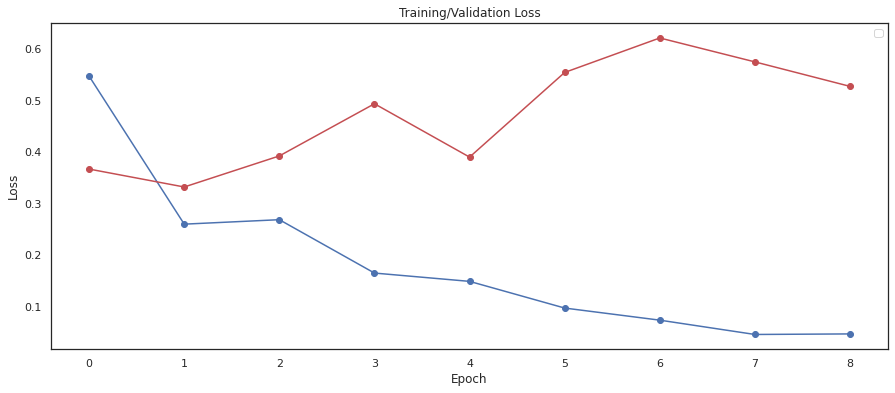

[2020-07-19 08:00:21,252][INFO] ## epoch: best, acc: 0.91075051, f1: 0.88785042, best_f1: 0.88785042



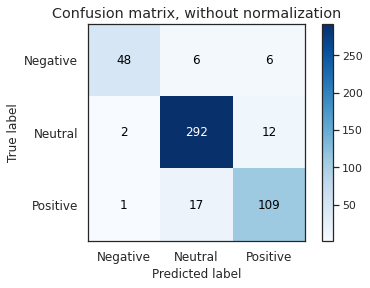

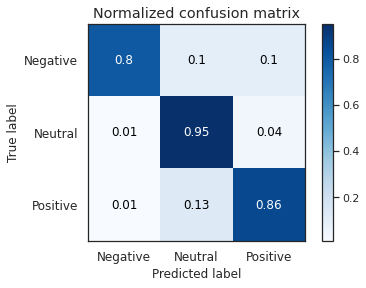

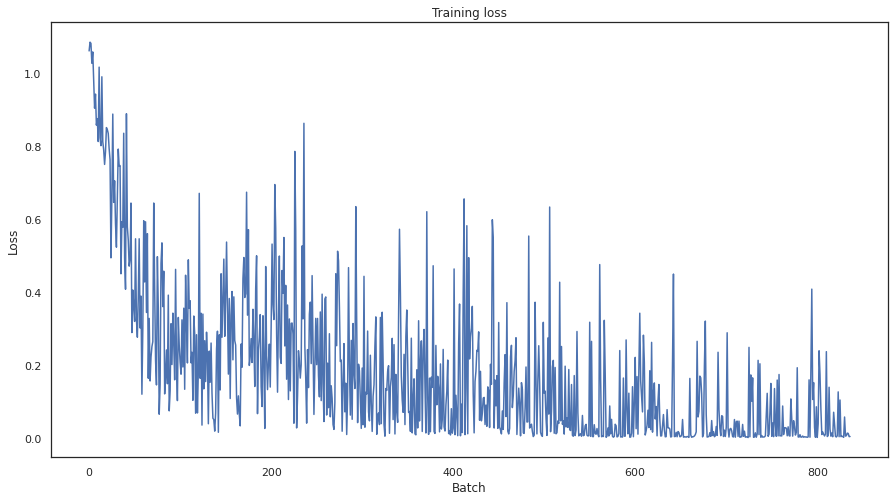

[2020-07-19 08:00:22,077][INFO] ## ================     fold 2        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 08:01:21,340][INFO] ## epoch: 1, train loss: 0.64828263, valid loss: 0.35895601, acc: 0.87627, f1: 0.833085, best_f1: 0.83308
, last lr: 0.000050
[2020-07-19 08:01:21,457][INFO] ## ================     epoch 2        ===============


[2020-07-19 08:02:15,456][INFO] ## epoch: 2, train loss: 0.32023872, valid loss: 0.43475705, acc: 0.86410, f1: 0.826034, best_f1: 0.83308
, last lr: 0.000100
[2020-07-19 08:02:15,577][INFO] ## ================     epoch 3        ===============


[2020-07-19 08:03:09,627][INFO] ## epoch: 3, train loss: 0.28519108, valid loss: 0.45237863, acc: 0.86207, f1: 0.822744, best_f1: 0.83308
, last lr: 0.000094
[2020-07-19 08:03:09,748][INFO] ## ================     epoch 4        ===============


[2020-07-19 08:04:05,442][INFO] ## epoch: 4, train loss: 0.28407622, valid loss: 0.46089633, acc: 0.88032, f1: 0.839674, best_f1: 0.83967
, last lr: 0.000089
[2020-07-19 08:04:05,573][INFO] ## ================     epoch 5        ===============


[2020-07-19 08:04:59,500][INFO] ## epoch: 5, train loss: 0.24715679, valid loss: 0.46977011, acc: 0.83570, f1: 0.788772, best_f1: 0.83967
, last lr: 0.000083
[2020-07-19 08:04:59,621][INFO] ## ================     epoch 6        ===============


[2020-07-19 08:05:55,111][INFO] ## epoch: 6, train loss: 0.17414862, valid loss: 0.52540179, acc: 0.89249, f1: 0.865931, best_f1: 0.86593
, last lr: 0.000078
[2020-07-19 08:05:55,238][INFO] ## ================     epoch 7        ===============


[2020-07-19 08:06:48,941][INFO] ## epoch: 7, train loss: 0.14121709, valid loss: 0.55437407, acc: 0.88438, f1: 0.841838, best_f1: 0.86593
, last lr: 0.000072
[2020-07-19 08:06:49,063][INFO] ## ================     epoch 8        ===============


[2020-07-19 08:07:42,684][INFO] ## epoch: 8, train loss: 0.13534723, valid loss: 0.53994881, acc: 0.86207, f1: 0.836569, best_f1: 0.86593
, last lr: 0.000067
[2020-07-19 08:07:42,806][INFO] ## ================     epoch 9        ===============


[2020-07-19 08:08:36,449][INFO] ## epoch: 9, train loss: 0.11870876, valid loss: 0.64598378, acc: 0.87627, f1: 0.837070, best_f1: 0.86593
, last lr: 0.000061
[2020-07-19 08:08:36,573][INFO] ## ================     epoch 10        ===============


[2020-07-19 08:09:30,096][INFO] ## epoch: 10, train loss: 0.10052371, valid loss: 0.47256411, acc: 0.88844, f1: 0.847793, best_f1: 0.86593
, last lr: 0.000056
[2020-07-19 08:09:30,217][INFO] ## ================     epoch 11        ===============


[2020-07-19 08:10:23,724][INFO] ## epoch: 11, train loss: 0.07804061, valid loss: 0.51291585, acc: 0.89858, f1: 0.861390, best_f1: 0.86593
, last lr: 0.000050
[2020-07-19 08:10:23,847][INFO] ## ================     epoch 12        ===============


[2020-07-19 08:11:17,467][INFO] ## epoch: 12, train loss: 0.06938327, valid loss: 0.58697395, acc: 0.89452, f1: 0.860013, best_f1: 0.86593
, last lr: 0.000044
[2020-07-19 08:11:17,592][INFO] ## ================     epoch 13        ===============


[2020-07-19 08:12:11,154][INFO] ## epoch: 13, train loss: 0.07096942, valid loss: 0.53847140, acc: 0.89452, f1: 0.861602, best_f1: 0.86593
, last lr: 0.000039
No handles with labels found to put in legend.


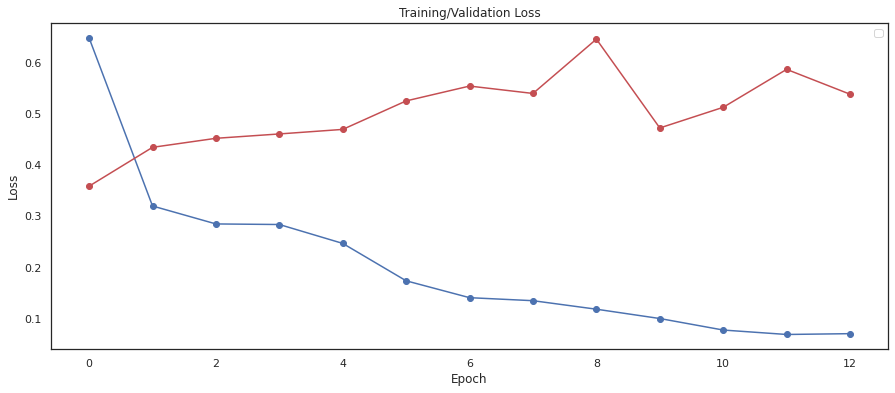

[2020-07-19 08:12:15,148][INFO] ## epoch: best, acc: 0.89249493, f1: 0.86593070, best_f1: 0.86593070



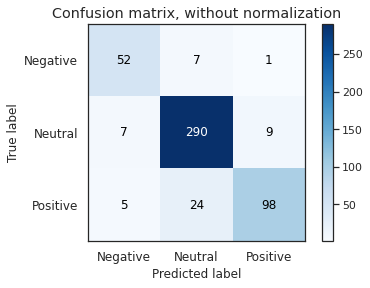

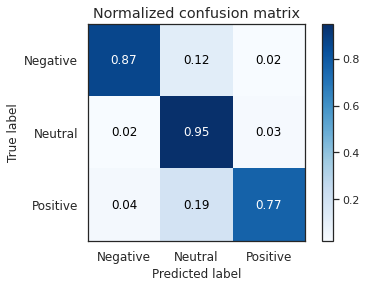

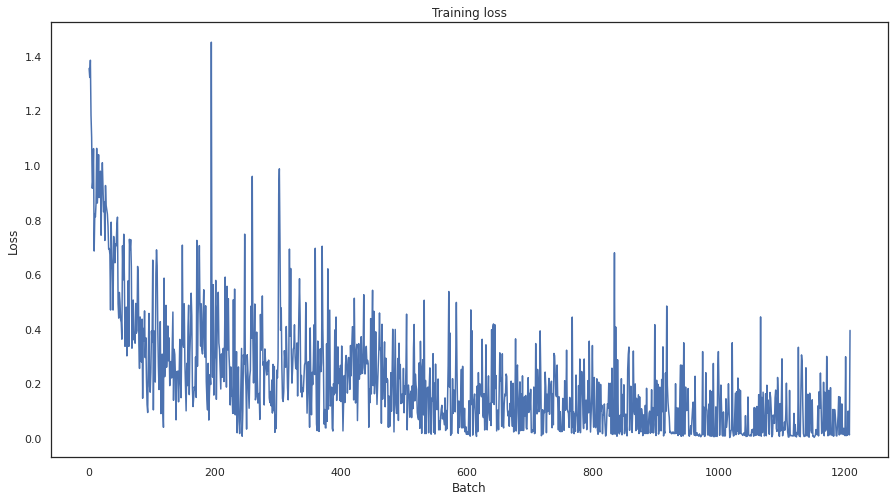

[2020-07-19 08:12:15,958][INFO] ## ================     fold 3        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 08:13:15,437][INFO] ## epoch: 1, train loss: 0.63096219, valid loss: 0.30975095, acc: 0.89452, f1: 0.863491, best_f1: 0.86349
, last lr: 0.000050
[2020-07-19 08:13:15,550][INFO] ## ================     epoch 2        ===============


[2020-07-19 08:14:09,597][INFO] ## epoch: 2, train loss: 0.34948745, valid loss: 0.31038608, acc: 0.88235, f1: 0.845623, best_f1: 0.86349
, last lr: 0.000100
[2020-07-19 08:14:09,718][INFO] ## ================     epoch 3        ===============


[2020-07-19 08:15:03,788][INFO] ## epoch: 3, train loss: 0.25715522, valid loss: 0.41291017, acc: 0.88438, f1: 0.839612, best_f1: 0.86349
, last lr: 0.000094
[2020-07-19 08:15:03,910][INFO] ## ================     epoch 4        ===============


[2020-07-19 08:15:59,888][INFO] ## epoch: 4, train loss: 0.20033707, valid loss: 0.40623968, acc: 0.90264, f1: 0.871523, best_f1: 0.87152
, last lr: 0.000089
[2020-07-19 08:16:00,014][INFO] ## ================     epoch 5        ===============


[2020-07-19 08:16:53,958][INFO] ## epoch: 5, train loss: 0.14239639, valid loss: 0.50240482, acc: 0.87424, f1: 0.837705, best_f1: 0.87152
, last lr: 0.000083
[2020-07-19 08:16:54,079][INFO] ## ================     epoch 6        ===============


[2020-07-19 08:17:49,530][INFO] ## epoch: 6, train loss: 0.08353909, valid loss: 0.47226633, acc: 0.90872, f1: 0.884411, best_f1: 0.88441
, last lr: 0.000078
[2020-07-19 08:17:49,649][INFO] ## ================     epoch 7        ===============


[2020-07-19 08:18:45,234][INFO] ## epoch: 7, train loss: 0.08616191, valid loss: 0.36814953, acc: 0.92089, f1: 0.895606, best_f1: 0.89561
, last lr: 0.000072
[2020-07-19 08:18:45,354][INFO] ## ================     epoch 8        ===============


[2020-07-19 08:19:40,874][INFO] ## epoch: 8, train loss: 0.05201465, valid loss: 0.40986647, acc: 0.92292, f1: 0.901023, best_f1: 0.90102
, last lr: 0.000067
[2020-07-19 08:19:41,003][INFO] ## ================     epoch 9        ===============


[2020-07-19 08:20:34,581][INFO] ## epoch: 9, train loss: 0.03384065, valid loss: 0.41207223, acc: 0.92495, f1: 0.899325, best_f1: 0.90102
, last lr: 0.000061
[2020-07-19 08:20:34,700][INFO] ## ================     epoch 10        ===============


[2020-07-19 08:21:29,974][INFO] ## epoch: 10, train loss: 0.01886922, valid loss: 0.42436056, acc: 0.92901, f1: 0.904280, best_f1: 0.90428
, last lr: 0.000056
[2020-07-19 08:21:30,096][INFO] ## ================     epoch 11        ===============


[2020-07-19 08:22:23,599][INFO] ## epoch: 11, train loss: 0.01230864, valid loss: 0.41716085, acc: 0.92089, f1: 0.899007, best_f1: 0.90428
, last lr: 0.000050
[2020-07-19 08:22:23,719][INFO] ## ================     epoch 12        ===============


[2020-07-19 08:23:17,071][INFO] ## epoch: 12, train loss: 0.00419219, valid loss: 0.52509479, acc: 0.92089, f1: 0.897318, best_f1: 0.90428
, last lr: 0.000044
[2020-07-19 08:23:17,196][INFO] ## ================     epoch 13        ===============


[2020-07-19 08:24:10,602][INFO] ## epoch: 13, train loss: 0.00603950, valid loss: 0.47678072, acc: 0.92089, f1: 0.893636, best_f1: 0.90428
, last lr: 0.000039
[2020-07-19 08:24:10,723][INFO] ## ================     epoch 14        ===============


[2020-07-19 08:25:04,281][INFO] ## epoch: 14, train loss: 0.00557821, valid loss: 0.50267211, acc: 0.91886, f1: 0.891183, best_f1: 0.90428
, last lr: 0.000033
[2020-07-19 08:25:04,402][INFO] ## ================     epoch 15        ===============


[2020-07-19 08:25:57,452][INFO] ## epoch: 15, train loss: 0.00235230, valid loss: 0.55078307, acc: 0.92089, f1: 0.895259, best_f1: 0.90428
, last lr: 0.000028
[2020-07-19 08:25:57,574][INFO] ## ================     epoch 16        ===============


[2020-07-19 08:26:50,435][INFO] ## epoch: 16, train loss: 0.00051699, valid loss: 0.55972179, acc: 0.91684, f1: 0.886476, best_f1: 0.90428
, last lr: 0.000022
[2020-07-19 08:26:50,556][INFO] ## ================     epoch 17        ===============


[2020-07-19 08:27:43,535][INFO] ## epoch: 17, train loss: 0.00019614, valid loss: 0.55170842, acc: 0.91886, f1: 0.891916, best_f1: 0.90428
, last lr: 0.000017
No handles with labels found to put in legend.


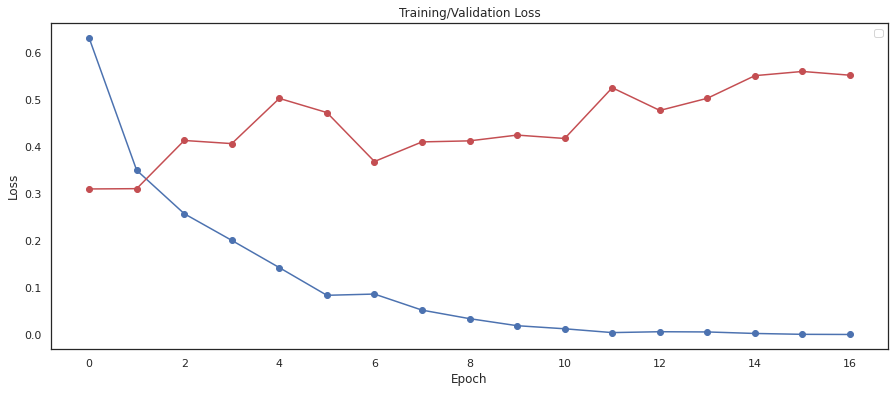

[2020-07-19 08:27:47,567][INFO] ## epoch: best, acc: 0.92900609, f1: 0.90428030, best_f1: 0.90428030



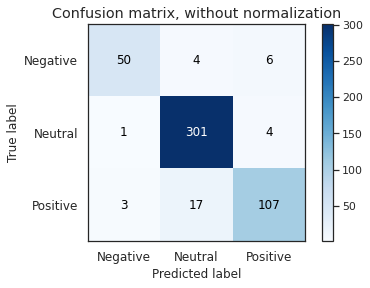

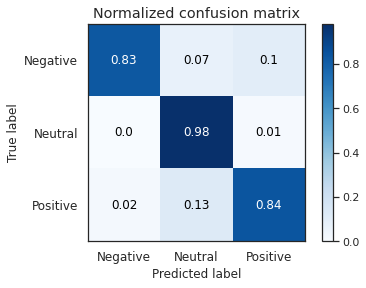

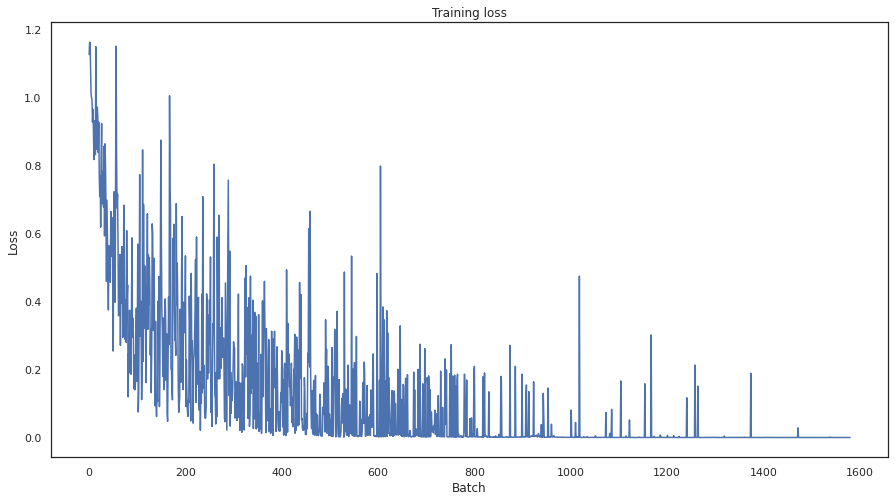

[2020-07-19 08:27:48,418][INFO] ## ================     fold 4        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 08:28:47,498][INFO] ## epoch: 1, train loss: 0.57628594, valid loss: 0.33951689, acc: 0.89634, f1: 0.866996, best_f1: 0.86700
, last lr: 0.000050
[2020-07-19 08:28:47,611][INFO] ## ================     epoch 2        ===============


[2020-07-19 08:29:41,439][INFO] ## epoch: 2, train loss: 0.33543179, valid loss: 0.64158519, acc: 0.80691, f1: 0.786233, best_f1: 0.86700
, last lr: 0.000100
[2020-07-19 08:29:41,562][INFO] ## ================     epoch 3        ===============


[2020-07-19 08:30:35,155][INFO] ## epoch: 3, train loss: 0.32083100, valid loss: 0.39421624, acc: 0.86992, f1: 0.821676, best_f1: 0.86700
, last lr: 0.000094
[2020-07-19 08:30:35,275][INFO] ## ================     epoch 4        ===============


[2020-07-19 08:31:28,705][INFO] ## epoch: 4, train loss: 0.27062162, valid loss: 0.44270990, acc: 0.88211, f1: 0.844735, best_f1: 0.86700
, last lr: 0.000089
[2020-07-19 08:31:28,826][INFO] ## ================     epoch 5        ===============


[2020-07-19 08:32:22,035][INFO] ## epoch: 5, train loss: 0.19749409, valid loss: 0.48216284, acc: 0.88415, f1: 0.837191, best_f1: 0.86700
, last lr: 0.000083
[2020-07-19 08:32:22,157][INFO] ## ================     epoch 6        ===============


[2020-07-19 08:33:15,109][INFO] ## epoch: 6, train loss: 0.13177137, valid loss: 0.51488607, acc: 0.88211, f1: 0.839037, best_f1: 0.86700
, last lr: 0.000078
[2020-07-19 08:33:15,232][INFO] ## ================     epoch 7        ===============


[2020-07-19 08:34:08,271][INFO] ## epoch: 7, train loss: 0.09939178, valid loss: 0.41966960, acc: 0.89228, f1: 0.864527, best_f1: 0.86700
, last lr: 0.000072
[2020-07-19 08:34:08,397][INFO] ## ================     epoch 8        ===============


[2020-07-19 08:35:01,248][INFO] ## epoch: 8, train loss: 0.07984903, valid loss: 0.48389216, acc: 0.89431, f1: 0.863458, best_f1: 0.86700
, last lr: 0.000067
No handles with labels found to put in legend.


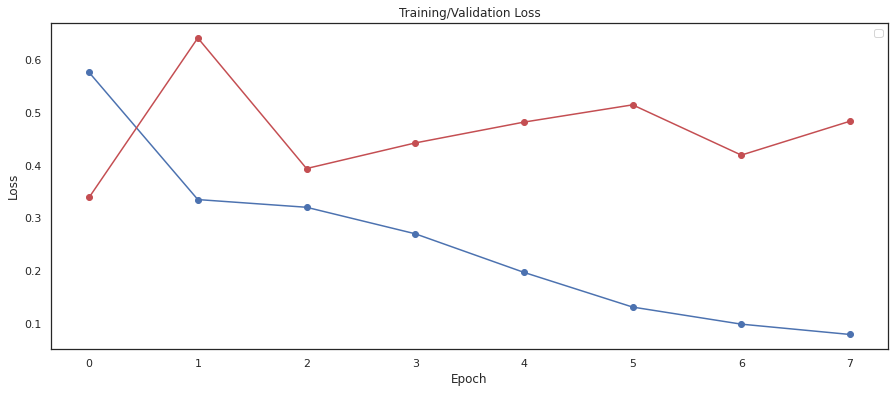

[2020-07-19 08:35:05,151][INFO] ## epoch: best, acc: 0.89634146, f1: 0.86699638, best_f1: 0.86699638



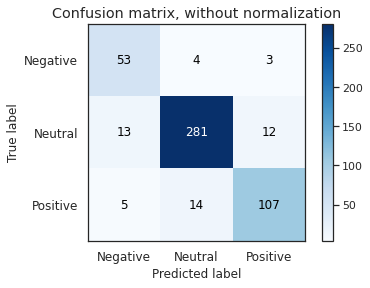

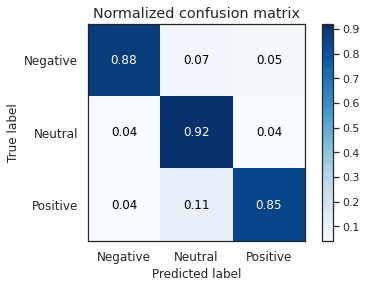

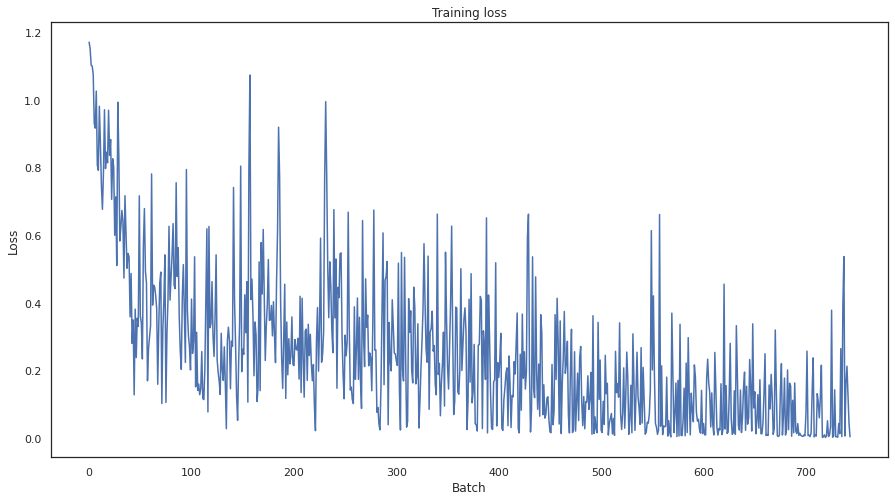

[2020-07-19 08:35:06,031][INFO] ## ================     fold 5        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 08:36:05,155][INFO] ## epoch: 1, train loss: 0.58345216, valid loss: 0.22314028, acc: 0.92886, f1: 0.894530, best_f1: 0.89453
, last lr: 0.000050
[2020-07-19 08:36:05,265][INFO] ## ================     epoch 2        ===============


[2020-07-19 08:36:58,454][INFO] ## epoch: 2, train loss: 0.29664499, valid loss: 0.33151320, acc: 0.90447, f1: 0.874465, best_f1: 0.89453
, last lr: 0.000100
[2020-07-19 08:36:58,572][INFO] ## ================     epoch 3        ===============


[2020-07-19 08:37:52,063][INFO] ## epoch: 3, train loss: 0.32019548, valid loss: 0.45358901, acc: 0.88821, f1: 0.844237, best_f1: 0.89453
, last lr: 0.000094
[2020-07-19 08:37:52,182][INFO] ## ================     epoch 4        ===============


[2020-07-19 08:38:45,777][INFO] ## epoch: 4, train loss: 0.27462903, valid loss: 0.38255924, acc: 0.90244, f1: 0.872299, best_f1: 0.89453
, last lr: 0.000089
[2020-07-19 08:38:45,898][INFO] ## ================     epoch 5        ===============


[2020-07-19 08:39:38,968][INFO] ## epoch: 5, train loss: 0.20928504, valid loss: 0.41685378, acc: 0.89228, f1: 0.857109, best_f1: 0.89453
, last lr: 0.000083
[2020-07-19 08:39:39,087][INFO] ## ================     epoch 6        ===============


[2020-07-19 08:40:34,003][INFO] ## epoch: 6, train loss: 0.15994335, valid loss: 0.38796754, acc: 0.92073, f1: 0.895660, best_f1: 0.89566
, last lr: 0.000078
[2020-07-19 08:40:34,127][INFO] ## ================     epoch 7        ===============


[2020-07-19 08:41:27,159][INFO] ## epoch: 7, train loss: 0.13140707, valid loss: 0.55846255, acc: 0.88821, f1: 0.850170, best_f1: 0.89566
, last lr: 0.000072
[2020-07-19 08:41:27,278][INFO] ## ================     epoch 8        ===============


[2020-07-19 08:42:20,263][INFO] ## epoch: 8, train loss: 0.09735351, valid loss: 0.58903867, acc: 0.88618, f1: 0.847818, best_f1: 0.89566
, last lr: 0.000067
[2020-07-19 08:42:20,383][INFO] ## ================     epoch 9        ===============


[2020-07-19 08:43:15,475][INFO] ## epoch: 9, train loss: 0.12208693, valid loss: 0.40398822, acc: 0.91870, f1: 0.900125, best_f1: 0.90012
, last lr: 0.000061
[2020-07-19 08:43:15,593][INFO] ## ================     epoch 10        ===============


[2020-07-19 08:44:08,546][INFO] ## epoch: 10, train loss: 0.07540358, valid loss: 0.49251437, acc: 0.91463, f1: 0.892699, best_f1: 0.90012
, last lr: 0.000056
[2020-07-19 08:44:08,668][INFO] ## ================     epoch 11        ===============


[2020-07-19 08:45:01,389][INFO] ## epoch: 11, train loss: 0.04809651, valid loss: 0.60612553, acc: 0.90650, f1: 0.876660, best_f1: 0.90012
, last lr: 0.000050
[2020-07-19 08:45:01,511][INFO] ## ================     epoch 12        ===============


[2020-07-19 08:45:54,068][INFO] ## epoch: 12, train loss: 0.04620323, valid loss: 0.52862190, acc: 0.91870, f1: 0.898327, best_f1: 0.90012
, last lr: 0.000044
[2020-07-19 08:45:54,188][INFO] ## ================     epoch 13        ===============


[2020-07-19 08:46:47,129][INFO] ## epoch: 13, train loss: 0.02749956, valid loss: 0.56531191, acc: 0.92073, f1: 0.897651, best_f1: 0.90012
, last lr: 0.000039
[2020-07-19 08:46:47,252][INFO] ## ================     epoch 14        ===============


[2020-07-19 08:47:40,783][INFO] ## epoch: 14, train loss: 0.02864861, valid loss: 0.53971291, acc: 0.92073, f1: 0.896457, best_f1: 0.90012
, last lr: 0.000033
[2020-07-19 08:47:40,908][INFO] ## ================     epoch 15        ===============


[2020-07-19 08:48:34,599][INFO] ## epoch: 15, train loss: 0.02742069, valid loss: 0.55223720, acc: 0.91260, f1: 0.892286, best_f1: 0.90012
, last lr: 0.000028
[2020-07-19 08:48:34,723][INFO] ## ================     epoch 16        ===============


[2020-07-19 08:49:30,284][INFO] ## epoch: 16, train loss: 0.02264319, valid loss: 0.54197134, acc: 0.92276, f1: 0.903615, best_f1: 0.90361
, last lr: 0.000022
[2020-07-19 08:49:30,415][INFO] ## ================     epoch 17        ===============


[2020-07-19 08:50:25,604][INFO] ## epoch: 17, train loss: 0.01822525, valid loss: 0.55175185, acc: 0.92683, f1: 0.907728, best_f1: 0.90773
, last lr: 0.000017
[2020-07-19 08:50:25,722][INFO] ## ================     epoch 18        ===============


[2020-07-19 08:51:19,126][INFO] ## epoch: 18, train loss: 0.01389300, valid loss: 0.58857783, acc: 0.91870, f1: 0.900712, best_f1: 0.90773
, last lr: 0.000011
[2020-07-19 08:51:19,246][INFO] ## ================     epoch 19        ===============


[2020-07-19 08:52:12,756][INFO] ## epoch: 19, train loss: 0.01180441, valid loss: 0.59012581, acc: 0.91463, f1: 0.892718, best_f1: 0.90773
, last lr: 0.000006
[2020-07-19 08:52:12,877][INFO] ## ================     epoch 20        ===============


[2020-07-19 08:53:06,262][INFO] ## epoch: 20, train loss: 0.00857689, valid loss: 0.60348296, acc: 0.91667, f1: 0.896414, best_f1: 0.90773
, last lr: 0.000000
No handles with labels found to put in legend.


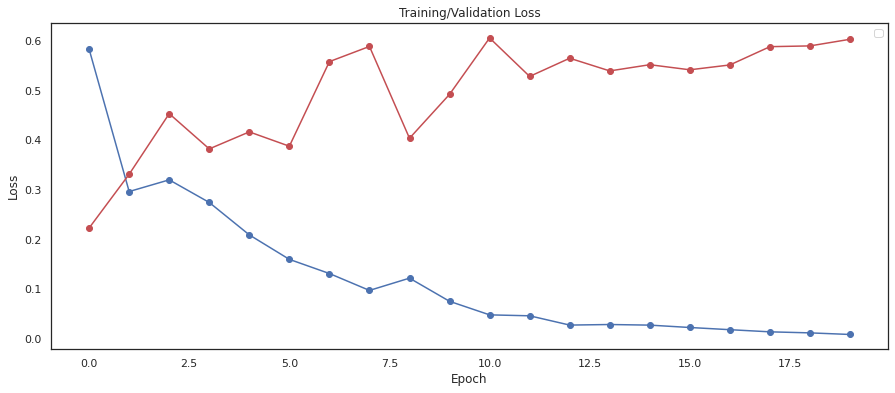

[2020-07-19 08:53:10,215][INFO] ## epoch: best, acc: 0.92682927, f1: 0.90772774, best_f1: 0.90772774



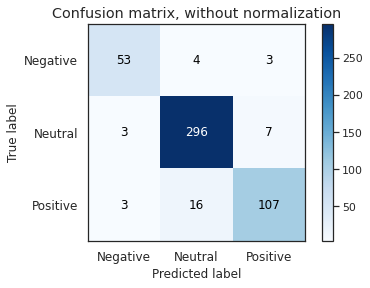

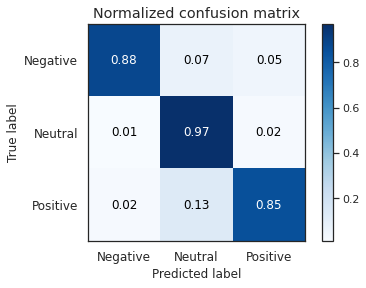

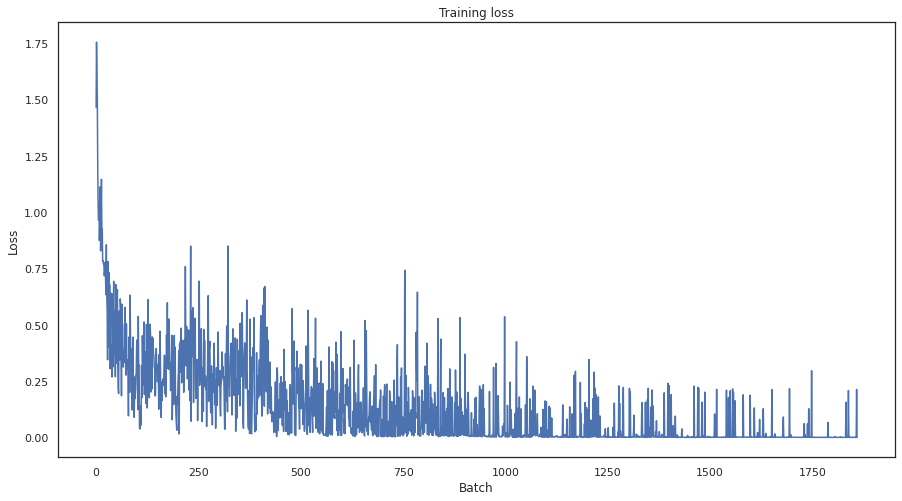

[2020-07-19 08:53:11,094][INFO] ## ================     fold 6        ===============
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weig

[2020-07-19 08:54:10,879][INFO] ## epoch: 1, train loss: 0.59922185, valid loss: 0.26256851, acc: 0.91870, f1: 0.885615, best_f1: 0.88561
, last lr: 0.000050
[2020-07-19 08:54:10,993][INFO] ## ================     epoch 2        ===============


[2020-07-19 08:55:05,044][INFO] ## epoch: 2, train loss: 0.34199282, valid loss: 0.50212937, acc: 0.89634, f1: 0.861795, best_f1: 0.88561
, last lr: 0.000100
[2020-07-19 08:55:05,166][INFO] ## ================     epoch 3        ===============


[2020-07-19 08:55:59,341][INFO] ## epoch: 3, train loss: 0.28233254, valid loss: 0.56487351, acc: 0.87805, f1: 0.838537, best_f1: 0.88561
, last lr: 0.000094
[2020-07-19 08:55:59,465][INFO] ## ================     epoch 4        ===============


[2020-07-19 08:56:53,755][INFO] ## epoch: 4, train loss: 0.22888180, valid loss: 0.50900307, acc: 0.89228, f1: 0.849807, best_f1: 0.88561
, last lr: 0.000089
[2020-07-19 08:56:53,877][INFO] ## ================     epoch 5        ===============


[2020-07-19 08:57:47,896][INFO] ## epoch: 5, train loss: 0.19904373, valid loss: 0.37008310, acc: 0.90650, f1: 0.874009, best_f1: 0.88561
, last lr: 0.000083
[2020-07-19 08:57:48,019][INFO] ## ================     epoch 6        ===============


[2020-07-19 08:58:42,013][INFO] ## epoch: 6, train loss: 0.13753876, valid loss: 0.50254707, acc: 0.90447, f1: 0.876682, best_f1: 0.88561
, last lr: 0.000078
[2020-07-19 08:58:42,133][INFO] ## ================     epoch 7        ===============


[2020-07-19 08:59:37,741][INFO] ## epoch: 7, train loss: 0.09399120, valid loss: 0.39330120, acc: 0.92683, f1: 0.910684, best_f1: 0.91068
, last lr: 0.000072
[2020-07-19 08:59:37,864][INFO] ## ================     epoch 8        ===============


[2020-07-19 09:00:31,607][INFO] ## epoch: 8, train loss: 0.06848948, valid loss: 0.42515776, acc: 0.91260, f1: 0.879296, best_f1: 0.91068
, last lr: 0.000067
[2020-07-19 09:00:31,728][INFO] ## ================     epoch 9        ===============


[2020-07-19 09:01:25,496][INFO] ## epoch: 9, train loss: 0.06394361, valid loss: 0.39183701, acc: 0.92683, f1: 0.903511, best_f1: 0.91068
, last lr: 0.000061
[2020-07-19 09:01:25,615][INFO] ## ================     epoch 10        ===============


[2020-07-19 09:02:19,303][INFO] ## epoch: 10, train loss: 0.06072869, valid loss: 0.39389715, acc: 0.93089, f1: 0.905914, best_f1: 0.91068
, last lr: 0.000056
[2020-07-19 09:02:19,424][INFO] ## ================     epoch 11        ===============


[2020-07-19 09:03:12,923][INFO] ## epoch: 11, train loss: 0.04184632, valid loss: 0.49897149, acc: 0.91667, f1: 0.893915, best_f1: 0.91068
, last lr: 0.000050
[2020-07-19 09:03:13,041][INFO] ## ================     epoch 12        ===============


[2020-07-19 09:04:07,953][INFO] ## epoch: 12, train loss: 0.03117262, valid loss: 0.42349663, acc: 0.94106, f1: 0.923610, best_f1: 0.92361
, last lr: 0.000044
[2020-07-19 09:04:08,072][INFO] ## ================     epoch 13        ===============


[2020-07-19 09:05:01,632][INFO] ## epoch: 13, train loss: 0.03306060, valid loss: 0.45401346, acc: 0.93496, f1: 0.916265, best_f1: 0.92361
, last lr: 0.000039
[2020-07-19 09:05:01,755][INFO] ## ================     epoch 14        ===============


[2020-07-19 09:05:55,213][INFO] ## epoch: 14, train loss: 0.02493587, valid loss: 0.50663846, acc: 0.92276, f1: 0.899384, best_f1: 0.92361
, last lr: 0.000033
[2020-07-19 09:05:55,332][INFO] ## ================     epoch 15        ===============


[2020-07-19 09:06:48,714][INFO] ## epoch: 15, train loss: 0.01351871, valid loss: 0.51188326, acc: 0.93293, f1: 0.911482, best_f1: 0.92361
, last lr: 0.000028
[2020-07-19 09:06:48,840][INFO] ## ================     epoch 16        ===============


[2020-07-19 09:07:41,946][INFO] ## epoch: 16, train loss: 0.00720795, valid loss: 0.51591429, acc: 0.93496, f1: 0.914454, best_f1: 0.92361
, last lr: 0.000022
[2020-07-19 09:07:42,069][INFO] ## ================     epoch 17        ===============


[2020-07-19 09:08:35,247][INFO] ## epoch: 17, train loss: 0.00703820, valid loss: 0.52488365, acc: 0.93293, f1: 0.912096, best_f1: 0.92361
, last lr: 0.000017
[2020-07-19 09:08:35,363][INFO] ## ================     epoch 18        ===============


[2020-07-19 09:09:28,548][INFO] ## epoch: 18, train loss: 0.00498322, valid loss: 0.52622443, acc: 0.93496, f1: 0.915259, best_f1: 0.92361
, last lr: 0.000011
[2020-07-19 09:09:28,667][INFO] ## ================     epoch 19        ===============


[2020-07-19 09:10:21,852][INFO] ## epoch: 19, train loss: 0.00082979, valid loss: 0.53425632, acc: 0.93496, f1: 0.915926, best_f1: 0.92361
, last lr: 0.000006
No handles with labels found to put in legend.


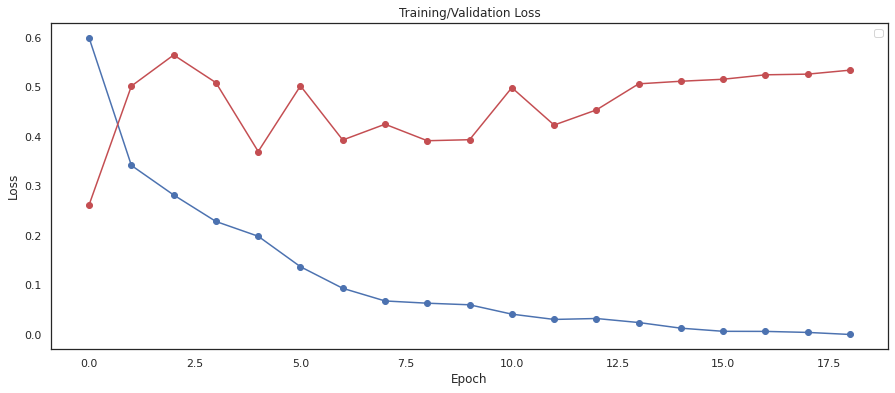

[2020-07-19 09:10:25,636][INFO] ## epoch: best, acc: 0.94105691, f1: 0.92361031, best_f1: 0.92361031



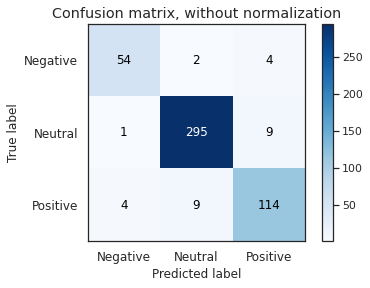

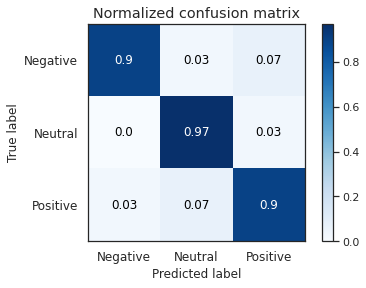

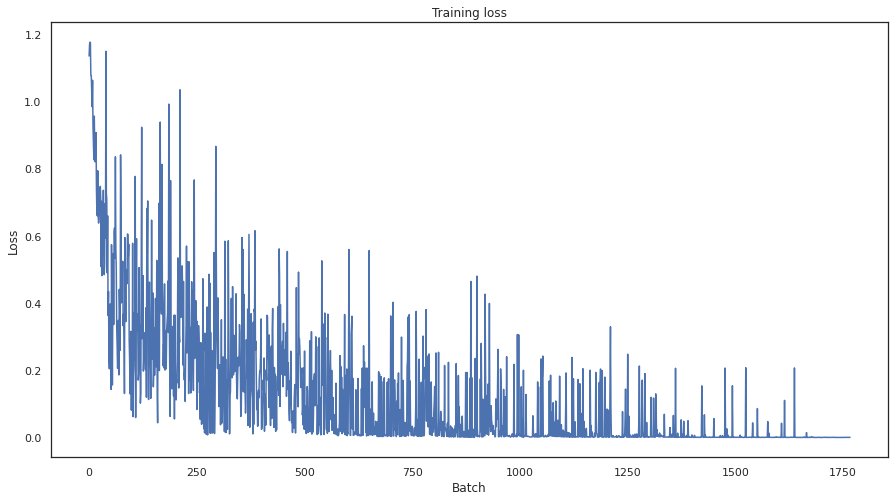

In [71]:
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
  
for fold, (train_indices, valid_indices) in enumerate(skf.split(train_valid_labels, train_valid_labels)):
    train_bert(fold, train_indices, valid_indices)
    # Number of folds to iterrate
    if fold == 10:
        break


In [72]:
# This is only when all folds have been performed
logger.info(f1_score(train_labels, np.argmax(oof_train, axis=1), average='macro'))

train_df['pred_target'] = np.argmax(oof_train, axis=1)
train_df['pred_target_lower'] = oof_train[:,0]
train_df['pred_target_hold'] = oof_train[:,1]
train_df['pred_target_raise'] = oof_train[:,2]
train_df.head()

[2020-07-19 09:10:26,339][INFO] ## 0.8972740187904668


sentence  ...  pred_target_raise
0  According to Gran , the company has no plans t...  ...           0.000293
1  With the new production plant the company woul...  ...           0.998784
2  For the last quarter of 2010 , Componenta 's n...  ...           0.938536
3  In the third quarter of 2010 , net sales incre...  ...           0.999724
4  Operating profit rose to EUR 13.1 mn from EUR ...  ...           0.999723

[5 rows x 6 columns]

## ALBERT

In [92]:
from torch.utils.data import DataLoader, Dataset
#from transformers import *
from transformers import AlbertTokenizer, AlbertForSequenceClassification, AlbertModel
from transformers import AdamW as AdamW_Hf, get_linear_schedule_with_warmup

In [25]:
# Define metrics
# Here, use F1 Macro to evaluate the model.
def metric(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    return acc, f1

scoring = {'Accuracy': 'accuracy', 'F1': 'f1_macro'}
refit = 'F1'

In [113]:
# Set Tokenizer and Model
tokenizer = AlbertTokenizer.from_pretrained('albert-large-v2', do_lower_case=True)
albert_model = AlbertForSequenceClassification.from_pretrained('albert-large-v2', num_labels=3)

Some weights of the model checkpoint at albert-large-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You s

In [50]:
# Test tokenizer
# tokenizer.encode() returns only input_ids, whereas tokenizer() returns dict
inputs = tokenizer("Hello, my dog is cute", 
                   return_tensors="pt", 
                   pad_to_max_length=True, 
                   max_length = 64,
                   add_special_tokens=True,
                   padding_side='right')
print('inputs: \n', inputs)

print('\ndecoded: \n',tokenizer.decode(inputs['input_ids'].squeeze(0)))

labels = torch.tensor([1]).unsqueeze(0)
print('\nlabels: ', labels)

outputs = albert_model(**inputs, labels=labels)
print('\noutputs: length=', len(outputs))
print(outputs)

loss = outputs[0]
logits = outputs[1]

print('loss: ', loss.detach())
print('logits: ', logits.detach())

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.dense.bias', 'predictions.decoder.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You sho

inputs: 
 {'input_ids': tensor([[    2, 10975,    15,    51,  1952,    25, 10901,     3,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Looks `padding_side` argument does not exist. The others look fine.

In [93]:
# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return(self.datalist[idx])

In [114]:
# Hyperparameters
max_seq_length = 48
learning_rate = 2e-5
num_epochs = 20
batch_size = 32
patience = 7
warm_up_proportion = 0.1
max_grad_norm = 1.0

In [119]:
def train_transformer(model, x_train, y_train, x_valid, y_valid, out_model_name):
    # Move model to GUP/CPU device
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    
    # Load data into SimpleDataset
    train_ds = SimpleDataset(x_train, y_train)
    valid_ds = SimpleDataset(x_valid, y_valid)
    
    # Use DataLoader to load data from Dataset in batches
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
    
    num_total_opt_steps = int(len(train_loader) * num_epochs)
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), num_epochs))
    
    # Instead of AdamW from torch.optim, use the one from Huggingface with scheduler for learning curve decay
    # To reproduce BertAdam specific behavior set correct_bias=False
    optimizer = AdamW_Hf(model.parameters(), lr=learning_rate, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, num_training_steps=num_total_opt_steps)  # PyTorch scheduler

    # Set Train Mode
    model.train()
    
    # Tokenizer Parameter
    param_tk = {
        'return_tensors': "pt",
        'pad_to_max_length': True,
        'max_length': max_seq_length,
        'add_special_tokens': True,
        'truncation': True
    }

    # Initialize
    best_f1 = 0.
    valid_best = np.zeros((len(y_valid), 2))
    early_stop = 0
    train_losses = []
    valid_losses = []
    total_steps = 0
    train_loss_set = []
    
    for epoch in range(num_epochs):
        logger.info('================     epoch {}     ==============='.format(epoch+1))
        train_loss = 0.

        for i, batch in tqdm(enumerate(train_loader), total=len(train_loader), desc='Training'):
            # Input features and labels from batch and move to device
            x_train_bt, y_train_bt = batch
            x_train_bt = tokenizer(x_train_bt, **param_tk).to(device)
            y_train_bt = torch.tensor(y_train_bt, dtype=torch.long).to(device)
            
            # Reset gradient
            optimizer.zero_grad()

            # Feedforward prediction
            # y_pred = bert_model(x_ids, x_mask, x_sids)
            loss, logits = model(**x_train_bt, labels=y_train_bt)

            # Calculate Loss - no longer required.
            # loss = loss_fn(y_pred[0], y_truth)

            # Backward Propagation
            loss.backward()

            # Training Loss
            train_loss += loss.item() / len(train_loader)
            train_loss_set.append(loss.item())

            # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            
            logger.debug('train batch: %d, train_loss: %8f' % (i, loss.item() / len(train_loader)))
            total_steps += 1

        train_losses.append(train_loss)

        # Move to Evaluation Mode
        model.eval()
        
        # Initialize for Validation
        val_loss = 0.
        #valid_preds_fold = np.zeros((y_valid.size(0), 3))
        y_valid_pred = np.zeros((len(y_valid), 3))
        
        with torch.no_grad():
            for i, batch in tqdm(enumerate(valid_loader), total=len(valid_loader), desc='Validation'):
                # Input features and labels from batch and move to device
                x_valid_bt, y_valid_bt = batch
                x_valid_bt = tokenizer(x_valid_bt, **param_tk).to(device)
                y_valid_bt = torch.tensor(y_valid_bt, dtype=torch.long).to(device)
            
                loss, logits = model(**x_valid_bt, labels=y_valid_bt)
                val_loss += loss.item() / len(valid_loader)
                y_valid_pred[i * batch_size:(i + 1) * batch_size] = F.softmax(logits, dim=1).cpu().numpy()
                logger.debug('validation batch: {}, val_loss: {}'.format(i, loss.item() / len(valid_loader)))
        valid_losses.append(val_loss)

        # Calculate metrics
        acc, f1 = metric(y_valid, np.argmax(y_valid_pred, axis=1))
        
        # If improving, save the model. If not, count up for early stopping
        if best_f1 < f1:
            early_stop = 0
            best_f1 = f1
            valid_best = y_valid_pred
            torch.save(model.state_dict(), output_dir + out_model_name)
        else:
            early_stop += 1
            
        logger.info(
            'epoch: %d, train loss: %.8f, valid loss: %.8f, acc: %.5f, f1: %5f, best_f1: %.5f\n, last lr: %.6f' %
            (epoch+1, train_loss, val_loss, acc, f1, best_f1, scheduler.get_last_lr()[0]))
        
        logger.debug('valid_best: {}'.format(np.argmax(valid_best, axis=1)))

        if device == 'cuda:0':
            torch.cuda.empty_cache()

        # Early stop if it reaches patience number
        if early_stop >= patience:
            break

        # Back to Train Mode
        model.train()

    # Once all epochs are done, output summaries
    logger.info('================ Training Completed: Starting Post Process ===============')
    
    # Draw training/validation losses
    plt.figure(figsize=(15,6))
    plt.plot(train_losses, 'b-o')
    plt.plot(valid_losses, 'r-o')
    plt.title("Training/Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

    ## Load the best model
    #model.load_state_dict(torch.load(output_dir + out_model_name))
    ## Set the model to Evaluation Mode
    #model.eval()
    
    # Check the metrics for the validation set
    acc, f1 = metric(y_valid, np.argmax(valid_best, axis=1))
    logger.info('epoch: best, acc: %.8f, f1: %.8f, best_f1: %.8f\n' % (acc, f1, best_f1))

    # Convert to class names from 0, 1, 2
    class_names = ['Negative', 'Neutral', 'Positive']
    y_valid_class = [class_names[int(idx)] for idx in y_valid]
    pred_valid_class = [class_names[int(idx)] for idx in np.argmax(valid_best, axis=1)]

    titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = skplt.metrics.plot_confusion_matrix(y_valid_class, pred_valid_class, normalize=normalize, title=title)
    plt.show()

    # plot training performance
    plt.figure(figsize=(15,8))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(train_loss_set)
    plt.show()
    
    return valid_best

[2020-09-19 15:04:39,519][INFO] ## ================     fold 1    ===============
[2020-09-19 15:04:39,524][INFO] ## Total Training Steps: 1860 (93 batches x 20 epochs)
[2020-09-19 15:04:39,526][INFO] ## ================     epoch 1     ===============


/Users/yuki/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


/Users/yuki/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[2020-09-19 15:31:41,293][INFO] ## epoch: 1, train loss: 0.73063037, valid loss: 0.39332098, acc: 0.85598, f1: 0.797419, best_f1: 0.79742
, last lr: 0.000010
[2020-09-19 15:31:41,296][INFO] ## ================     epoch 2     ===============


[2020-09-19 15:58:41,638][INFO] ## epoch: 2, train loss: 0.39388103, valid loss: 0.48432938, acc: 0.84990, f1: 0.785193, best_f1: 0.79742
, last lr: 0.000020
[2020-09-19 15:58:41,642][INFO] ## ================     epoch 3     ===============


[2020-09-19 16:26:02,909][INFO] ## epoch: 3, train loss: 0.52852293, valid loss: 0.93692766, acc: 0.62069, f1: 0.255319, best_f1: 0.79742
, last lr: 0.000019
[2020-09-19 16:26:02,913][INFO] ## ================     epoch 4     ===============


[2020-09-19 16:53:05,540][INFO] ## epoch: 4, train loss: 0.90709077, valid loss: 0.87893682, acc: 0.65517, f1: 0.337981, best_f1: 0.79742
, last lr: 0.000018
[2020-09-19 16:53:05,543][INFO] ## ================     epoch 5     ===============


[2020-09-19 17:21:09,937][INFO] ## epoch: 5, train loss: 0.65720210, valid loss: 0.49294226, acc: 0.80730, f1: 0.545650, best_f1: 0.79742
, last lr: 0.000017
[2020-09-19 17:21:09,940][INFO] ## ================     epoch 6     ===============


[2020-09-19 17:48:16,693][INFO] ## epoch: 6, train loss: 0.40189190, valid loss: 0.31896933, acc: 0.90872, f1: 0.862944, best_f1: 0.86294
, last lr: 0.000016
[2020-09-19 17:48:16,695][INFO] ## ================     epoch 7     ===============


[2020-09-19 18:15:41,894][INFO] ## epoch: 7, train loss: 0.26836415, valid loss: 0.34169975, acc: 0.90669, f1: 0.854502, best_f1: 0.86294
, last lr: 0.000014
[2020-09-19 18:15:41,897][INFO] ## ================     epoch 8     ===============


[2020-09-19 18:42:59,610][INFO] ## epoch: 8, train loss: 0.19514207, valid loss: 0.34080498, acc: 0.88844, f1: 0.840970, best_f1: 0.86294
, last lr: 0.000013
[2020-09-19 18:42:59,613][INFO] ## ================     epoch 9     ===============


[2020-09-19 19:10:03,060][INFO] ## epoch: 9, train loss: 0.17094190, valid loss: 0.39960110, acc: 0.89047, f1: 0.848601, best_f1: 0.86294
, last lr: 0.000012
[2020-09-19 19:10:03,064][INFO] ## ================     epoch 10     ===============


[2020-09-19 19:37:46,364][INFO] ## epoch: 10, train loss: 0.12985615, valid loss: 0.40404374, acc: 0.91886, f1: 0.880727, best_f1: 0.88073
, last lr: 0.000011
[2020-09-19 19:37:46,368][INFO] ## ================     epoch 11     ===============


[2020-09-19 20:04:53,234][INFO] ## epoch: 11, train loss: 0.14177723, valid loss: 0.43414824, acc: 0.89858, f1: 0.872952, best_f1: 0.88073
, last lr: 0.000010
[2020-09-19 20:04:53,238][INFO] ## ================     epoch 12     ===============


[2020-09-19 20:32:08,442][INFO] ## epoch: 12, train loss: 0.10573363, valid loss: 0.42274258, acc: 0.92495, f1: 0.896338, best_f1: 0.89634
, last lr: 0.000009
[2020-09-19 20:32:08,446][INFO] ## ================     epoch 13     ===============


[2020-09-19 20:59:13,055][INFO] ## epoch: 13, train loss: 0.08531421, valid loss: 0.44261939, acc: 0.91481, f1: 0.880134, best_f1: 0.89634
, last lr: 0.000008
[2020-09-19 20:59:13,057][INFO] ## ================     epoch 14     ===============


[2020-09-19 21:26:26,300][INFO] ## epoch: 14, train loss: 0.06857310, valid loss: 0.45182824, acc: 0.91075, f1: 0.878682, best_f1: 0.89634
, last lr: 0.000007
[2020-09-19 21:26:26,304][INFO] ## ================     epoch 15     ===============


[2020-09-19 21:53:55,538][INFO] ## epoch: 15, train loss: 0.05635352, valid loss: 0.50705137, acc: 0.91278, f1: 0.868111, best_f1: 0.89634
, last lr: 0.000006
[2020-09-19 21:53:55,542][INFO] ## ================     epoch 16     ===============


[2020-09-19 22:23:26,119][INFO] ## epoch: 16, train loss: 0.04180969, valid loss: 0.48341828, acc: 0.90669, f1: 0.861906, best_f1: 0.89634
, last lr: 0.000004
[2020-09-19 22:23:26,123][INFO] ## ================     epoch 17     ===============


[2020-09-19 22:51:30,422][INFO] ## epoch: 17, train loss: 0.03340916, valid loss: 0.52771405, acc: 0.90669, f1: 0.868329, best_f1: 0.89634
, last lr: 0.000003
[2020-09-19 22:51:30,426][INFO] ## ================     epoch 18     ===============


[2020-09-19 23:19:36,002][INFO] ## epoch: 18, train loss: 0.02899539, valid loss: 0.52178781, acc: 0.90669, f1: 0.870538, best_f1: 0.89634
, last lr: 0.000002
[2020-09-19 23:19:36,004][INFO] ## ================     epoch 19     ===============


[2020-09-19 23:47:45,855][INFO] ## epoch: 19, train loss: 0.02525375, valid loss: 0.53302182, acc: 0.91278, f1: 0.880326, best_f1: 0.89634
, last lr: 0.000001
[2020-09-19 23:47:45,859][INFO] ## ================ Training Completed: Starting Post Process ===============
No handles with labels found to put in legend.


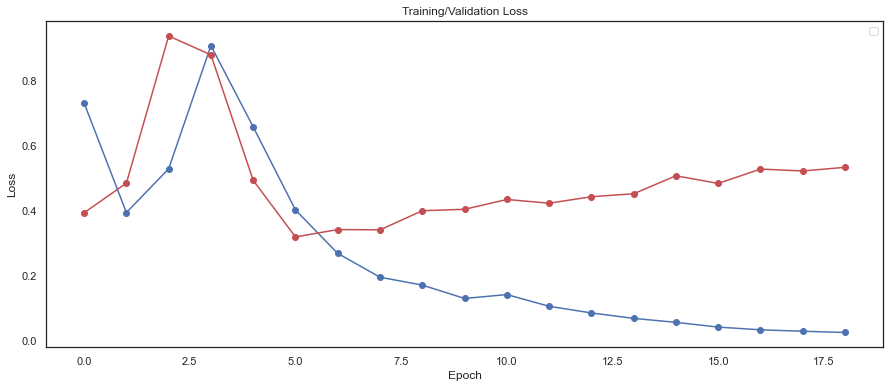

[2020-09-19 23:47:46,396][INFO] ## epoch: best, acc: 0.92494929, f1: 0.89633761, best_f1: 0.89633761



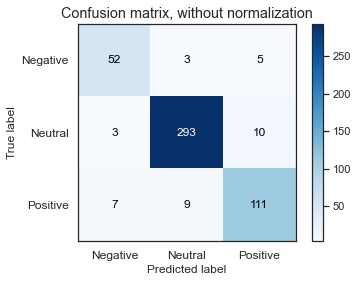

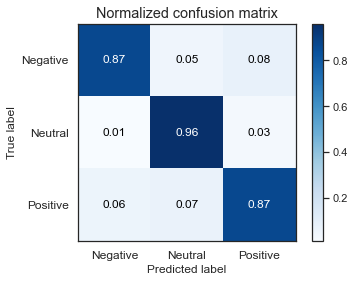

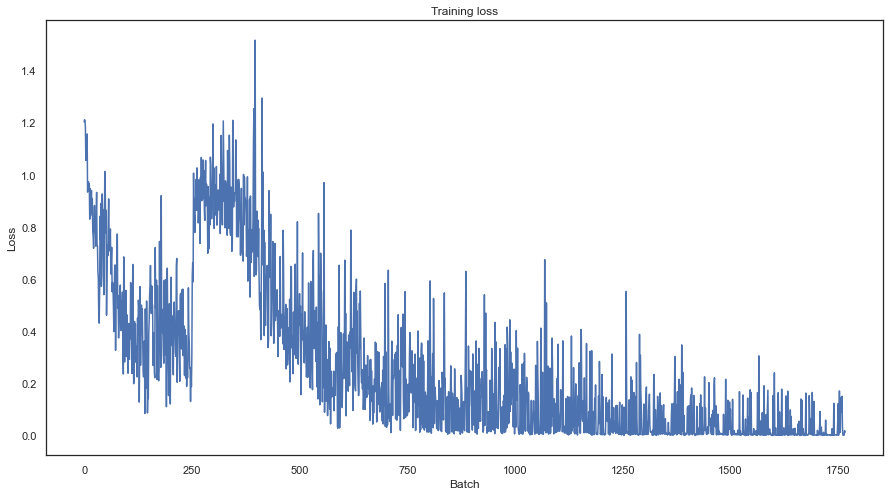

[2020-09-19 23:47:47,025][INFO] ## ================     fold 2    ===============
[2020-09-19 23:47:47,037][INFO] ## Total Training Steps: 1860 (93 batches x 20 epochs)
[2020-09-19 23:47:47,042][INFO] ## ================     epoch 1     ===============


[2020-09-20 00:15:57,585][INFO] ## epoch: 1, train loss: 0.15343846, valid loss: 0.06471110, acc: 0.97972, f1: 0.966164, best_f1: 0.96616
, last lr: 0.000010
[2020-09-20 00:15:57,588][INFO] ## ================     epoch 2     ===============


[2020-09-20 00:44:09,252][INFO] ## epoch: 2, train loss: 0.32326950, valid loss: 0.47197041, acc: 0.82556, f1: 0.567744, best_f1: 0.96616
, last lr: 0.000020
[2020-09-20 00:44:09,254][INFO] ## ================     epoch 3     ===============


[2020-09-20 01:12:19,254][INFO] ## epoch: 3, train loss: 0.36353009, valid loss: 0.41227511, acc: 0.87221, f1: 0.782162, best_f1: 0.96616
, last lr: 0.000019
[2020-09-20 01:12:19,258][INFO] ## ================     epoch 4     ===============


[2020-09-20 01:40:29,574][INFO] ## epoch: 4, train loss: 0.23782384, valid loss: 0.18514377, acc: 0.95538, f1: 0.934389, best_f1: 0.96616
, last lr: 0.000018
[2020-09-20 01:40:29,577][INFO] ## ================     epoch 5     ===============


[2020-09-20 02:08:40,829][INFO] ## epoch: 5, train loss: 0.15506331, valid loss: 0.27208586, acc: 0.94929, f1: 0.924205, best_f1: 0.96616
, last lr: 0.000017
[2020-09-20 02:08:40,833][INFO] ## ================     epoch 6     ===============


[2020-09-20 02:36:50,072][INFO] ## epoch: 6, train loss: 0.41148854, valid loss: 0.59348917, acc: 0.69371, f1: 0.492468, best_f1: 0.96616
, last lr: 0.000016
[2020-09-20 02:36:50,077][INFO] ## ================     epoch 7     ===============


[2020-09-20 03:04:47,430][INFO] ## epoch: 7, train loss: 0.34778904, valid loss: 0.29965550, acc: 0.91075, f1: 0.863777, best_f1: 0.96616
, last lr: 0.000014
[2020-09-20 03:04:47,433][INFO] ## ================     epoch 8     ===============


[2020-09-20 03:32:50,669][INFO] ## epoch: 8, train loss: 0.21811867, valid loss: 0.26071476, acc: 0.93915, f1: 0.914536, best_f1: 0.96616
, last lr: 0.000013
[2020-09-20 03:32:50,672][INFO] ## ================ Training Completed: Starting Post Process ===============
No handles with labels found to put in legend.


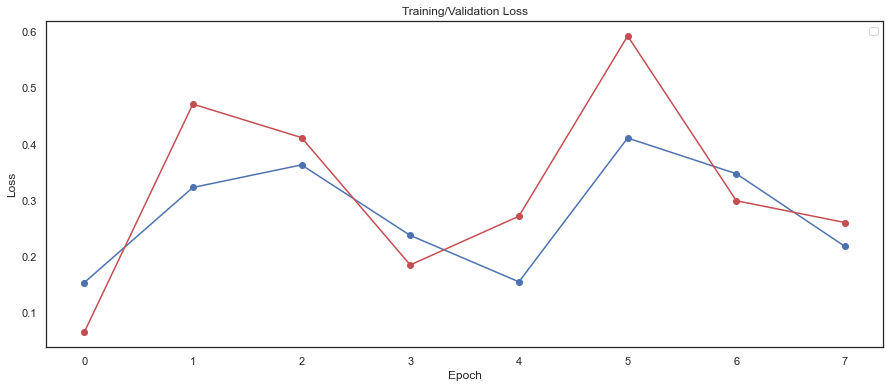

[2020-09-20 03:32:50,937][INFO] ## epoch: best, acc: 0.97971602, f1: 0.96616372, best_f1: 0.96616372



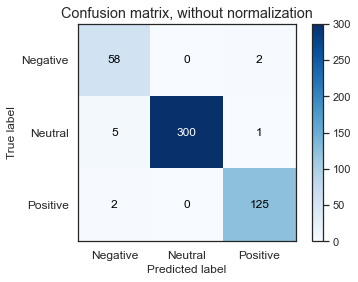

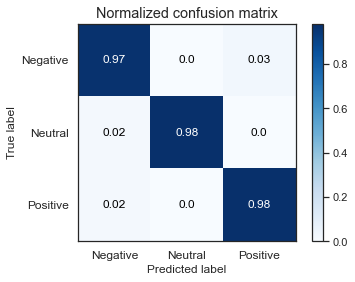

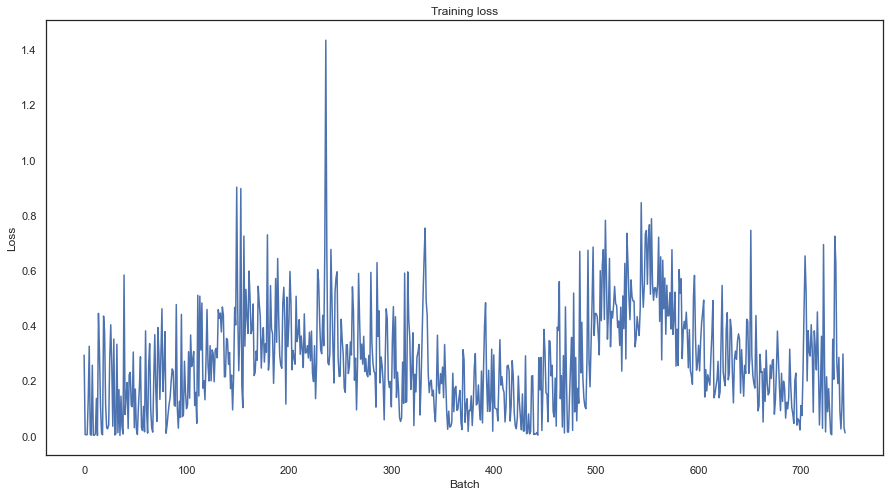

[2020-09-20 03:32:52,973][INFO] ## ================     fold 3    ===============
[2020-09-20 03:32:52,976][INFO] ## Total Training Steps: 1860 (93 batches x 20 epochs)
[2020-09-20 03:32:52,976][INFO] ## ================     epoch 1     ===============


[2020-09-20 04:00:55,511][INFO] ## epoch: 1, train loss: 0.39574684, valid loss: 0.63746075, acc: 0.71805, f1: 0.555340, best_f1: 0.55534
, last lr: 0.000010
[2020-09-20 04:00:55,514][INFO] ## ================     epoch 2     ===============


[2020-09-20 04:29:00,870][INFO] ## epoch: 2, train loss: 0.39569089, valid loss: 0.29295272, acc: 0.92698, f1: 0.902411, best_f1: 0.90241
, last lr: 0.000020
[2020-09-20 04:29:00,873][INFO] ## ================     epoch 3     ===============


[2020-09-20 04:56:55,318][INFO] ## epoch: 3, train loss: 0.49258842, valid loss: 0.44528757, acc: 0.84178, f1: 0.732394, best_f1: 0.90241
, last lr: 0.000019
[2020-09-20 04:56:55,321][INFO] ## ================     epoch 4     ===============


KeyboardInterrupt: 

In [120]:
# Run the training with Stratified KFold
skf = StratifiedKFold(n_splits=7, shuffle=True, random_state=rand_seed)

# Input Data
x_all = np.array(train_df['sentence'])
y_all = np.array(train_df['label'].astype(int).values)
oof_train = np.zeros((len(train_df), 3), dtype=np.float32)

# Set Log Level
logger.setLevel(logging.INFO)

for n_fold, (train_indices, valid_indices) in enumerate(skf.split(y_all, y_all)):
    logger.info('================     fold {}    ==============='.format(n_fold+1))
    # Input train data for this fold
    x_train = x_all[train_indices]
    y_train = y_all[train_indices]
    # Input validation data for this fold
    x_valid = x_all[valid_indices]
    y_valid = y_all[valid_indices]
    
    out_model_name = 'albert_model_best_fold{}.dict'.format(n_fold)
    
    valid_best = train_transformer(albert_model, x_train, y_train, x_valid, y_valid, out_model_name)
    oof_train[valid_indices] = valid_best
    
    # Number of folds to iterrate
    if n_fold == 3:
        break

# Result

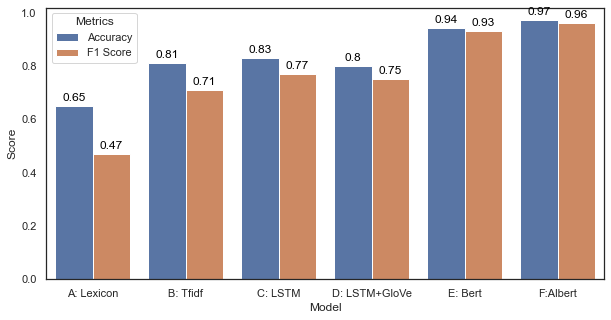

In [125]:
plt.figure(figsize=(10,5))
g = sns.barplot(x='Model', y='Score', hue='Metrics', data=result_metrics)

for index, row in result_metrics.loc[result_metrics['Metrics']=='Accuracy'].iterrows():
    g.text(index-0.2, row.Score+0.02, row.Score, color='black', ha="center")
for index, row in result_metrics.loc[result_metrics['Metrics']=='F1 Score'].iterrows():
    g.text(index-5.8, row.Score+0.02, row.Score, color='black', ha="center")
plt.show()


# Save Data

In [73]:
def save_data(df, file_name, dir_name=output_dir):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [74]:
# Save text data
save_data(train_df, 'finphrase_result_df')